In [2]:
#@title Imports

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [1]:
#@title Constants

# The number of mesh nodes
n = 200

# The number of randomly generated values for V
m = 40

# True if using the localisation loss 
localisation_loss = True

# The epoch that we refresh our model and apply the localisation loss
refresh_epoch = 2000

lr = 3e-4

n_epochs = 9000

# choose the number of eigenstates to find
num_eigenstates = 4

patience_threshold = 40

loss_threshold = 2000

# True if we want to recompile the model at the refresh epoch
recompile_model = False

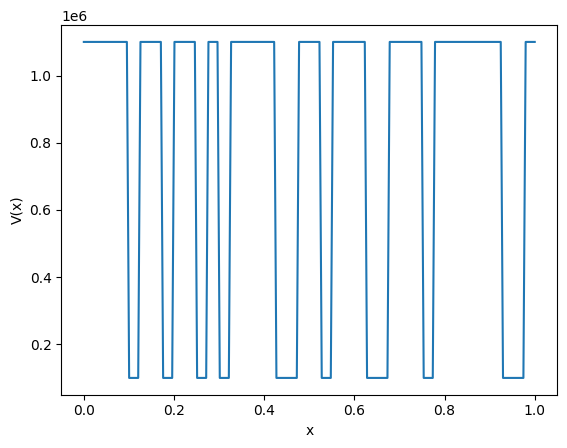

In [3]:
#@title Data


# uniform
# V_init = 10**6*np.random.rand(m,)

# normal
# V_init = 10**6*np.random.normal(1, 0.3, size=(m,))


# lognormal
# V_init = 10**6*np.random.lognormal(0, 1, size=(m,))

# bernoulli
V_init = 10**6*np.random.binomial(1, 0.5, size=(m,)).astype("float64") + 10**5


x = np.linspace(0,1,n)

def V_fun(x):
  return V_init[int(np.floor(x*m - 1))]

V = np.array([V_fun(xn) for xn in x[:-1]] + [V_init[-2]])

old_V = V

true_V_init = np.concatenate(([V_init[-1]], V_init[:-1]))

plt.xlabel("x")
plt.ylabel("V(x)")
plt.plot(x, V)

In [4]:
#@title Functions

ev = tf.Variable(np.ones((1)), trainable=True)
evec_size = n
h = x[1] - x[0]
train_output = tf.ones([n,])
train_inputs = tf.reshape(tf.tile(x, [1]), [1, n])
train_outputs = tf.reshape(tf.tile(train_output, [1]), [1, n])


# Calculate derivative at inner point (non-endpoint). m3 means -3 points from the central point, p3 means p3
# O(h**6)
def innerSecDer(m3,m2,m1,p0,p1,p2,p3):
  return (1/90*m3 - 3/20*m2 + 3/2*m1 - 49/18*p0 + 3/2*p1 - 3/20*p2 + 1/90*p3)/h**2


# Calculate derivative at right endpoint. m2 means -2 points from the calculated point (m0)
# O(h**5)
def rightEndSecDer(m6,m5,m4,m3,m2,m1,m0):
  return (203/45*m0 - 87/5*m1 + 117/4*m2 - 254/9*m3 + 33/2*m4 - 27/5*m5 + 137/180*m6)/h**2

# O(h**5)
def leftEndSecDer(p0,p1,p2,p3,p4,p5,p6):
  return (203/45*p0 - 87/5*p1 + 117/4*p2 - 254/9*p3 + 33/2*p4 - 27/5*p5 + 137/180*p6)/h**2


# Calculate the second derivative vector
def secDerivative(v):
  processed = [leftEndSecDer(v[0],v[1],v[2],v[3],v[4],v[5],v[6]),
                      leftEndSecDer(v[1],v[2],v[3],v[4],v[5],v[6],v[7]),
                      leftEndSecDer(v[2],v[3],v[4],v[5],v[6],v[7],v[8])]
  right_derivatives = [
                       rightEndSecDer(v[-9],v[-8],v[-7],v[-6],v[-5],v[-4],v[-3]),
                       rightEndSecDer(v[-8],v[-7],v[-6],v[-5],v[-4],v[-3],v[-2]),
                       rightEndSecDer(v[-7],v[-6],v[-5],v[-4],v[-3],v[-2],v[-1])]

  unstacked = tf.unstack(v)
  for i in range(0,len(unstacked)-6):
    processed.append(innerSecDer(unstacked[i], unstacked[i+1], unstacked[i+2], unstacked[i+3], unstacked[i+4], unstacked[i+5], unstacked[i+6]))
  
  for der in right_derivatives:
    processed.append(der)

  return tf.stack(processed, 0)
  

def midpoint_area(p1,p2):
  return h*(p2+p1)/2

def integral(tensor):
  processed = []
  unstacked = tf.unstack(tensor)
  for i in range(0,len(unstacked)-1):
    processed.append(midpoint_area(unstacked[i], unstacked[i+1]))

  return tf.math.reduce_sum(tf.stack(processed, 0))



# check if a list of values has converged
# assuming len(list) >= 5
def patience_test(lst):
  assert len(lst) >= 5

  # calculating the backwards difference
  eps = np.abs(1/4*lst[-5] - 4/3*lst[-4] + 3*lst[-3] - 4*lst[-2] + 25/12*lst[-1])

  return eps < patience_threshold


def has_converged(ev_list, evec_list):

  losses_tail = [tf.math.sqrt(tf.math.reduce_mean((ev_list[-1]*evec + secDerivative(evec) - V*evec)**2)) for evec in evec_list[-6:]]

  return patience_test(ev_list) and losses_tail[-1] < loss_threshold and patience_test(losses_tail)


idx_groups = []
idxs_one_hot = tf.Variable(tf.zeros(m))


def collect_idxs(lst, tf_variable=False):
    
    # if the input is a tensorflow variable, convert it to a list
    if tf_variable:
        lst = lst.numpy().tolist()

    if not lst:
        return []
    
    groups = []
    group = [lst[0]]
    
    for i in range(1, len(lst)):
        if lst[i] == lst[i-1] + 1:
            group.append(lst[i])
        else:
            groups.append(group)
            group = [lst[i]]
    
    groups.append(group)
    
    return groups


def assign_idx_groups(evec):
    global idx_groups

    idxs = []
    norms = [integral(segment**2) for segment in split(evec)]
    for i in range(len(norms)):
        if norms[i] > 0.01:
            idxs.append(i)
    
    idx_groups = collect_idxs(idxs)
    # sort idx_groups by the norms, putting the largest first
    idx_groups = sorted(idx_groups, key = lambda lst: sum(norms[i] for i in lst), reverse=True)

    

    # for group in idx_groups_lst:
    #     idx_groups.append(group)


def idxs_to_one_hot(idxs, padding=True):
   
  if padding:
    if idxs[0] != 0:
      idxs = [idxs[0] - 1] + idxs
    if idxs[-1] != m - 1:
      idxs.append(idxs[-1] + 1)
   
  return tf.math.reduce_sum(tf.one_hot(idxs, m), axis=0)


# Split evec into segements to be integrated over to determine localisation regions.
# The split needs include one more element to allow integration of the segments
# to sum to the whole integral
def split(evec):
  segments = []

  unstacked = tf.unstack(evec)

  split_size = n//m
  for i in range(m):
    start = i*split_size
    end = start + split_size
    if i == m-1:
      segments.append(tf.stack(evec[start:end]))
    else:
      segments.append(tf.stack(evec[start:end+1]))

  return segments



# initialise variables
collected_evecs = []
collected_evs = []

ev_list = []
evec_list = []

loc_idx = tf.Variable(-1, dtype=tf.int64)
used_loc_idxs = []

eigenstate: 1, epoch: 0
ev: 0.0057518193, norm: 0.35022235, pde: 626627.6, loss: 3972819.5, loc_idx: -1, used_loc_idxs: []


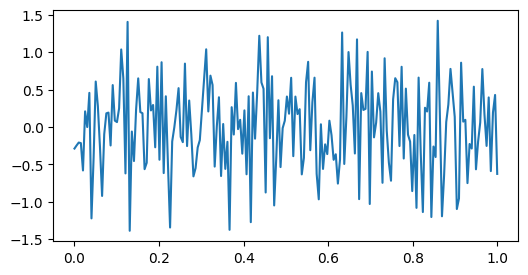

eigenstate: 1, epoch: 100
ev: 3.435044, norm: 0.9799299, pde: 600601.06, loss: 604848.4, loc_idx: -1, used_loc_idxs: []


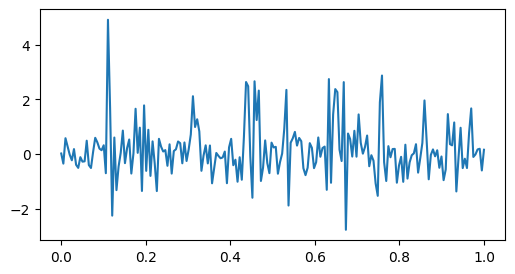

eigenstate: 1, epoch: 200
ev: 20.951565, norm: 0.9893337, pde: 326501.8, loss: 327504.62, loc_idx: -1, used_loc_idxs: []


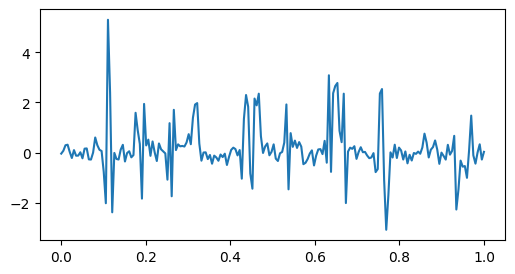

eigenstate: 1, epoch: 300
ev: 72.86296, norm: 0.99273664, pde: 212093.27, loss: 212547.73, loc_idx: -1, used_loc_idxs: []


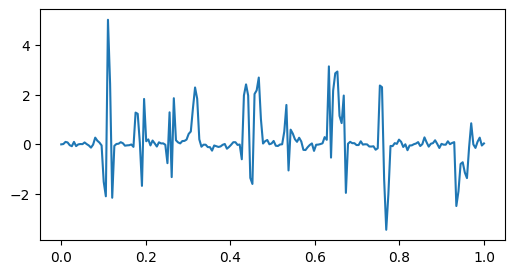

eigenstate: 1, epoch: 400
ev: 180.44362, norm: 0.99436015, pde: 172079.12, loss: 172334.52, loc_idx: -1, used_loc_idxs: []


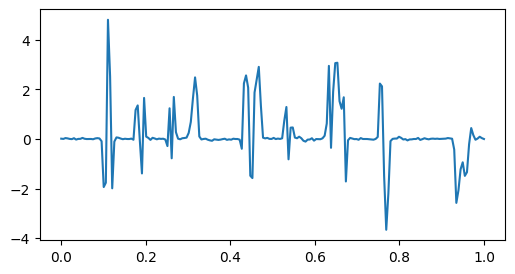

eigenstate: 1, epoch: 500
ev: 354.10486, norm: 0.99508333, pde: 154769.34, loss: 154965.12, loc_idx: -1, used_loc_idxs: []


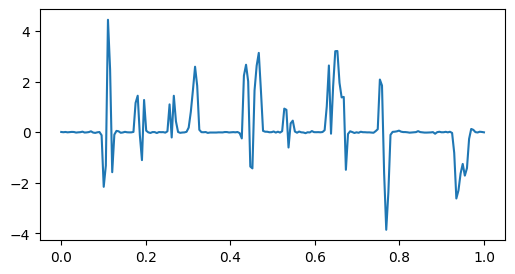

eigenstate: 1, epoch: 600
ev: 604.1611, norm: 0.99540865, pde: 139050.98, loss: 139219.69, loc_idx: -1, used_loc_idxs: []


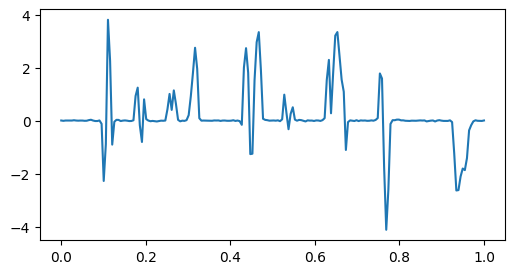

eigenstate: 1, epoch: 700
ev: 943.36755, norm: 0.995418, pde: 126758.56, loss: 126926.43, loc_idx: -1, used_loc_idxs: []


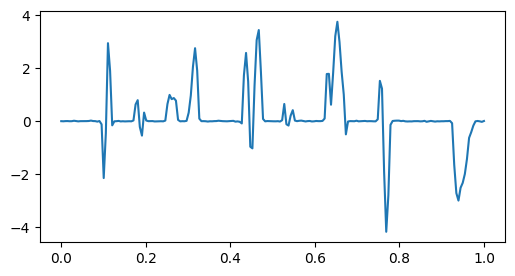

eigenstate: 1, epoch: 800
ev: 1381.5778, norm: 0.99531037, pde: 118628.4, loss: 118803.32, loc_idx: -1, used_loc_idxs: []


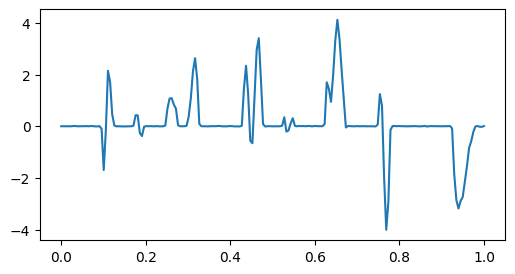

eigenstate: 1, epoch: 900
ev: 1926.3632, norm: 0.99687976, pde: 113083.59, loss: 113161.91, loc_idx: -1, used_loc_idxs: []


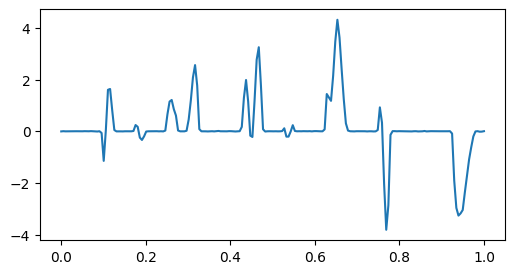

eigenstate: 1, epoch: 1000
ev: 2585.2456, norm: 0.99820703, pde: 108496.56, loss: 108523.24, loc_idx: -1, used_loc_idxs: []


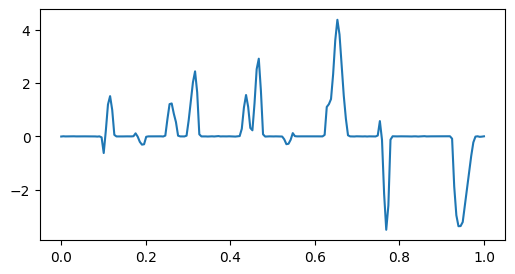

eigenstate: 1, epoch: 1100
ev: 3365.0579, norm: 0.9984115, pde: 105033.44, loss: 105054.44, loc_idx: -1, used_loc_idxs: []


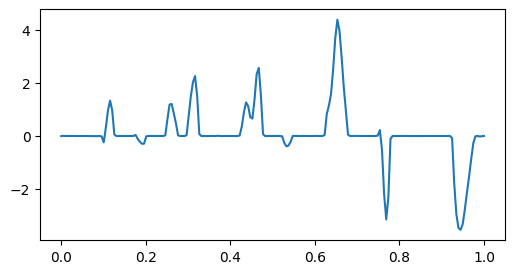

eigenstate: 1, epoch: 1200
ev: 4271.6597, norm: 0.99474853, pde: 102176.17, loss: 102393.58, loc_idx: -1, used_loc_idxs: []


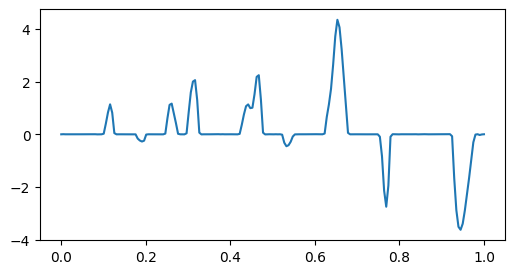

eigenstate: 1, epoch: 1300
ev: 5310.3525, norm: 0.9968493, pde: 100173.42, loss: 100251.875, loc_idx: -1, used_loc_idxs: []


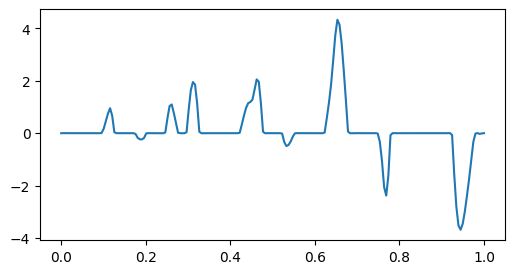

eigenstate: 1, epoch: 1400
ev: 6485.896, norm: 0.9967055, pde: 98361.086, loss: 98446.75, loc_idx: -1, used_loc_idxs: []


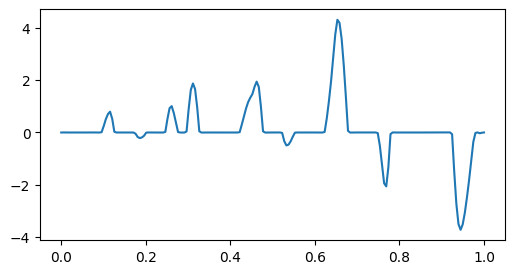

eigenstate: 1, epoch: 1500
ev: 7802.692, norm: 0.9965135, pde: 96665.09, loss: 96760.98, loc_idx: -1, used_loc_idxs: []


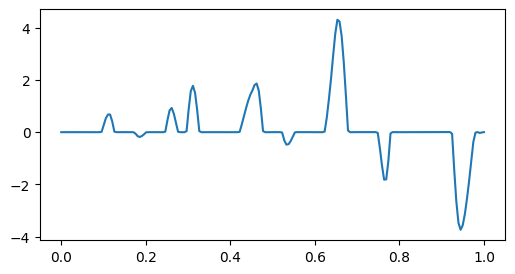

eigenstate: 1, epoch: 1600
ev: 9264.85, norm: 0.9961215, pde: 94947.836, loss: 95066.48, loc_idx: -1, used_loc_idxs: []


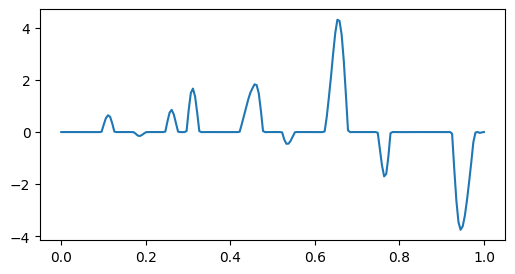

eigenstate: 1, epoch: 1700
ev: 10876.369, norm: 0.99341303, pde: 93048.45, loss: 93390.72, loc_idx: -1, used_loc_idxs: []


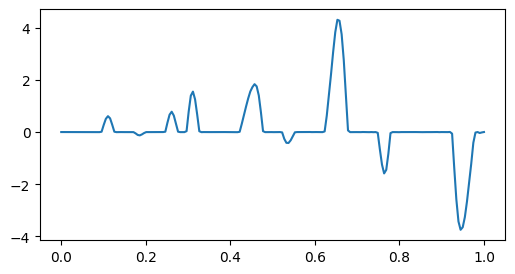

eigenstate: 1, epoch: 1800
ev: 12640.871, norm: 0.99820936, pde: 91356.28, loss: 91381.66, loc_idx: -1, used_loc_idxs: []


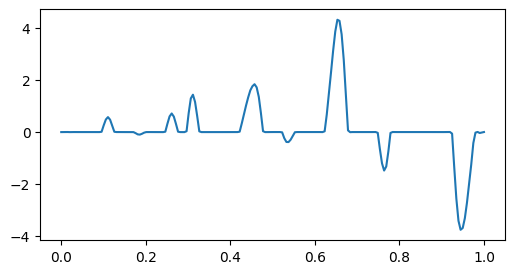

eigenstate: 1, epoch: 1900
ev: 14561.844, norm: 0.9962932, pde: 89227.85, loss: 89336.2, loc_idx: -1, used_loc_idxs: []


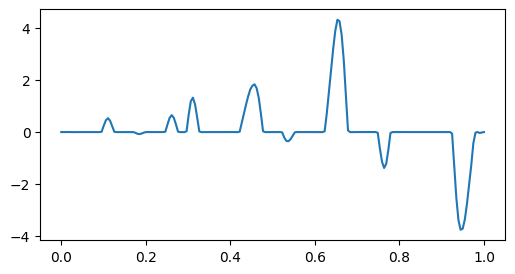

SETTING IDX_GROUPS
idx_groups: [[25, 26], [37, 38], [17, 18], [30], [12]]
eigenstate: 1, epoch: 2000
ev: 16642.584, norm: 0.99790066, pde: 87119.78, loss: 87154.69, loc_idx: 0, used_loc_idxs: []


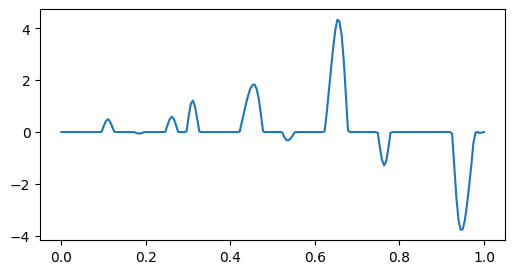

eigenstate: 1, epoch: 2100
ev: 18017.057, norm: 0.9906983, pde: 128945.43, loss: 158310.3, loc_idx: 0, used_loc_idxs: []


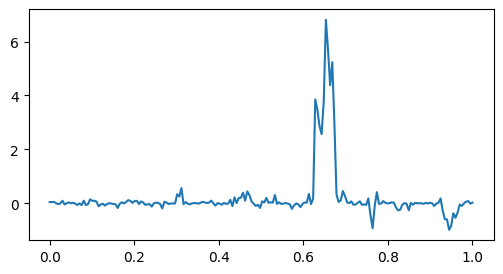

eigenstate: 1, epoch: 2200
ev: 20229.402, norm: 0.99610674, pde: 93856.48, loss: 99436.64, loc_idx: 0, used_loc_idxs: []


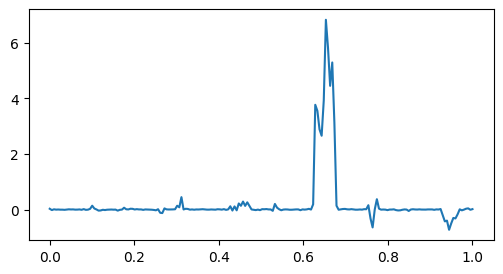

eigenstate: 1, epoch: 2300
ev: 22798.764, norm: 0.9968065, pde: 89571.32, loss: 91689.34, loc_idx: 0, used_loc_idxs: []


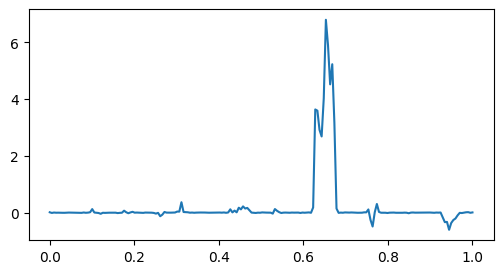

eigenstate: 1, epoch: 2400
ev: 25548.6, norm: 0.9970921, pde: 85684.625, loss: 86791.734, loc_idx: 0, used_loc_idxs: []


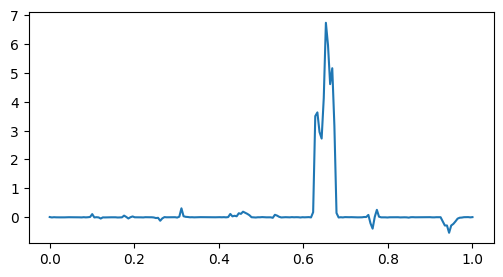

eigenstate: 1, epoch: 2500
ev: 28475.309, norm: 0.99728185, pde: 81789.7, loss: 82477.32, loc_idx: 0, used_loc_idxs: []


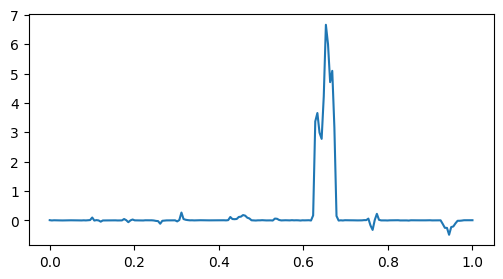

eigenstate: 1, epoch: 2600
ev: 31579.832, norm: 0.997442, pde: 77833.32, loss: 78305.6, loc_idx: 0, used_loc_idxs: []


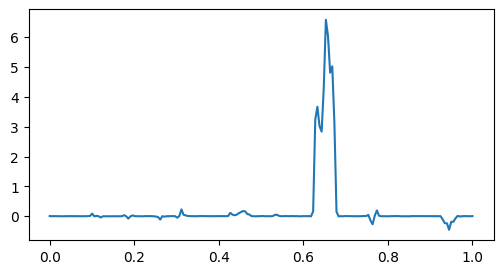

eigenstate: 1, epoch: 2700
ev: 34863.69, norm: 0.9975983, pde: 73793.336, loss: 74137.64, loc_idx: 0, used_loc_idxs: []


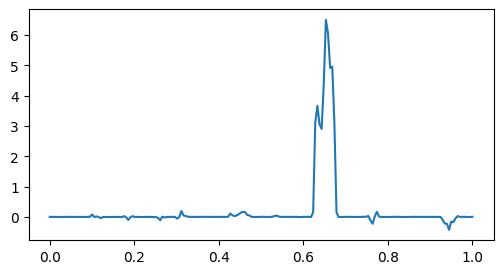

eigenstate: 1, epoch: 2800
ev: 38328.656, norm: 0.9977477, pde: 69628.19, loss: 69884.58, loc_idx: 0, used_loc_idxs: []


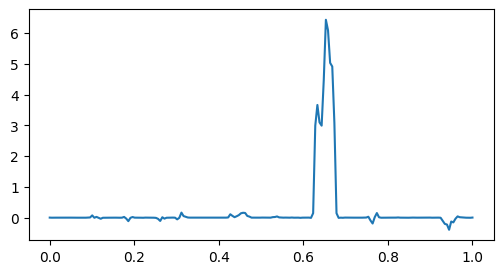

eigenstate: 1, epoch: 2900
ev: 41977.07, norm: 0.9978757, pde: 65318.78, loss: 65510.516, loc_idx: 0, used_loc_idxs: []


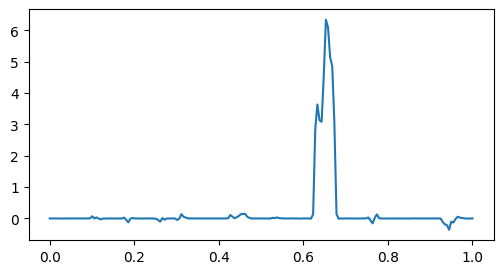

eigenstate: 1, epoch: 3000
ev: 45811.293, norm: 0.9980574, pde: 60869.543, loss: 61011.6, loc_idx: 0, used_loc_idxs: []


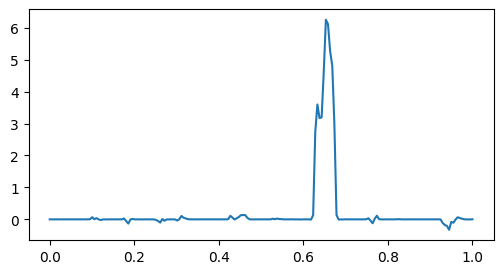

eigenstate: 1, epoch: 3100
ev: 49833.625, norm: 0.99818915, pde: 56283.227, loss: 56389.938, loc_idx: 0, used_loc_idxs: []


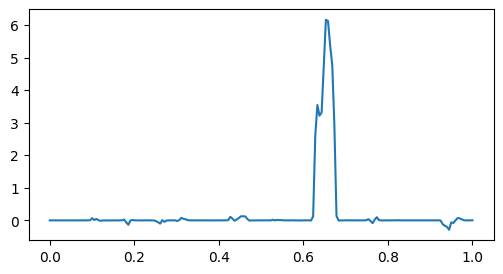

eigenstate: 1, epoch: 3200
ev: 54046.15, norm: 0.9983641, pde: 51573.65, loss: 51652.344, loc_idx: 0, used_loc_idxs: []


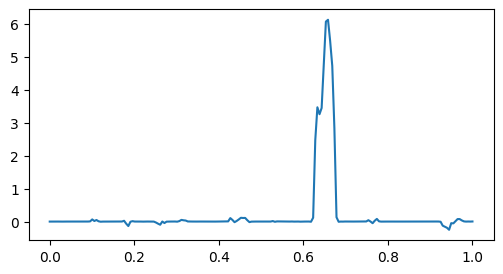

eigenstate: 1, epoch: 3300
ev: 58450.43, norm: 0.9984886, pde: 46745.113, loss: 46803.72, loc_idx: 0, used_loc_idxs: []


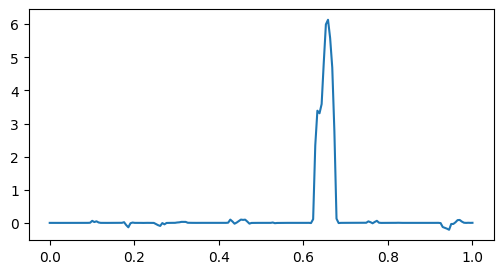

eigenstate: 1, epoch: 3400
ev: 63047.71, norm: 0.99866503, pde: 41798.95, loss: 41842.145, loc_idx: 0, used_loc_idxs: []


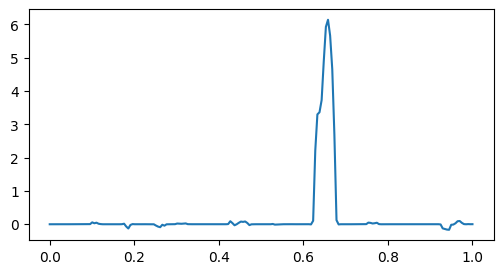

eigenstate: 1, epoch: 3500
ev: 67838.81, norm: 0.99882925, pde: 36730.266, loss: 36762.84, loc_idx: 0, used_loc_idxs: []


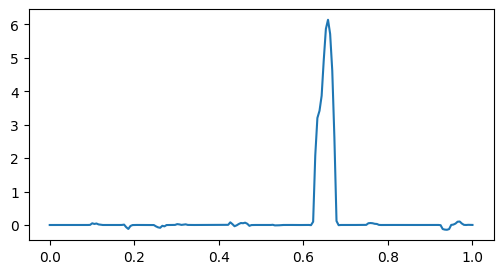

eigenstate: 1, epoch: 3600
ev: 72823.9, norm: 0.9989801, pde: 31534.57, loss: 31559.955, loc_idx: 0, used_loc_idxs: []


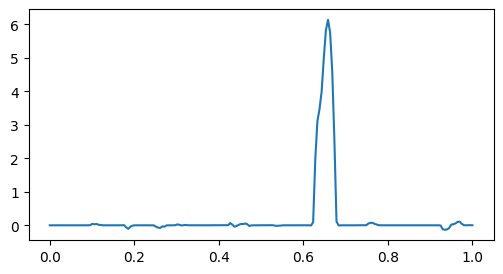

eigenstate: 1, epoch: 3700
ev: 78001.734, norm: 0.9991521, pde: 26241.816, loss: 26262.098, loc_idx: 0, used_loc_idxs: []


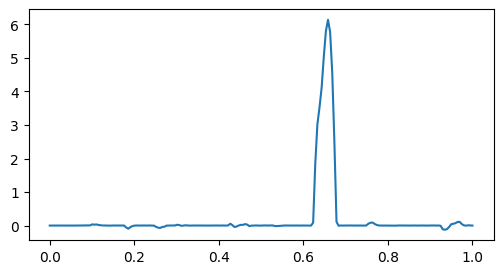

eigenstate: 1, epoch: 3800
ev: 83361.02, norm: 0.9993626, pde: 20761.082, loss: 20776.69, loc_idx: 0, used_loc_idxs: []


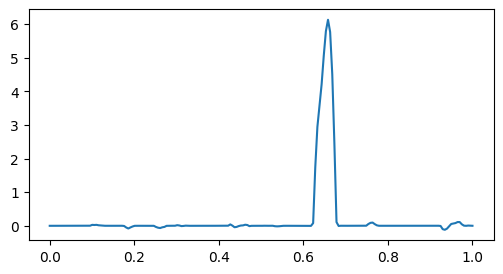

eigenstate: 1, epoch: 3900
ev: 88848.28, norm: 0.9996744, pde: 15640.407, loss: 15652.263, loc_idx: 0, used_loc_idxs: []


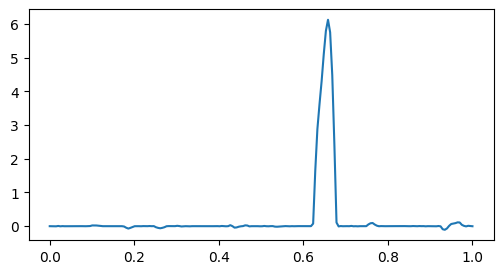

eigenstate: 1, epoch: 4000
ev: 94173.56, norm: 0.9995804, pde: 11507.479, loss: 11517.796, loc_idx: 0, used_loc_idxs: []


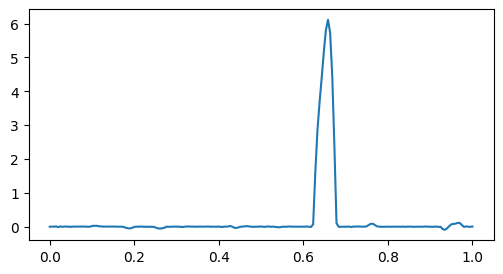

eigenstate: 1, epoch: 4100
ev: 98732.086, norm: 0.99998546, pde: 8626.964, loss: 8634.283, loc_idx: 0, used_loc_idxs: []


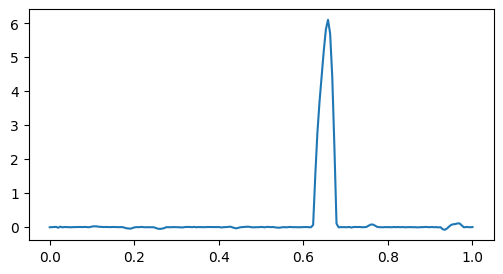

eigenstate: 1, epoch: 4200
ev: 101782.055, norm: 0.9996606, pde: 6505.9663, loss: 6512.4873, loc_idx: 0, used_loc_idxs: []


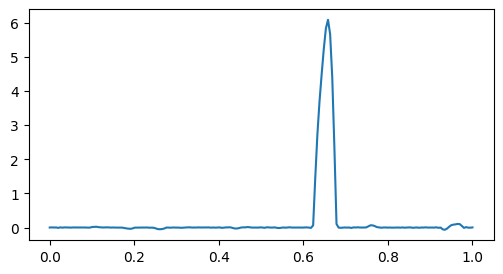

eigenstate: 1, epoch: 4300
ev: 103162.51, norm: 1.0002159, pde: 5561.5176, loss: 5566.8926, loc_idx: 0, used_loc_idxs: []


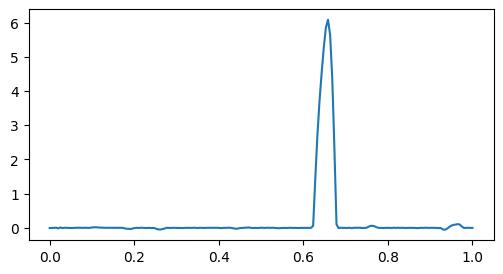

eigenstate: 1, epoch: 4400
ev: 103548.375, norm: 0.9995599, pde: 4825.476, loss: 4831.1577, loc_idx: 0, used_loc_idxs: []


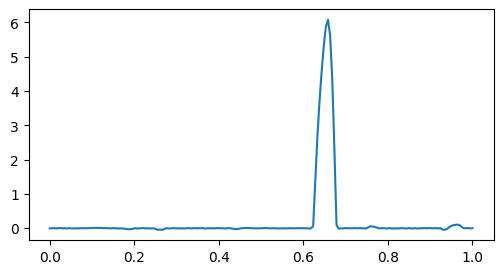

eigenstate: 1, epoch: 4500
ev: 103601.984, norm: 0.9996375, pde: 4515.664, loss: 4520.3193, loc_idx: 0, used_loc_idxs: []


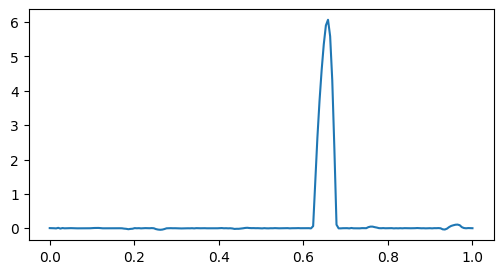

eigenstate: 1, epoch: 4600
ev: 103589.016, norm: 1.0000017, pde: 4230.171, loss: 4232.946, loc_idx: 0, used_loc_idxs: []


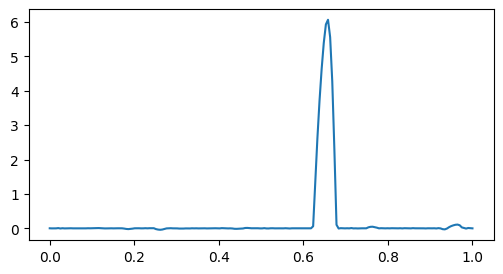

eigenstate: 1, epoch: 4700
ev: 103569.65, norm: 0.9995156, pde: 3960.6997, loss: 3965.4673, loc_idx: 0, used_loc_idxs: []


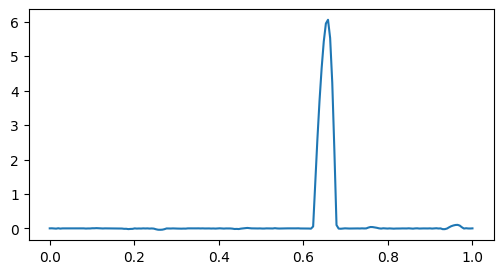

eigenstate: 1, epoch: 4800
ev: 103550.44, norm: 0.9996619, pde: 3808.8628, loss: 3812.0557, loc_idx: 0, used_loc_idxs: []


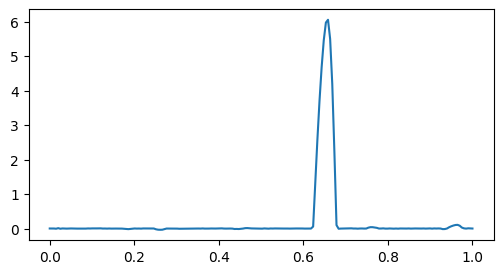

eigenstate: 1, epoch: 4900
ev: 103533.42, norm: 0.99976933, pde: 3665.7065, loss: 3668.3972, loc_idx: 0, used_loc_idxs: []


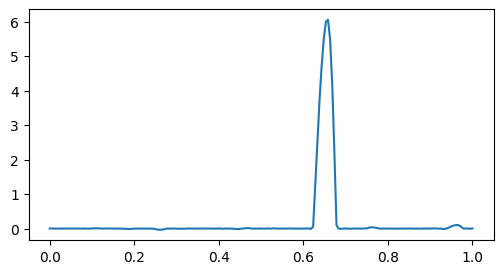

eigenstate: 1, epoch: 5000
ev: 103518.84, norm: 0.9996107, pde: 3514.6763, loss: 3517.843, loc_idx: 0, used_loc_idxs: []


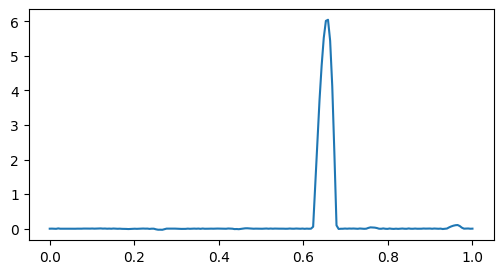

eigenstate: 1, epoch: 5100
ev: 103504.1, norm: 0.99974734, pde: 3426.5134, loss: 3429.1265, loc_idx: 0, used_loc_idxs: []


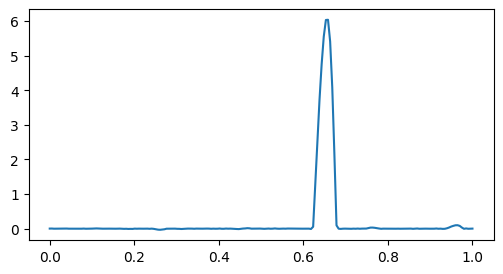

eigenstate: 1, epoch: 5200
ev: 103491.266, norm: 0.9999067, pde: 3352.77, loss: 3354.77, loc_idx: 0, used_loc_idxs: []


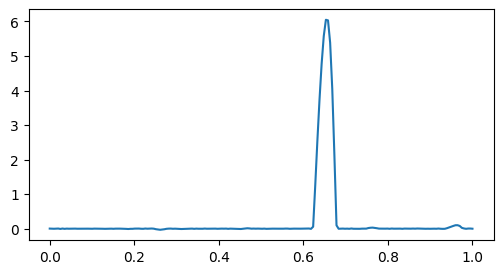

eigenstate: 1, epoch: 5300
ev: 103478.79, norm: 0.999772, pde: 3271.9644, loss: 3274.2573, loc_idx: 0, used_loc_idxs: []


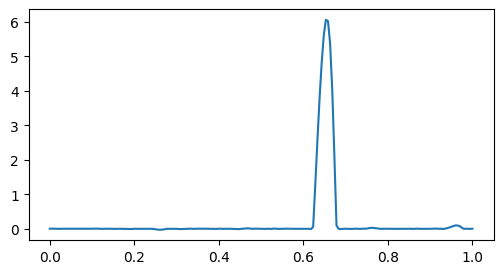

eigenstate: 1, epoch: 5400
ev: 103467.586, norm: 1.000299, pde: 3215.5571, loss: 3217.9365, loc_idx: 0, used_loc_idxs: []


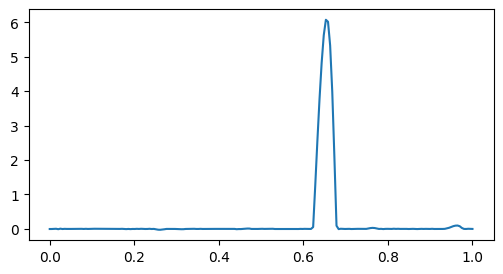

eigenstate: 1, epoch: 5500
ev: 103455.97, norm: 1.0003105, pde: 3128.0884, loss: 3130.1487, loc_idx: 0, used_loc_idxs: []


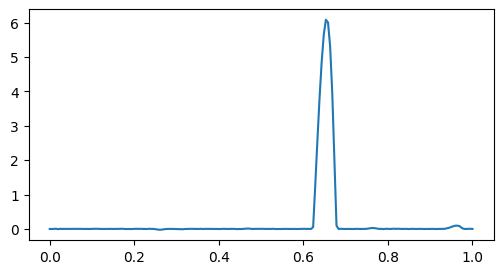

eigenstate: 1, epoch: 5600
ev: 103444.97, norm: 1.0002834, pde: 3102.6292, loss: 3104.9355, loc_idx: 0, used_loc_idxs: []


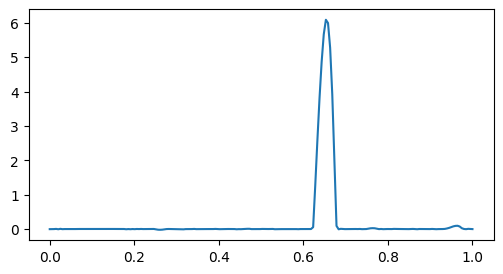

eigenstate: 1, epoch: 5700
ev: 103435.94, norm: 1.0001173, pde: 3049.096, loss: 3050.2717, loc_idx: 0, used_loc_idxs: []


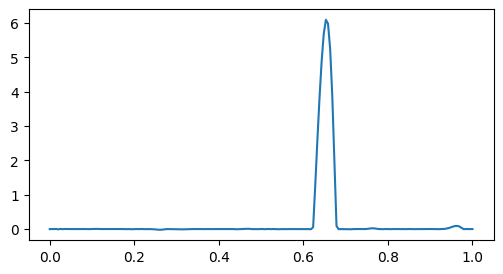

eigenstate: 1, epoch: 5800
ev: 103425.59, norm: 0.99974763, pde: 2994.1716, loss: 2995.7126, loc_idx: 0, used_loc_idxs: []


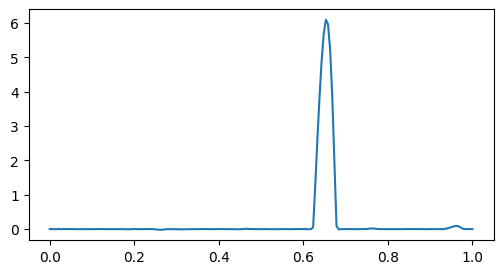

eigenstate: 1, epoch: 5900
ev: 103415.81, norm: 1.0000165, pde: 2947.9502, loss: 2949.1626, loc_idx: 0, used_loc_idxs: []


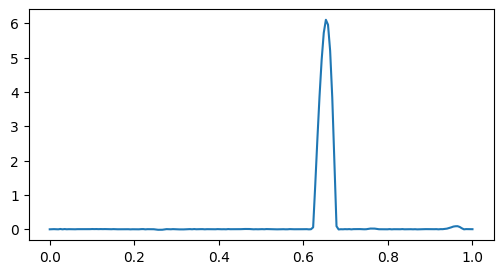

eigenstate: 1, epoch: 6000
ev: 103406.65, norm: 0.99999857, pde: 2916.3816, loss: 2917.136, loc_idx: 0, used_loc_idxs: []


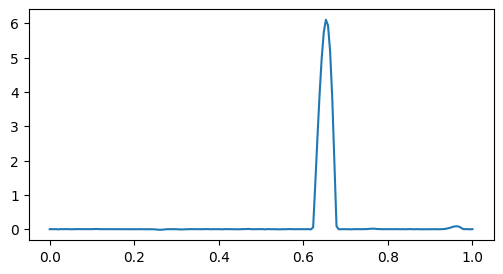

eigenstate: 1, epoch: 6100
ev: 103397.66, norm: 1.0001857, pde: 2856.4004, loss: 2858.0823, loc_idx: 0, used_loc_idxs: []


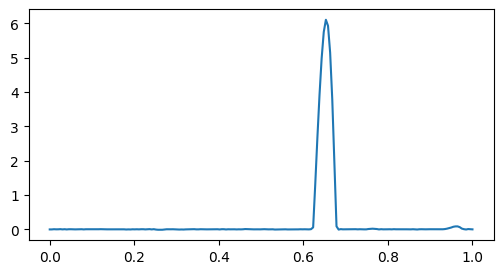

eigenstate: 1, epoch: 6200
ev: 103388.28, norm: 0.9997897, pde: 2847.0732, loss: 2848.0916, loc_idx: 0, used_loc_idxs: []


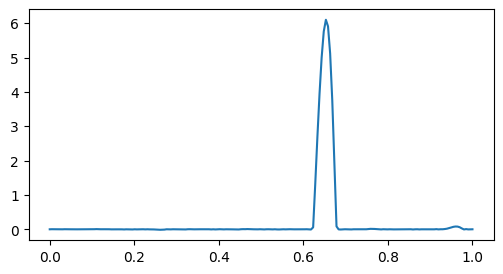

eigenstate: 1, epoch: 6300
ev: 103381.0, norm: 0.99968654, pde: 2797.0513, loss: 2798.7217, loc_idx: 0, used_loc_idxs: []


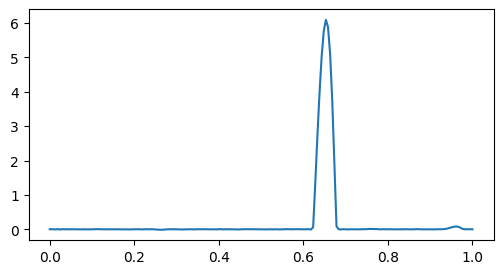

eigenstate: 1, epoch: 6400
ev: 103372.016, norm: 0.99999654, pde: 2754.08, loss: 2754.6177, loc_idx: 0, used_loc_idxs: []


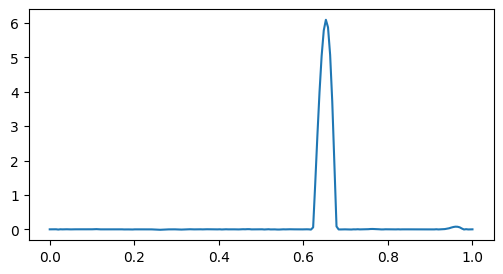

eigenstate: 1, epoch: 6500
ev: 103364.914, norm: 1.0002986, pde: 2718.1394, loss: 2719.643, loc_idx: 0, used_loc_idxs: []


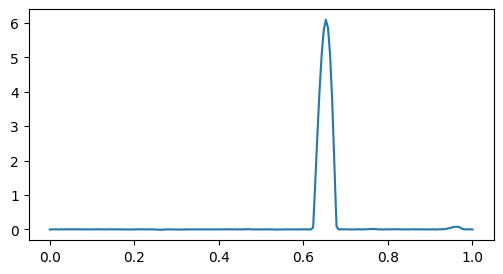

eigenstate: 1, epoch: 6600
ev: 103357.1, norm: 1.0002449, pde: 2683.723, loss: 2685.0476, loc_idx: 0, used_loc_idxs: []


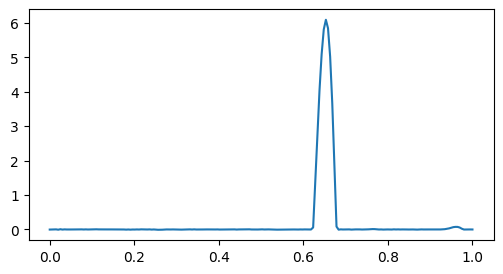

eigenstate: 1, epoch: 6700
ev: 103351.55, norm: 0.9997063, pde: 2672.8608, loss: 2674.1516, loc_idx: 0, used_loc_idxs: []


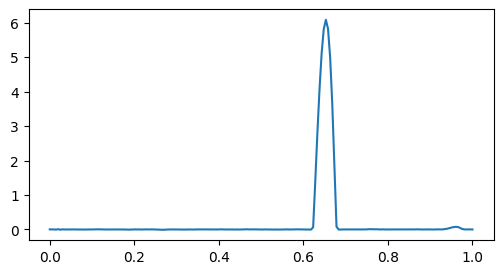

eigenstate: 1, epoch: 6800
ev: 103343.85, norm: 0.99996865, pde: 2633.0261, loss: 2633.414, loc_idx: 0, used_loc_idxs: []


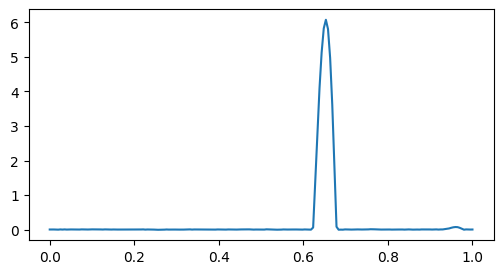

eigenstate: 1, epoch: 6900
ev: 103337.73, norm: 0.9998438, pde: 2610.3728, loss: 2610.979, loc_idx: 0, used_loc_idxs: []


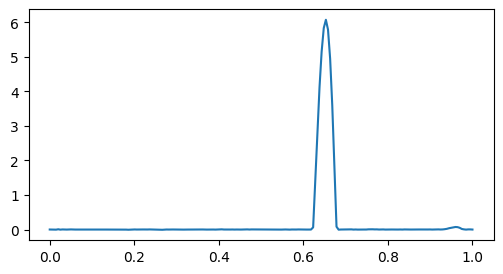

eigenstate: 1, epoch: 7000
ev: 103333.95, norm: 1.0000662, pde: 2577.2136, loss: 2577.692, loc_idx: 0, used_loc_idxs: []


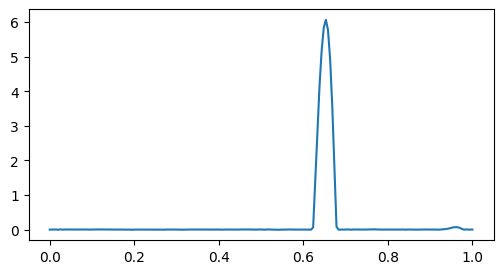

eigenstate: 1, epoch: 7100
ev: 103326.734, norm: 0.99988234, pde: 2535.752, loss: 2536.228, loc_idx: 0, used_loc_idxs: []


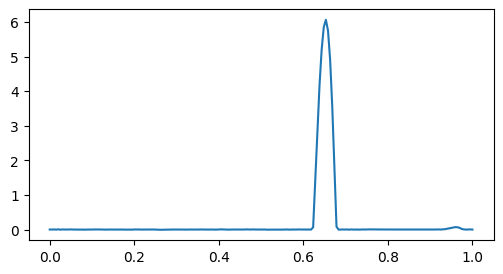

eigenstate: 1, epoch: 7200
ev: 103322.55, norm: 0.9999427, pde: 2510.0945, loss: 2510.4172, loc_idx: 0, used_loc_idxs: []


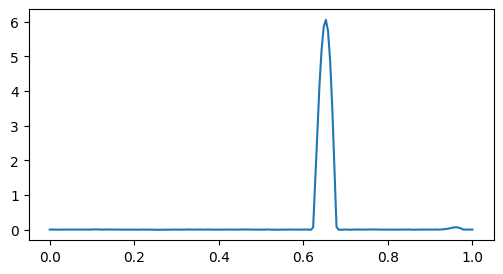

eigenstate: 1, epoch: 7300
ev: 103318.77, norm: 1.0002472, pde: 2477.6514, loss: 2478.9946, loc_idx: 0, used_loc_idxs: []


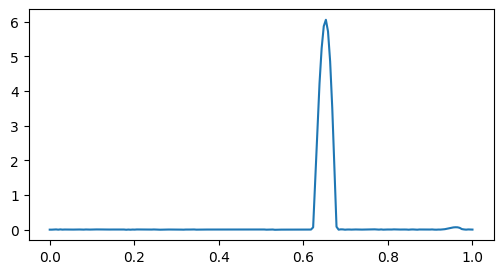

eigenstate: 1, epoch: 7400
ev: 103315.78, norm: 0.9997281, pde: 2501.9578, loss: 2503.0964, loc_idx: 0, used_loc_idxs: []


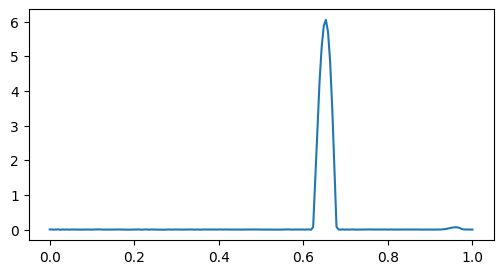

eigenstate: 1, epoch: 7500
ev: 103310.484, norm: 0.9998083, pde: 2447.2627, loss: 2447.8748, loc_idx: 0, used_loc_idxs: []


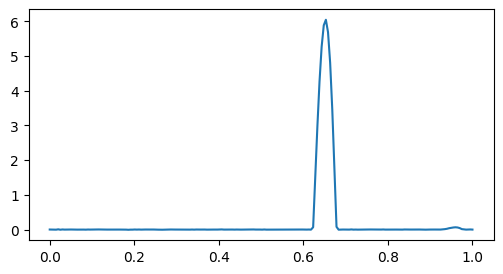

eigenstate: 1, epoch: 7600
ev: 103307.9, norm: 0.9998684, pde: 2425.309, loss: 2425.7048, loc_idx: 0, used_loc_idxs: []


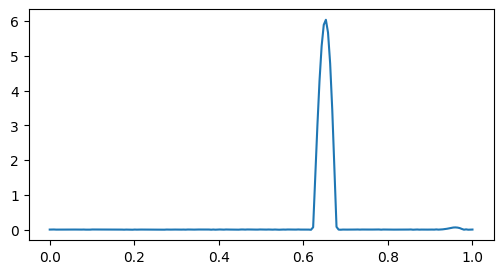

eigenstate: 1, epoch: 7700
ev: 103304.8, norm: 1.0000991, pde: 2416.7449, loss: 2417.1167, loc_idx: 0, used_loc_idxs: []


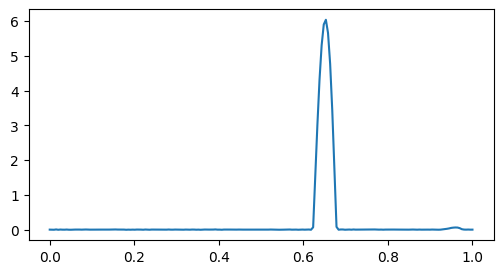

eigenstate: 1, epoch: 7800
ev: 103302.19, norm: 0.999717, pde: 2381.6643, loss: 2382.5266, loc_idx: 0, used_loc_idxs: []


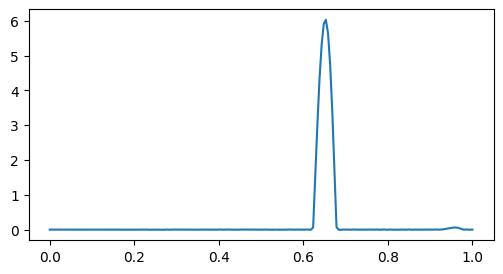

eigenstate: 1, epoch: 7900
ev: 103300.12, norm: 0.9998382, pde: 2374.0059, loss: 2374.4333, loc_idx: 0, used_loc_idxs: []


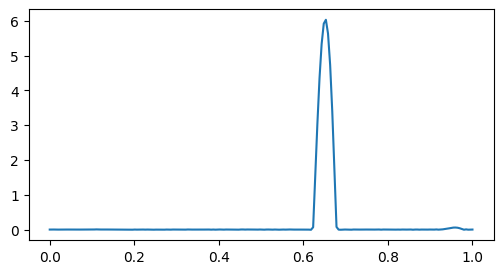

eigenstate: 1, epoch: 8000
ev: 103298.19, norm: 1.0001004, pde: 2356.143, loss: 2356.491, loc_idx: 0, used_loc_idxs: []


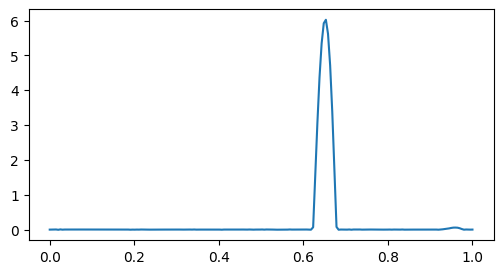

eigenstate: 1, epoch: 8100
ev: 103298.13, norm: 1.0001705, pde: 2334.4062, loss: 2334.8599, loc_idx: 0, used_loc_idxs: []


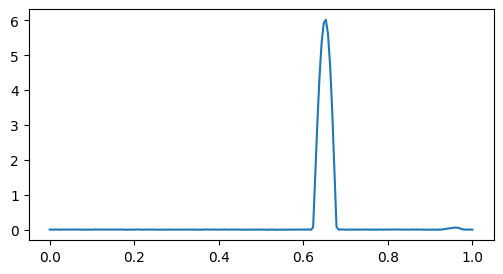

eigenstate: 1, epoch: 8200
ev: 103295.49, norm: 0.99976575, pde: 2341.5337, loss: 2342.6895, loc_idx: 0, used_loc_idxs: []


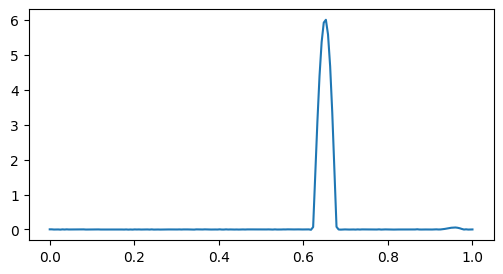

eigenstate: 1, epoch: 8300
ev: 103294.92, norm: 0.99978673, pde: 2329.2102, loss: 2329.8713, loc_idx: 0, used_loc_idxs: []


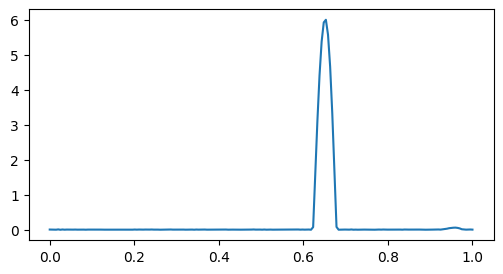

eigenstate: 1, epoch: 8400
ev: 103294.38, norm: 0.9999193, pde: 2309.5964, loss: 2309.9248, loc_idx: 0, used_loc_idxs: []


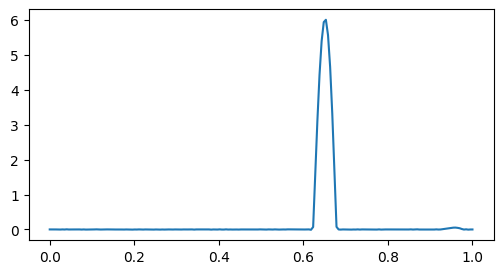

eigenstate: 1, epoch: 8500
ev: 103292.62, norm: 0.99997693, pde: 2278.831, loss: 2279.0063, loc_idx: 0, used_loc_idxs: []


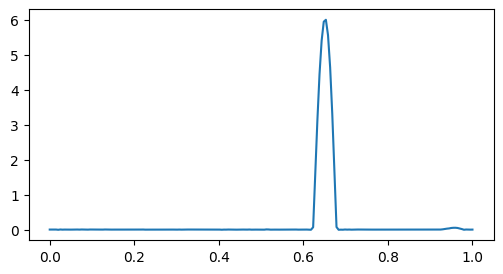

eigenstate: 1, epoch: 8600
ev: 103291.31, norm: 1.000234, pde: 2258.5486, loss: 2259.2375, loc_idx: 0, used_loc_idxs: []


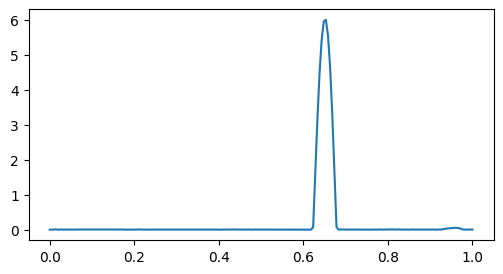

eigenstate: 1, epoch: 8700
ev: 103290.92, norm: 0.9997394, pde: 2074.4856, loss: 2075.2578, loc_idx: 0, used_loc_idxs: []


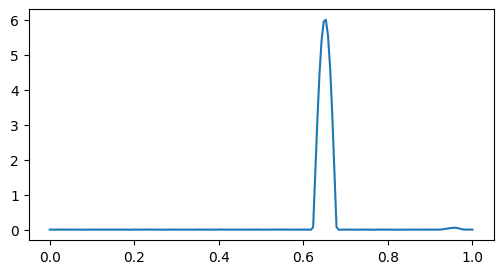

eigenstate: 1, epoch: 8800
ev: 103290.06, norm: 0.99981457, pde: 2070.3167, loss: 2070.8674, loc_idx: 0, used_loc_idxs: []


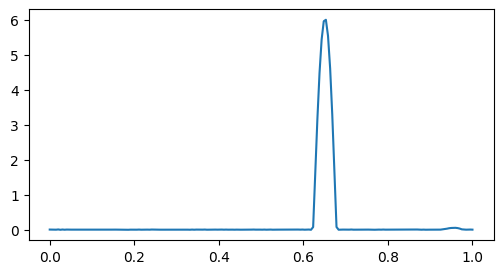

eigenstate: 1, epoch: 8900
ev: 103289.0, norm: 1.0001824, pde: 1428.4867, loss: 1428.8861, loc_idx: 0, used_loc_idxs: []


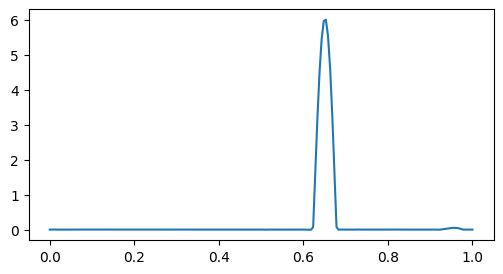

OUT OF EPOCHS
eigenstate: 2, epoch: 0
ev: 0.03964966, norm: 0.33670202, pde: 657003.75, loss: 4132746.8, loc_idx: -1, used_loc_idxs: []


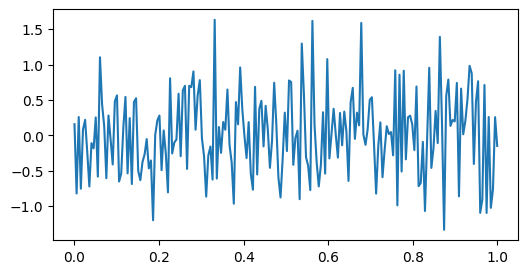

eigenstate: 2, epoch: 100
ev: 3.2141955, norm: 0.9758582, pde: 674170.25, loss: 679624.7, loc_idx: -1, used_loc_idxs: []


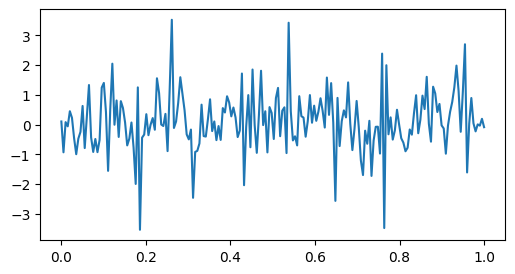

eigenstate: 2, epoch: 200
ev: 18.133867, norm: 0.98454505, pde: 465516.4, loss: 468793.8, loc_idx: -1, used_loc_idxs: []


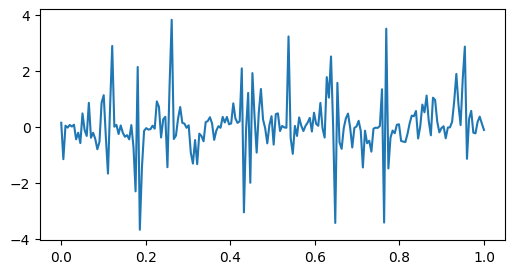

eigenstate: 2, epoch: 300
ev: 59.39851, norm: 0.98852414, pde: 340731.2, loss: 342269.5, loc_idx: -1, used_loc_idxs: []


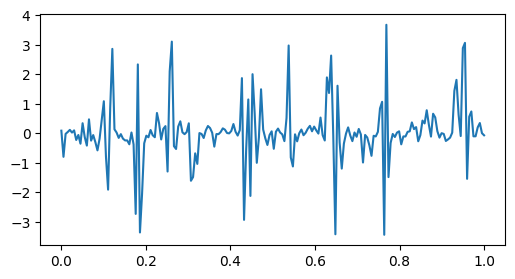

eigenstate: 2, epoch: 400
ev: 144.61871, norm: 0.9916057, pde: 246425.06, loss: 247155.25, loc_idx: -1, used_loc_idxs: []


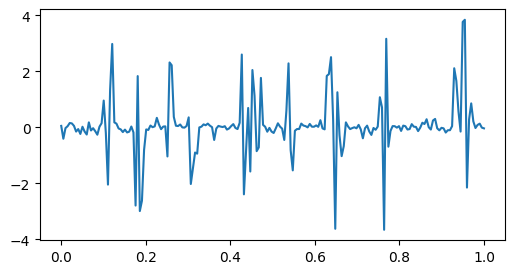

eigenstate: 2, epoch: 500
ev: 289.933, norm: 0.9936162, pde: 203454.2, loss: 203780.67, loc_idx: -1, used_loc_idxs: []


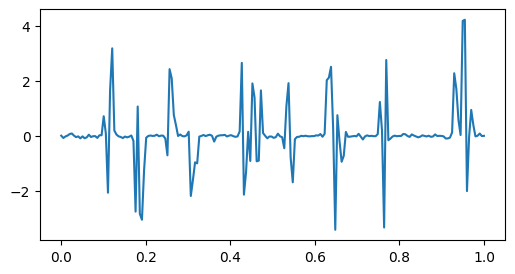

eigenstate: 2, epoch: 600
ev: 500.46097, norm: 0.99342704, pde: 184034.3, loss: 184377.67, loc_idx: -1, used_loc_idxs: []


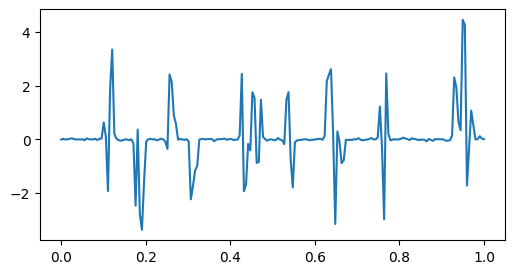

eigenstate: 2, epoch: 700
ev: 781.883, norm: 0.99434763, pde: 167873.19, loss: 168125.89, loc_idx: -1, used_loc_idxs: []


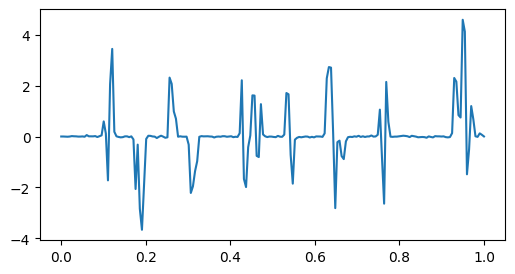

eigenstate: 2, epoch: 800
ev: 1143.3712, norm: 0.9951571, pde: 153808.48, loss: 153993.75, loc_idx: -1, used_loc_idxs: []


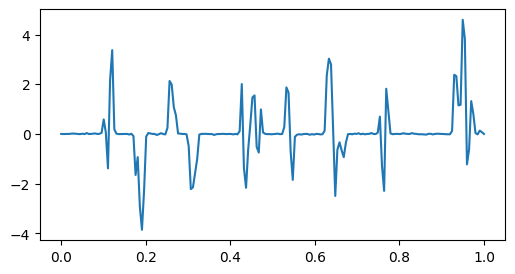

eigenstate: 2, epoch: 900
ev: 1594.5911, norm: 0.9954302, pde: 142252.83, loss: 142417.53, loc_idx: -1, used_loc_idxs: []


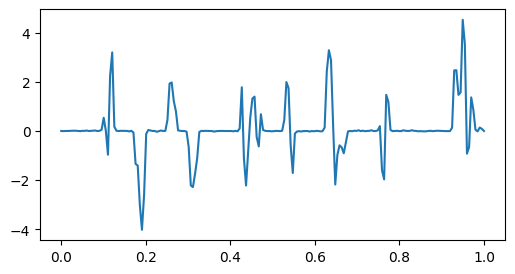

eigenstate: 2, epoch: 1000
ev: 2144.49, norm: 0.9957154, pde: 132677.31, loss: 132822.34, loc_idx: -1, used_loc_idxs: []


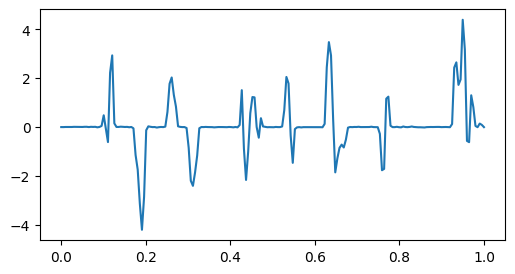

eigenstate: 2, epoch: 1100
ev: 2798.776, norm: 0.99595785, pde: 125326.164, loss: 125455.516, loc_idx: -1, used_loc_idxs: []


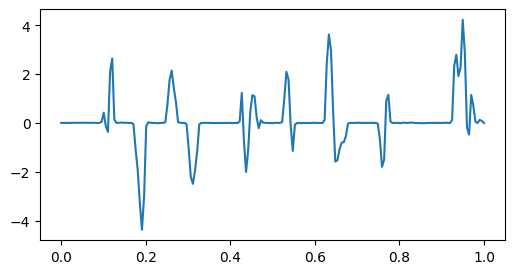

eigenstate: 2, epoch: 1200
ev: 3562.4346, norm: 0.99629515, pde: 119389.97, loss: 119498.38, loc_idx: -1, used_loc_idxs: []


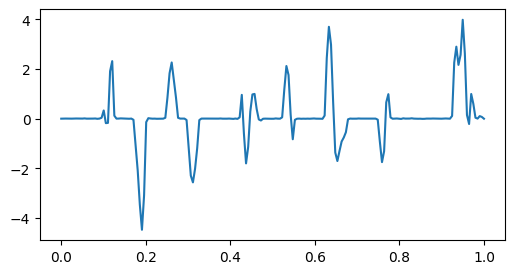

eigenstate: 2, epoch: 1300
ev: 4439.9785, norm: 0.99621624, pde: 114567.3, loss: 114680.26, loc_idx: -1, used_loc_idxs: []


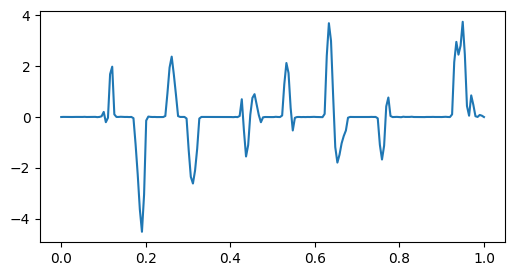

eigenstate: 2, epoch: 1400
ev: 5435.386, norm: 0.9957661, pde: 110636.61, loss: 110777.99, loc_idx: -1, used_loc_idxs: []


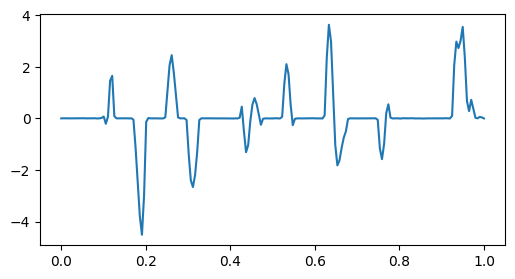

eigenstate: 2, epoch: 1500
ev: 6551.944, norm: 0.9965737, pde: 107499.15, loss: 107591.8, loc_idx: -1, used_loc_idxs: []


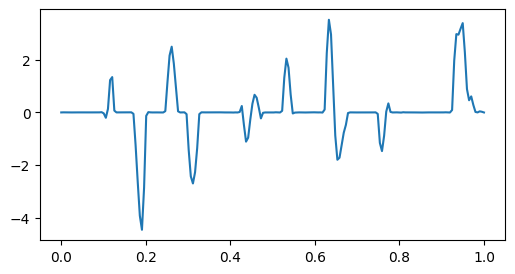

eigenstate: 2, epoch: 1600
ev: 7792.4126, norm: 0.9968848, pde: 104837.5, loss: 104914.09, loc_idx: -1, used_loc_idxs: []


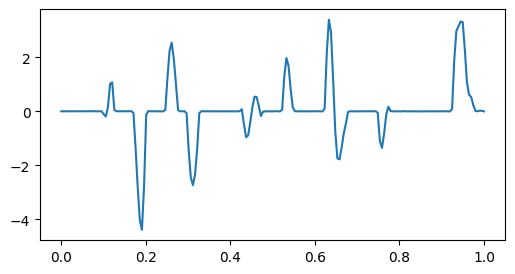

eigenstate: 2, epoch: 1700
ev: 9159.334, norm: 0.9967293, pde: 102458.05, loss: 102542.4, loc_idx: -1, used_loc_idxs: []


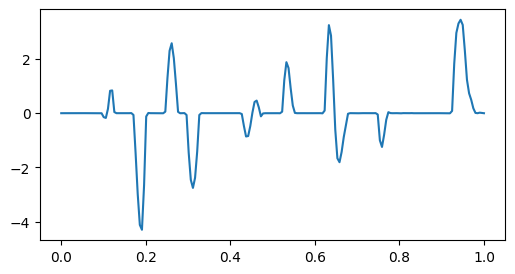

eigenstate: 2, epoch: 1800
ev: 10655.065, norm: 0.9965096, pde: 100244.63, loss: 100340.65, loc_idx: -1, used_loc_idxs: []


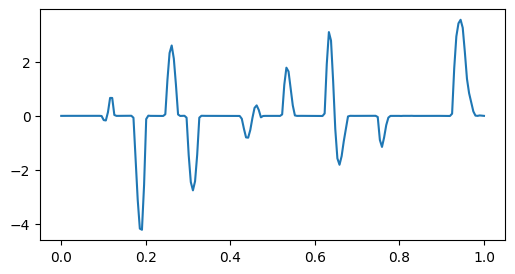

eigenstate: 2, epoch: 1900
ev: 12282.173, norm: 0.9968784, pde: 98111.38, loss: 98188.18, loc_idx: -1, used_loc_idxs: []


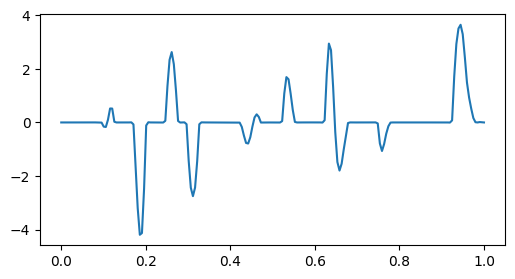

SETTING IDX_GROUPS
idx_groups: [[37, 38], [7], [25, 26], [12], [10], [21], [30]]
eigenstate: 2, epoch: 2000
ev: 14042.963, norm: 0.9967959, pde: 95935.66, loss: 96016.57, loc_idx: 0, used_loc_idxs: []


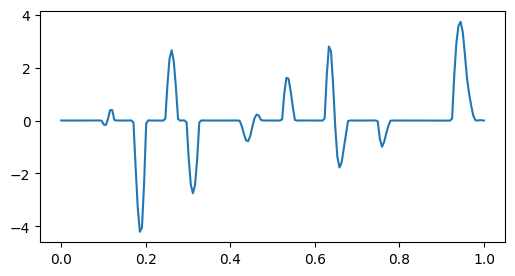

eigenstate: 2, epoch: 2100
ev: 15038.374, norm: 0.96537334, pde: 341823.06, loss: 512128.56, loc_idx: 0, used_loc_idxs: []


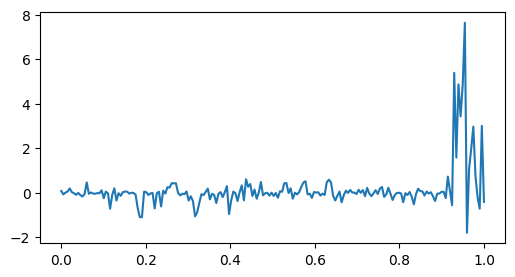

eigenstate: 2, epoch: 2200
ev: 16290.846, norm: 0.9870789, pde: 234988.78, loss: 269726.4, loc_idx: 0, used_loc_idxs: []


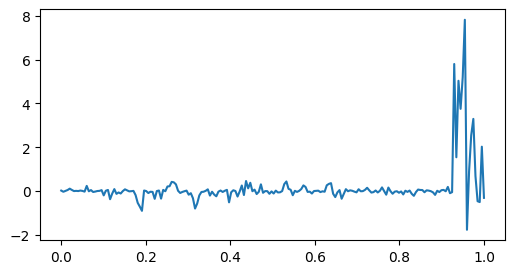

eigenstate: 2, epoch: 2300
ev: 17915.605, norm: 0.99175704, pde: 181288.88, loss: 195695.97, loc_idx: 0, used_loc_idxs: []


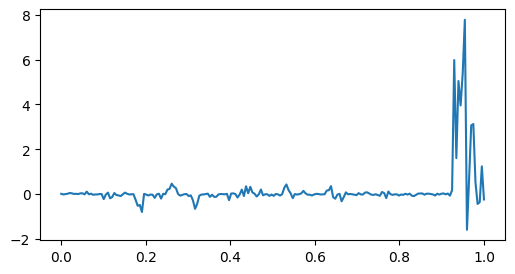

eigenstate: 2, epoch: 2400
ev: 19924.785, norm: 0.99373925, pde: 154846.45, loss: 162163.64, loc_idx: 0, used_loc_idxs: []


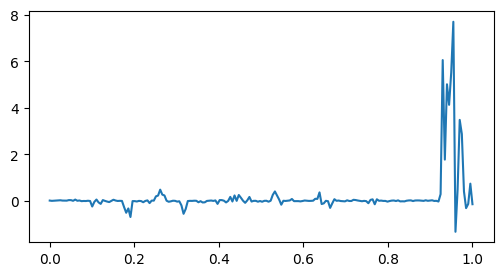

eigenstate: 2, epoch: 2500
ev: 22229.326, norm: 0.994734, pde: 141423.03, loss: 145585.56, loc_idx: 0, used_loc_idxs: []


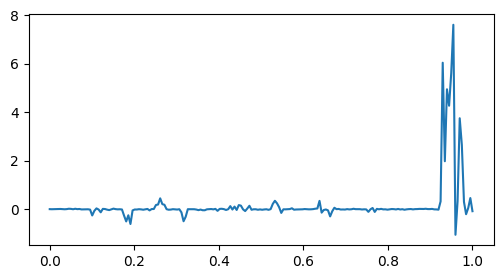

eigenstate: 2, epoch: 2600
ev: 24740.643, norm: 0.99527985, pde: 132781.3, loss: 135445.64, loc_idx: 0, used_loc_idxs: []


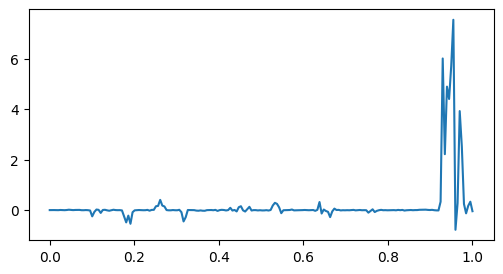

eigenstate: 2, epoch: 2700
ev: 27416.11, norm: 0.99565, pde: 125525.52, loss: 127415.71, loc_idx: 0, used_loc_idxs: []


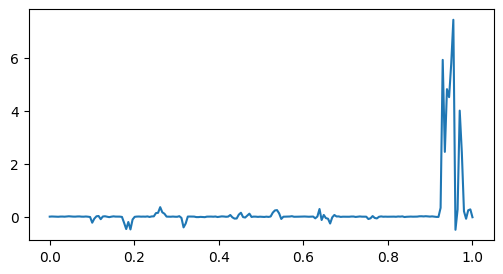

eigenstate: 2, epoch: 2800
ev: 30241.498, norm: 0.9959457, pde: 118595.73, loss: 120038.8, loc_idx: 0, used_loc_idxs: []


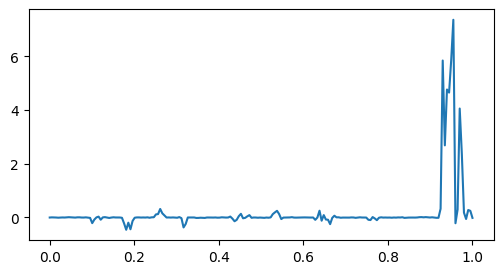

eigenstate: 2, epoch: 2900
ev: 33213.43, norm: 0.99623716, pde: 111609.85, loss: 112739.484, loc_idx: 0, used_loc_idxs: []


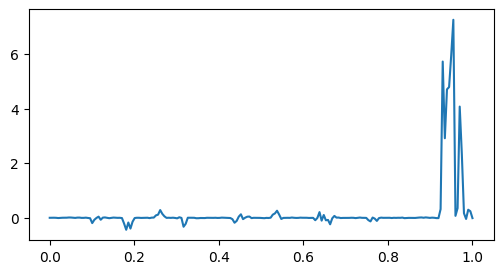

eigenstate: 2, epoch: 3000
ev: 36333.08, norm: 0.99647236, pde: 104475.49, loss: 105397.9, loc_idx: 0, used_loc_idxs: []


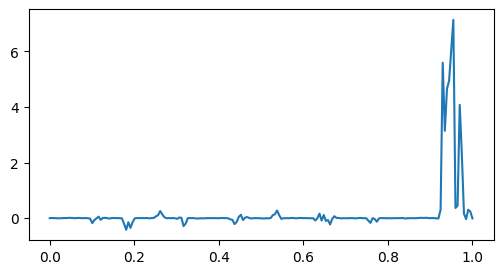

eigenstate: 2, epoch: 3100
ev: 39603.176, norm: 0.99672276, pde: 97240.32, loss: 98010.836, loc_idx: 0, used_loc_idxs: []


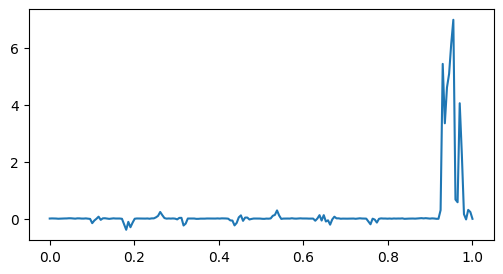

eigenstate: 2, epoch: 3200
ev: 43026.996, norm: 0.9969743, pde: 89893.58, loss: 90544.234, loc_idx: 0, used_loc_idxs: []


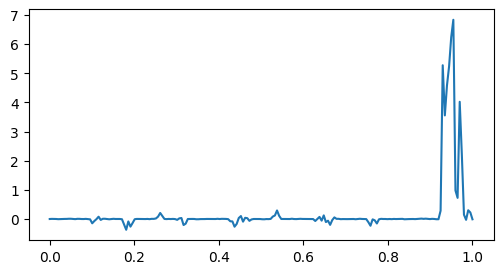

eigenstate: 2, epoch: 3300
ev: 46608.582, norm: 0.9972223, pde: 82442.13, loss: 82995.35, loc_idx: 0, used_loc_idxs: []


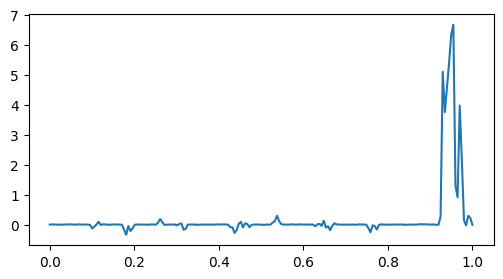

eigenstate: 2, epoch: 3400
ev: 50353.062, norm: 0.99746835, pde: 74833.73, loss: 75322.89, loc_idx: 0, used_loc_idxs: []


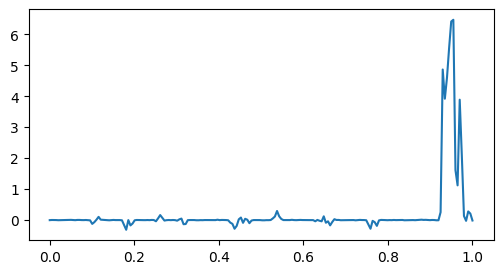

eigenstate: 2, epoch: 3500
ev: 54266.41, norm: 0.9977337, pde: 67250.94, loss: 67660.08, loc_idx: 0, used_loc_idxs: []


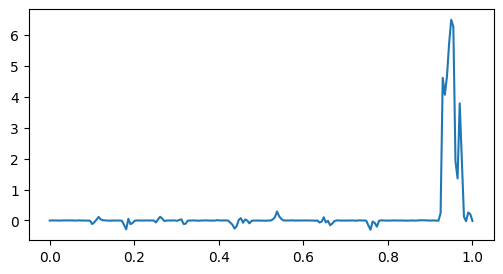

eigenstate: 2, epoch: 3600
ev: 58355.457, norm: 0.997977, pde: 59617.08, loss: 59984.617, loc_idx: 0, used_loc_idxs: []


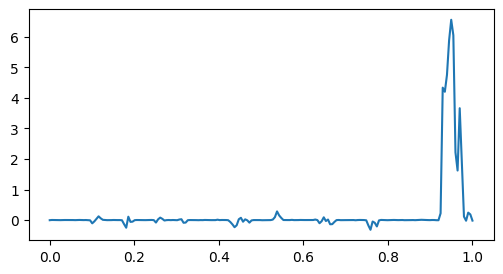

eigenstate: 2, epoch: 3700
ev: 62632.12, norm: 0.99823475, pde: 51987.32, loss: 52325.496, loc_idx: 0, used_loc_idxs: []


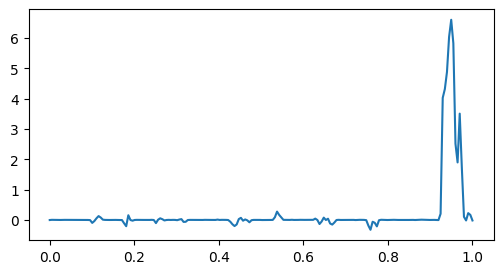

eigenstate: 2, epoch: 3800
ev: 67109.94, norm: 0.99849427, pde: 44552.83, loss: 44842.64, loc_idx: 0, used_loc_idxs: []


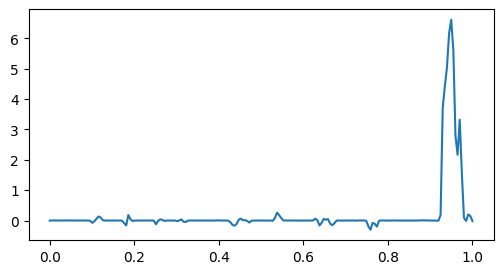

eigenstate: 2, epoch: 3900
ev: 71797.29, norm: 0.9987982, pde: 37456.266, loss: 37695.023, loc_idx: 0, used_loc_idxs: []


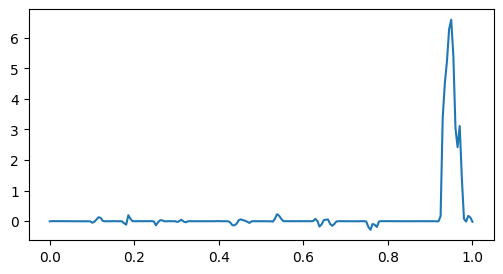

eigenstate: 2, epoch: 4000
ev: 76695.5, norm: 0.9993524, pde: 31120.615, loss: 31309.477, loc_idx: 0, used_loc_idxs: []


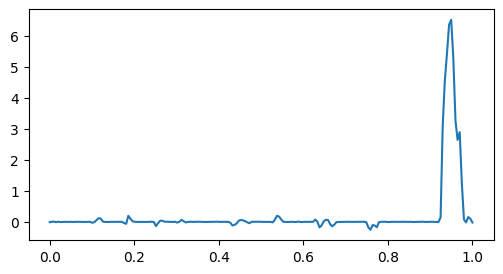

eigenstate: 2, epoch: 4100
ev: 81775.8, norm: 0.99929047, pde: 24608.434, loss: 24737.871, loc_idx: 0, used_loc_idxs: []


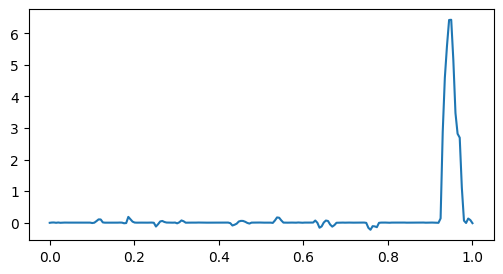

eigenstate: 2, epoch: 4200
ev: 86976.64, norm: 0.9994163, pde: 18644.92, loss: 18727.453, loc_idx: 0, used_loc_idxs: []


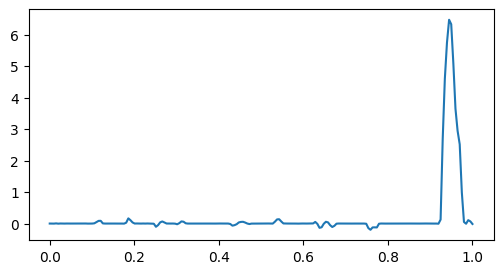

eigenstate: 2, epoch: 4300
ev: 92100.7, norm: 0.99935794, pde: 14665.043, loss: 14722.444, loc_idx: 0, used_loc_idxs: []


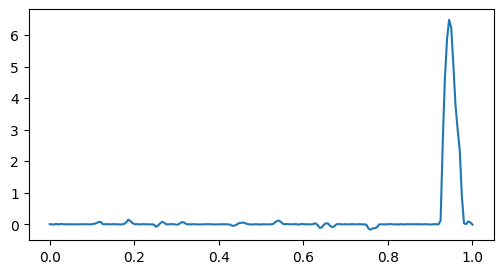

eigenstate: 2, epoch: 4400
ev: 96812.08, norm: 0.99951816, pde: 10789.202, loss: 10831.258, loc_idx: 0, used_loc_idxs: []


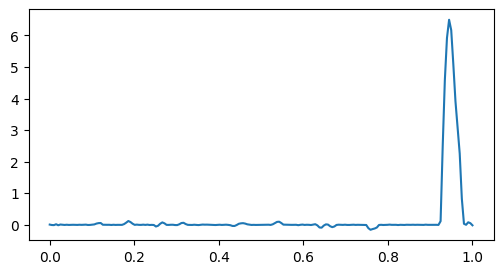

eigenstate: 2, epoch: 4500
ev: 100510.15, norm: 0.9996579, pde: 8359.795, loss: 8392.051, loc_idx: 0, used_loc_idxs: []


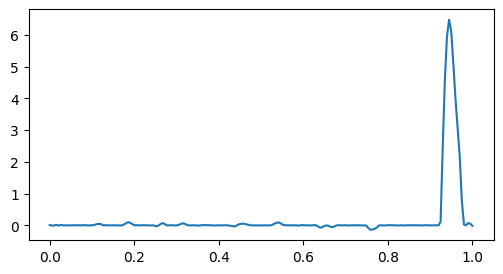

eigenstate: 2, epoch: 4600
ev: 102713.04, norm: 0.9995904, pde: 6736.357, loss: 6767.9785, loc_idx: 0, used_loc_idxs: []


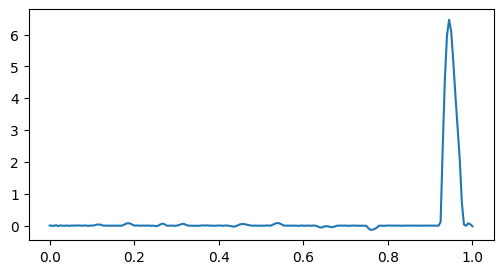

eigenstate: 2, epoch: 4700
ev: 103627.09, norm: 0.9998505, pde: 5966.4575, loss: 5988.1567, loc_idx: 0, used_loc_idxs: []


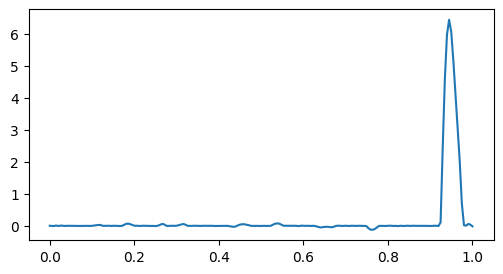

eigenstate: 2, epoch: 4800
ev: 103885.92, norm: 0.99992025, pde: 5472.511, loss: 5492.1123, loc_idx: 0, used_loc_idxs: []


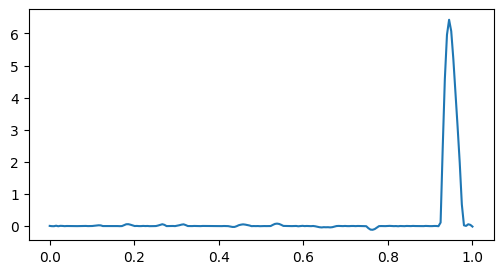

eigenstate: 2, epoch: 4900
ev: 103932.16, norm: 0.999868, pde: 5129.1436, loss: 5146.1646, loc_idx: 0, used_loc_idxs: []


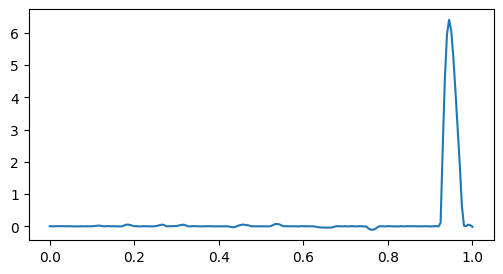

eigenstate: 2, epoch: 5000
ev: 103932.055, norm: 1.0000112, pde: 4849.729, loss: 4864.987, loc_idx: 0, used_loc_idxs: []


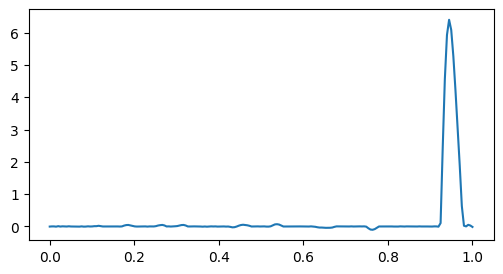

eigenstate: 2, epoch: 5100
ev: 103925.11, norm: 1.0000772, pde: 4703.78, loss: 4716.507, loc_idx: 0, used_loc_idxs: []


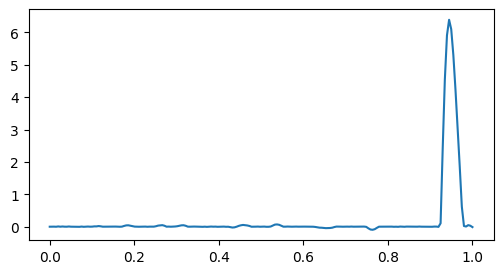

eigenstate: 2, epoch: 5200
ev: 103918.04, norm: 1.0000999, pde: 4604.4985, loss: 4618.769, loc_idx: 0, used_loc_idxs: []


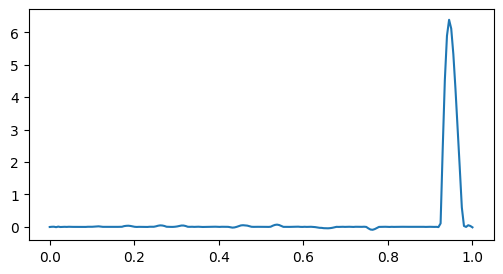

eigenstate: 2, epoch: 5300
ev: 103912.31, norm: 0.9998493, pde: 4524.28, loss: 4542.725, loc_idx: 0, used_loc_idxs: []


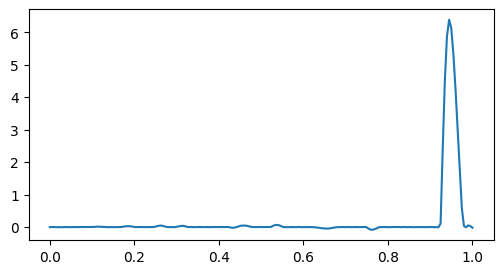

eigenstate: 2, epoch: 5400
ev: 103905.56, norm: 0.999813, pde: 4351.31, loss: 4368.805, loc_idx: 0, used_loc_idxs: []


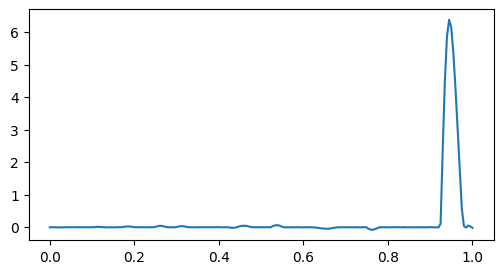

eigenstate: 2, epoch: 5500
ev: 103899.9, norm: 0.999759, pde: 4259.174, loss: 4276.627, loc_idx: 0, used_loc_idxs: []


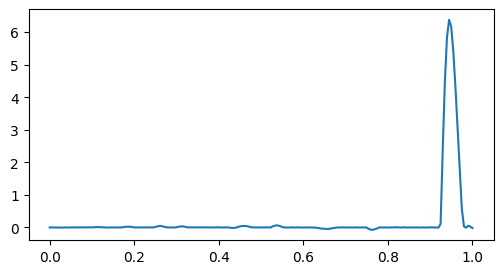

eigenstate: 2, epoch: 5600
ev: 103895.54, norm: 1.0001845, pde: 4215.7607, loss: 4225.259, loc_idx: 0, used_loc_idxs: []


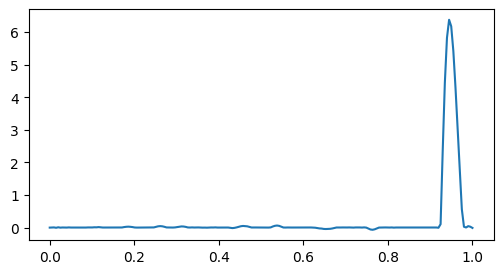

eigenstate: 2, epoch: 5700
ev: 103890.414, norm: 0.9999105, pde: 4187.9746, loss: 4199.692, loc_idx: 0, used_loc_idxs: []


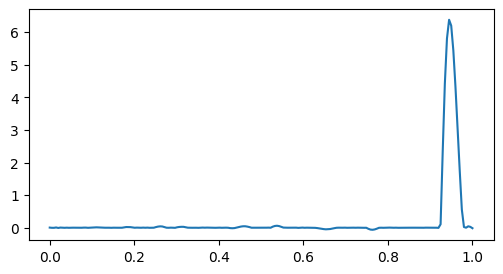

eigenstate: 2, epoch: 5800
ev: 103885.9, norm: 1.0000274, pde: 4134.477, loss: 4143.874, loc_idx: 0, used_loc_idxs: []


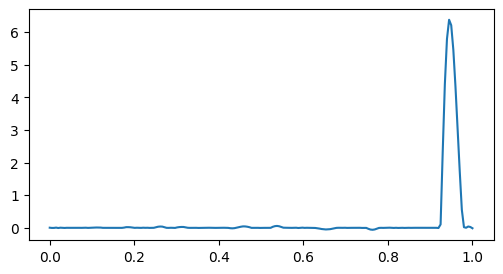

eigenstate: 2, epoch: 5900
ev: 103881.79, norm: 1.0000683, pde: 4093.36, loss: 4102.681, loc_idx: 0, used_loc_idxs: []


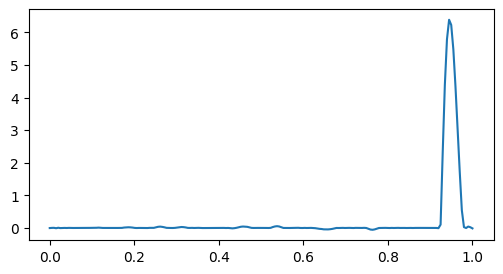

eigenstate: 2, epoch: 6000
ev: 103878.0, norm: 0.9999432, pde: 4049.2139, loss: 4060.462, loc_idx: 0, used_loc_idxs: []


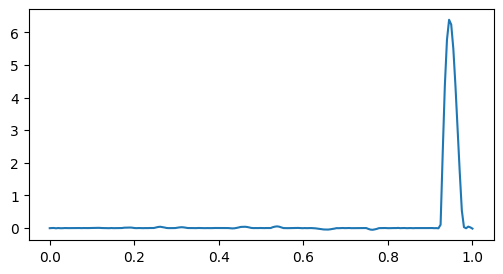

eigenstate: 2, epoch: 6100
ev: 103874.37, norm: 0.99990666, pde: 4030.7864, loss: 4039.36, loc_idx: 0, used_loc_idxs: []


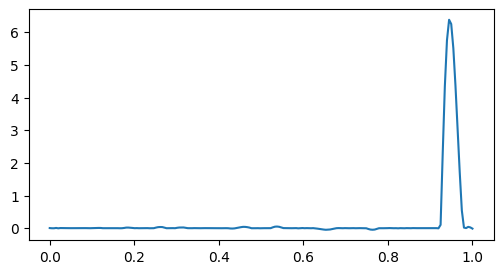

eigenstate: 2, epoch: 6200
ev: 103870.88, norm: 1.0001291, pde: 3942.1445, loss: 3950.5583, loc_idx: 0, used_loc_idxs: []


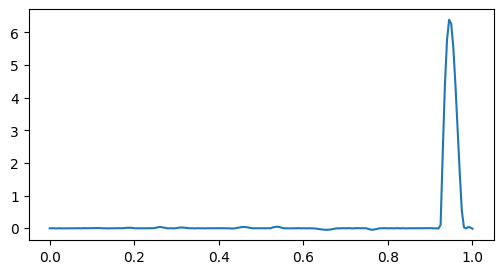

eigenstate: 2, epoch: 6300
ev: 103867.28, norm: 1.0000504, pde: 3880.6804, loss: 3889.2935, loc_idx: 0, used_loc_idxs: []


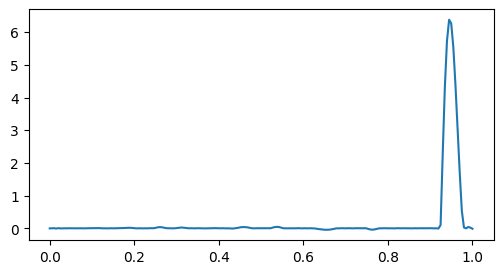

eigenstate: 2, epoch: 6400
ev: 103864.09, norm: 0.9998727, pde: 3855.5332, loss: 3866.917, loc_idx: 0, used_loc_idxs: []


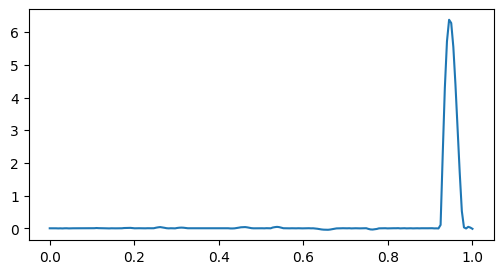

eigenstate: 2, epoch: 6500
ev: 103860.71, norm: 0.99974906, pde: 3831.3516, loss: 3843.2986, loc_idx: 0, used_loc_idxs: []


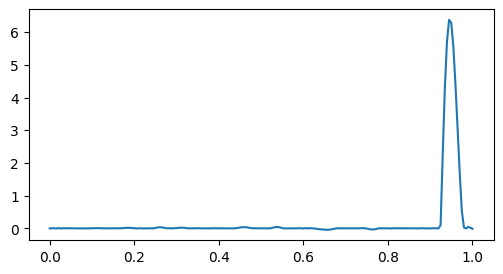

eigenstate: 2, epoch: 6600
ev: 103857.94, norm: 0.99978817, pde: 3810.2288, loss: 3822.9126, loc_idx: 0, used_loc_idxs: []


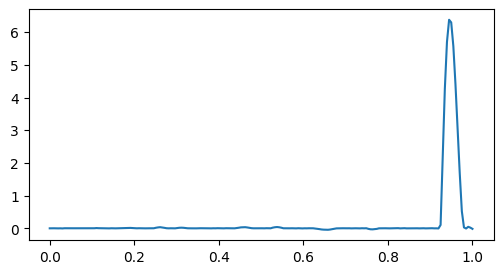

eigenstate: 2, epoch: 6700
ev: 103855.54, norm: 1.0001187, pde: 3778.835, loss: 3783.8303, loc_idx: 0, used_loc_idxs: []


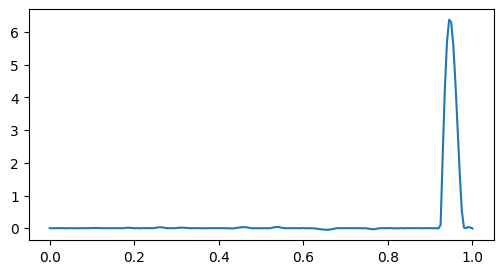

eigenstate: 2, epoch: 6800
ev: 103852.516, norm: 1.0000412, pde: 3794.4912, loss: 3802.5322, loc_idx: 0, used_loc_idxs: []


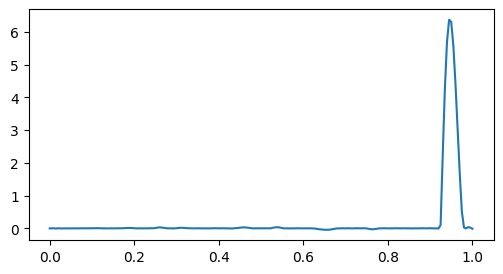

eigenstate: 2, epoch: 6900
ev: 103850.37, norm: 0.9999446, pde: 3800.3452, loss: 3809.5984, loc_idx: 0, used_loc_idxs: []


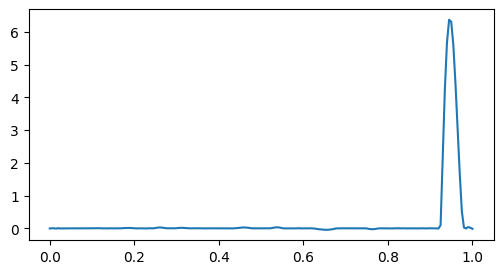

eigenstate: 2, epoch: 7000
ev: 103847.69, norm: 1.0000044, pde: 3776.2664, loss: 3784.7922, loc_idx: 0, used_loc_idxs: []


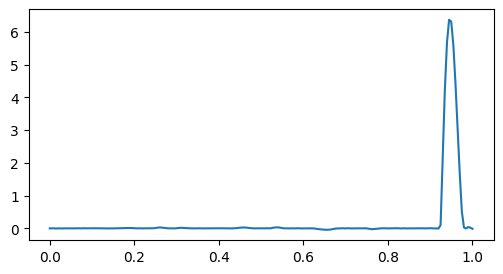

eigenstate: 2, epoch: 7100
ev: 103845.13, norm: 0.9997858, pde: 3780.4695, loss: 3788.8152, loc_idx: 0, used_loc_idxs: []


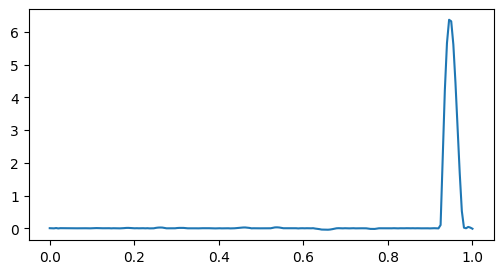

eigenstate: 2, epoch: 7200
ev: 103842.87, norm: 0.9998559, pde: 3774.0828, loss: 3781.1528, loc_idx: 0, used_loc_idxs: []


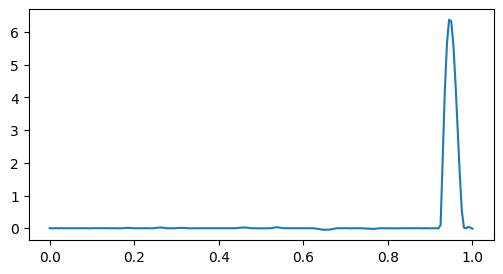

eigenstate: 2, epoch: 7300
ev: 103841.4, norm: 0.9999109, pde: 3787.6687, loss: 3797.344, loc_idx: 0, used_loc_idxs: []


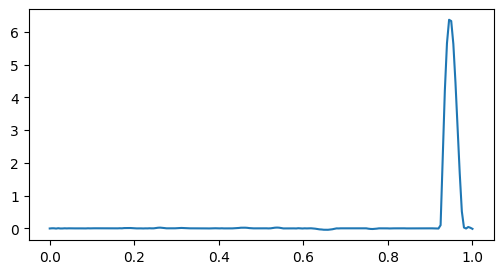

eigenstate: 2, epoch: 7400
ev: 103838.93, norm: 0.9998863, pde: 3776.8564, loss: 3785.5088, loc_idx: 0, used_loc_idxs: []


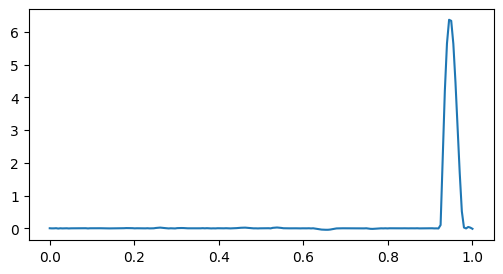

eigenstate: 2, epoch: 7500
ev: 103836.375, norm: 1.0000105, pde: 3743.4292, loss: 3750.0999, loc_idx: 0, used_loc_idxs: []


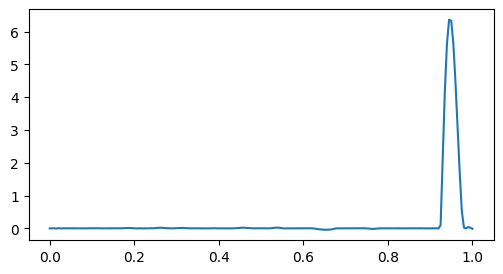

eigenstate: 2, epoch: 7600
ev: 103834.75, norm: 1.000047, pde: 3740.2742, loss: 3747.144, loc_idx: 0, used_loc_idxs: []


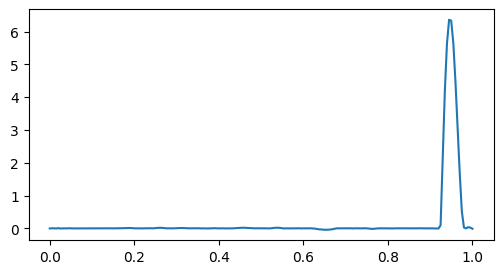

eigenstate: 2, epoch: 7700
ev: 103832.06, norm: 0.9998833, pde: 3727.8225, loss: 3737.2646, loc_idx: 0, used_loc_idxs: []


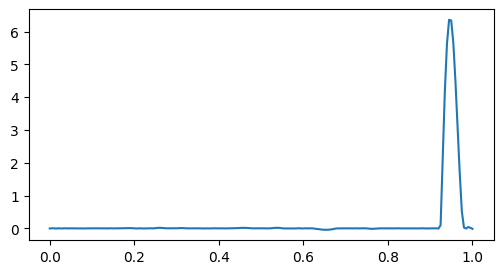

eigenstate: 2, epoch: 7800
ev: 103830.42, norm: 0.9999399, pde: 3733.025, loss: 3739.9104, loc_idx: 0, used_loc_idxs: []


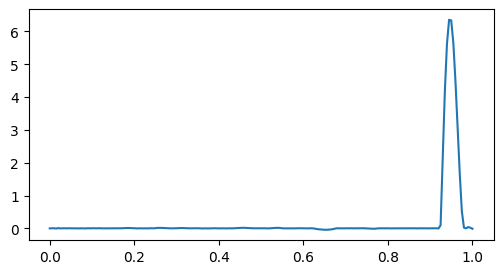

eigenstate: 2, epoch: 7900
ev: 103828.516, norm: 0.9998628, pde: 3718.382, loss: 3728.8545, loc_idx: 0, used_loc_idxs: []


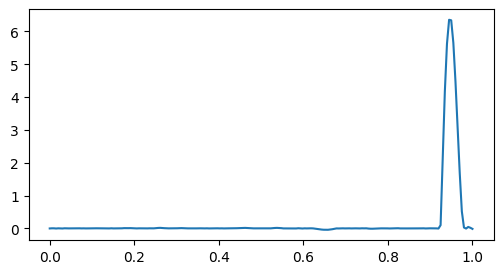

eigenstate: 2, epoch: 8000
ev: 103826.77, norm: 0.9998871, pde: 3711.059, loss: 3716.8147, loc_idx: 0, used_loc_idxs: []


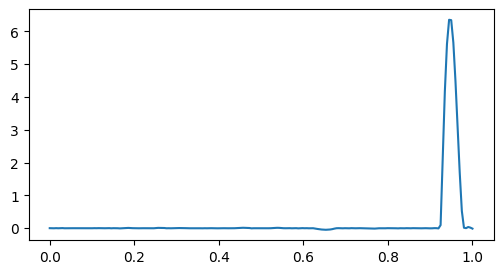

eigenstate: 2, epoch: 8100
ev: 103824.85, norm: 0.99973595, pde: 3717.3015, loss: 3726.4487, loc_idx: 0, used_loc_idxs: []


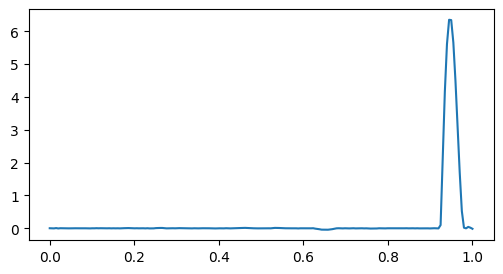

eigenstate: 2, epoch: 8200
ev: 103823.09, norm: 0.999991, pde: 3715.6108, loss: 3720.8613, loc_idx: 0, used_loc_idxs: []


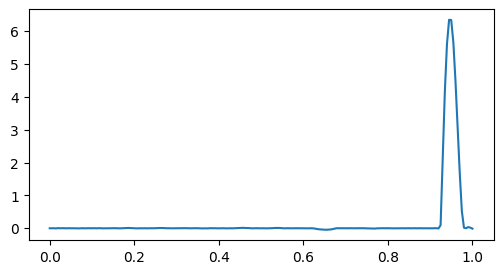

eigenstate: 2, epoch: 8300
ev: 103821.7, norm: 0.99985, pde: 3701.2231, loss: 3708.7625, loc_idx: 0, used_loc_idxs: []


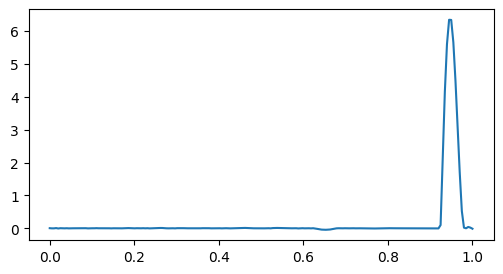

eigenstate: 2, epoch: 8400
ev: 103820.43, norm: 0.9998773, pde: 3702.2058, loss: 3708.5864, loc_idx: 0, used_loc_idxs: []


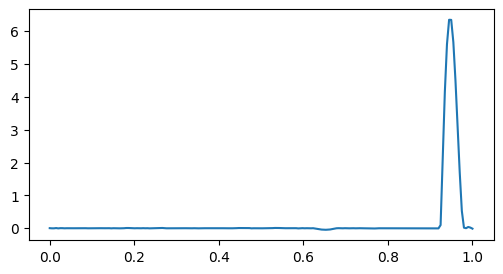

eigenstate: 2, epoch: 8500
ev: 103818.35, norm: 0.9998139, pde: 3674.6016, loss: 3682.34, loc_idx: 0, used_loc_idxs: []


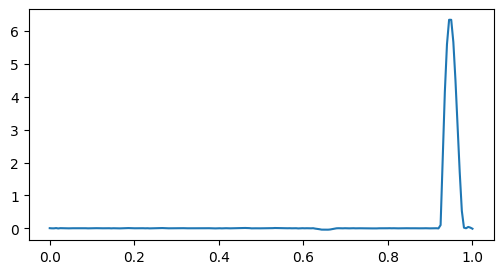

eigenstate: 2, epoch: 8600
ev: 103816.99, norm: 0.9998088, pde: 3667.5593, loss: 3675.0735, loc_idx: 0, used_loc_idxs: []


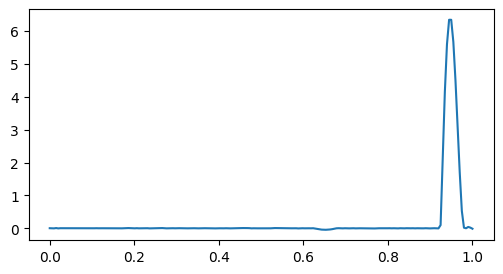

eigenstate: 2, epoch: 8700
ev: 103815.61, norm: 0.99977976, pde: 3660.856, loss: 3669.1262, loc_idx: 0, used_loc_idxs: []


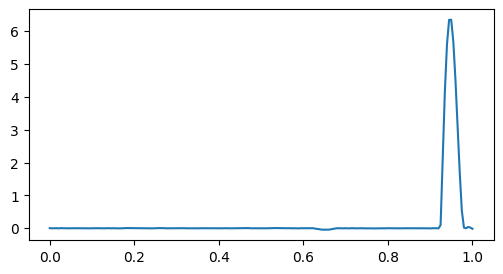

eigenstate: 2, epoch: 8800
ev: 103814.555, norm: 0.9998996, pde: 3666.7615, loss: 3675.2124, loc_idx: 0, used_loc_idxs: []


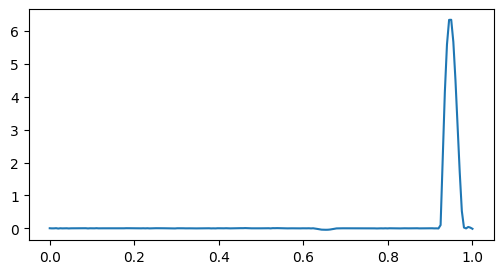

eigenstate: 2, epoch: 8900
ev: 103814.27, norm: 0.9997036, pde: 3654.4236, loss: 3665.5227, loc_idx: 0, used_loc_idxs: []


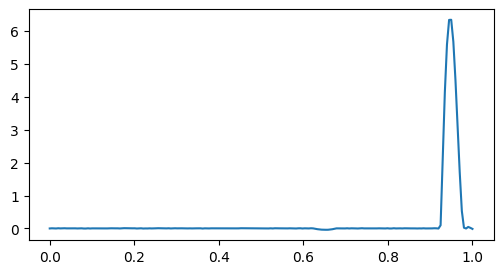

OUT OF EPOCHS
eigenstate: 3, epoch: 0
ev: 0.01450311, norm: 0.23231363, pde: 508797.4, loss: 5165182.5, loc_idx: -1, used_loc_idxs: []


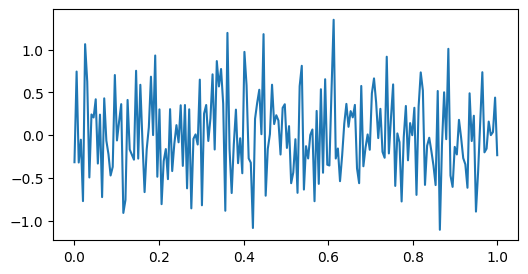

eigenstate: 3, epoch: 100
ev: 3.1618578, norm: 0.98182994, pde: 681473.06, loss: 684443.5, loc_idx: -1, used_loc_idxs: []


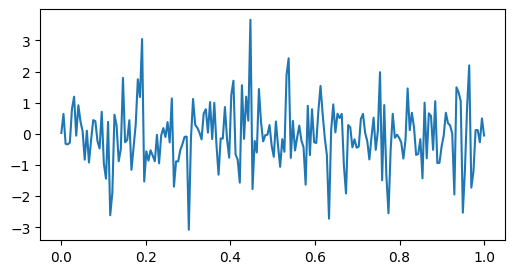

eigenstate: 3, epoch: 200
ev: 18.457853, norm: 0.98928964, pde: 345691.1, loss: 347529.72, loc_idx: -1, used_loc_idxs: []


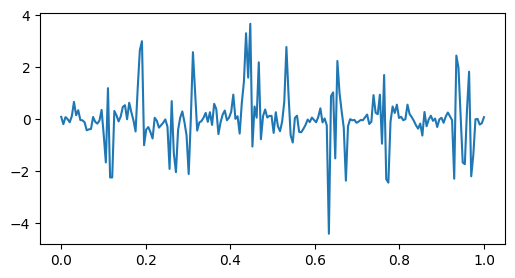

eigenstate: 3, epoch: 300
ev: 63.913624, norm: 0.99305636, pde: 216473.12, loss: 216956.08, loc_idx: -1, used_loc_idxs: []


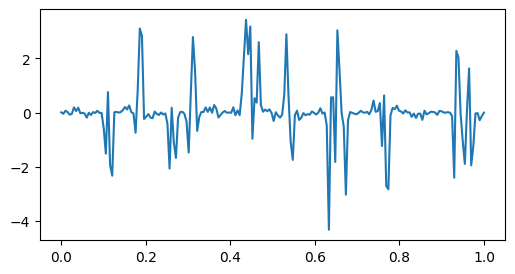

eigenstate: 3, epoch: 400
ev: 158.66891, norm: 0.99347925, pde: 174234.22, loss: 174611.16, loc_idx: -1, used_loc_idxs: []


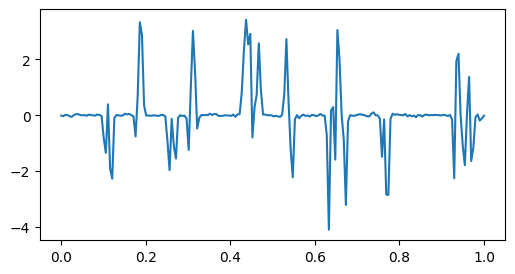

eigenstate: 3, epoch: 500
ev: 311.2613, norm: 0.99497867, pde: 157941.44, loss: 158151.25, loc_idx: -1, used_loc_idxs: []


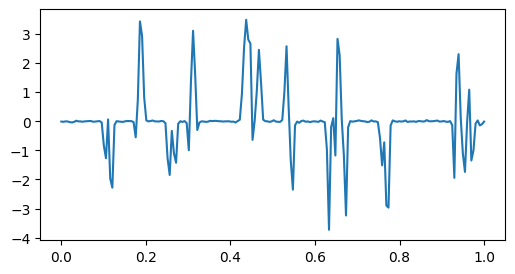

eigenstate: 3, epoch: 600
ev: 530.25256, norm: 0.99500644, pde: 145595.94, loss: 145799.69, loc_idx: -1, used_loc_idxs: []


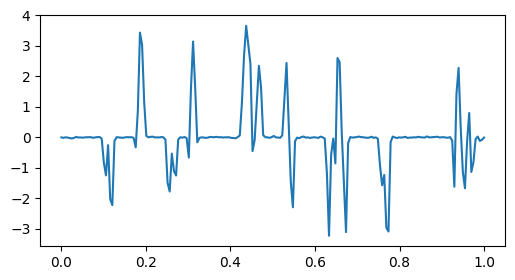

eigenstate: 3, epoch: 700
ev: 826.1203, norm: 0.99589497, pde: 135093.98, loss: 135232.23, loc_idx: -1, used_loc_idxs: []


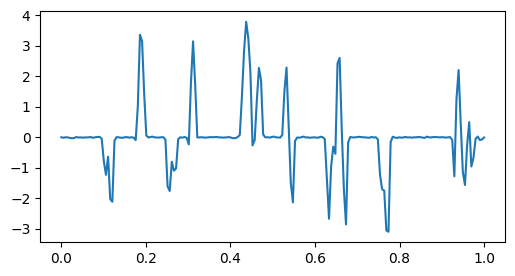

eigenstate: 3, epoch: 800
ev: 1208.557, norm: 0.99491364, pde: 126603.46, loss: 126809.48, loc_idx: -1, used_loc_idxs: []


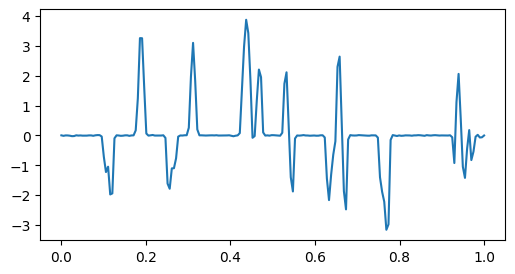

eigenstate: 3, epoch: 900
ev: 1685.0836, norm: 0.9963174, pde: 120971.305, loss: 121080.75, loc_idx: -1, used_loc_idxs: []


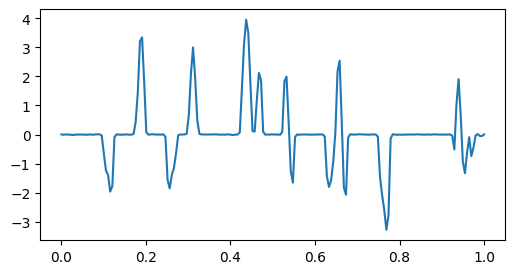

eigenstate: 3, epoch: 1000
ev: 2261.3765, norm: 0.9962721, pde: 116998.81, loss: 117109.375, loc_idx: -1, used_loc_idxs: []


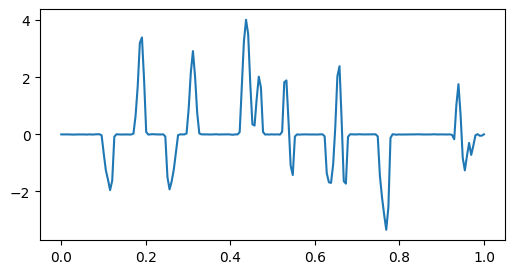

eigenstate: 3, epoch: 1100
ev: 2942.7642, norm: 0.9963741, pde: 113689.195, loss: 113793.836, loc_idx: -1, used_loc_idxs: []


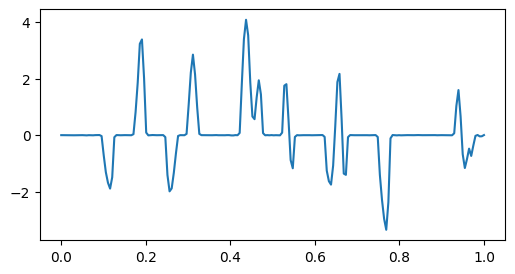

eigenstate: 3, epoch: 1200
ev: 3734.5286, norm: 0.9946862, pde: 110562.28, loss: 110785.234, loc_idx: -1, used_loc_idxs: []


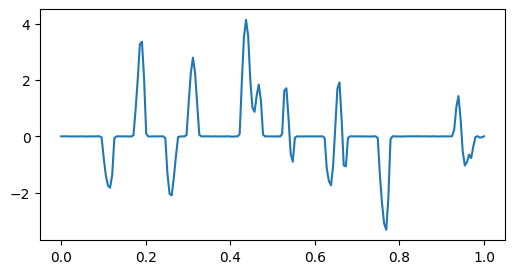

eigenstate: 3, epoch: 1300
ev: 4641.6714, norm: 0.9962712, pde: 107780.03, loss: 107890.06, loc_idx: -1, used_loc_idxs: []


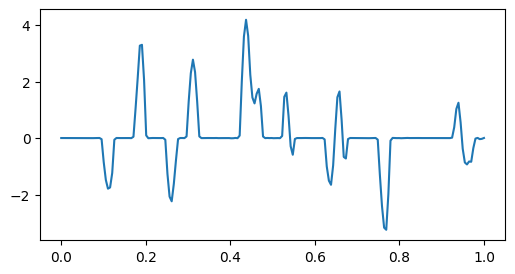

eigenstate: 3, epoch: 1400
ev: 5668.78, norm: 0.99856323, pde: 105313.44, loss: 105330.33, loc_idx: -1, used_loc_idxs: []


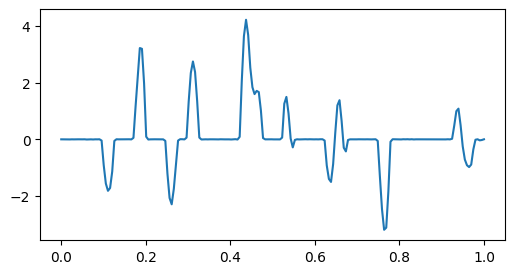

eigenstate: 3, epoch: 1500
ev: 6819.755, norm: 0.9966903, pde: 102846.43, loss: 102933.016, loc_idx: -1, used_loc_idxs: []


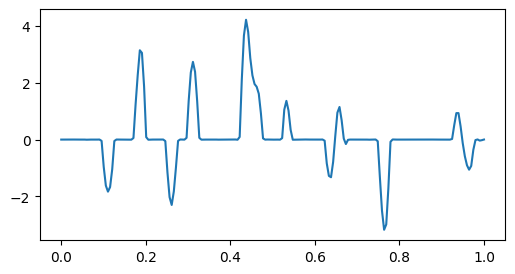

eigenstate: 3, epoch: 1600
ev: 8098.057, norm: 0.99716985, pde: 100715.55, loss: 100778.86, loc_idx: -1, used_loc_idxs: []


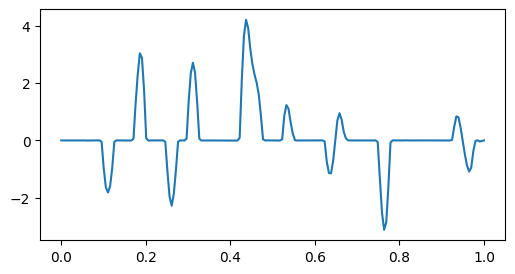

eigenstate: 3, epoch: 1700
ev: 9506.887, norm: 0.99521357, pde: 98591.555, loss: 98772.484, loc_idx: -1, used_loc_idxs: []


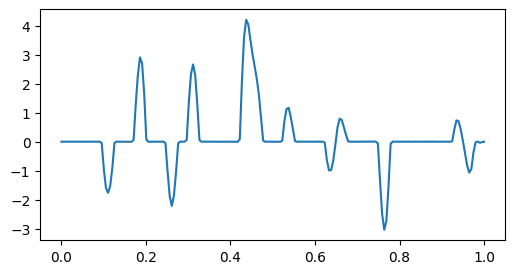

eigenstate: 3, epoch: 1800
ev: 11049.179, norm: 0.9965872, pde: 96646.305, loss: 96738.195, loc_idx: -1, used_loc_idxs: []


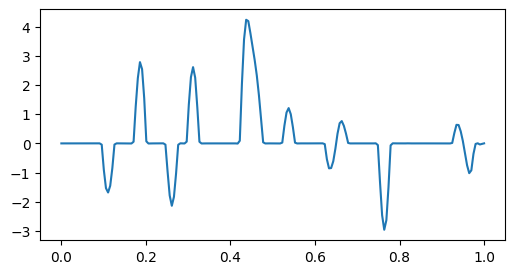

eigenstate: 3, epoch: 1900
ev: 12727.797, norm: 0.9986482, pde: 94662.41, loss: 94677.27, loc_idx: -1, used_loc_idxs: []


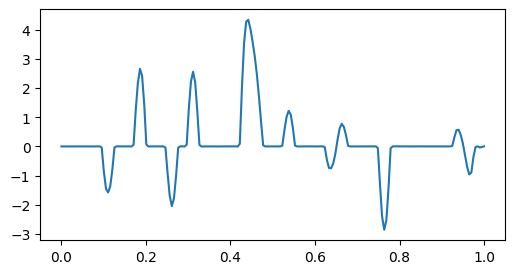

SETTING IDX_GROUPS
idx_groups: [[17, 18], [30], [7], [12], [10], [4], [21], [38]]
eigenstate: 3, epoch: 2000
ev: 14545.518, norm: 0.9969681, pde: 92374.61, loss: 92447.164, loc_idx: 0, used_loc_idxs: []


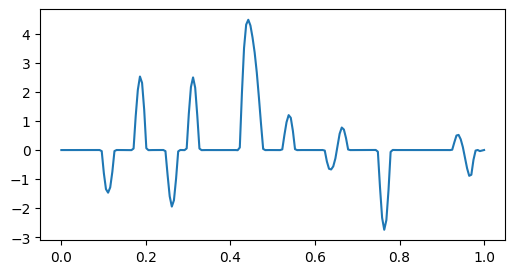

eigenstate: 3, epoch: 2100
ev: 15974.148, norm: 0.995128, pde: 95814.91, loss: 105948.46, loc_idx: 0, used_loc_idxs: []


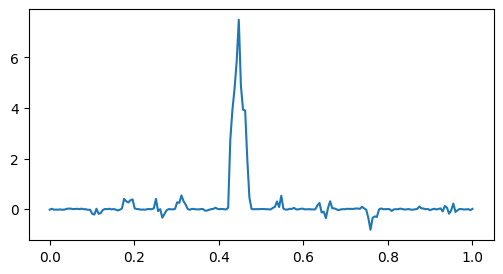

eigenstate: 3, epoch: 2200
ev: 18052.281, norm: 0.996799, pde: 89858.55, loss: 91891.305, loc_idx: 0, used_loc_idxs: []


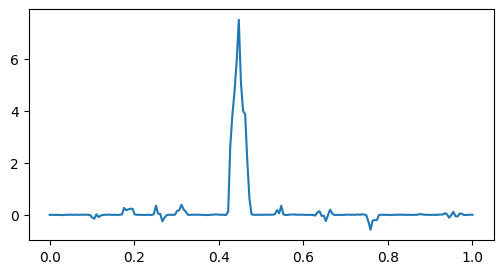

eigenstate: 3, epoch: 2300
ev: 20305.758, norm: 0.9971017, pde: 86262.37, loss: 87164.77, loc_idx: 0, used_loc_idxs: []


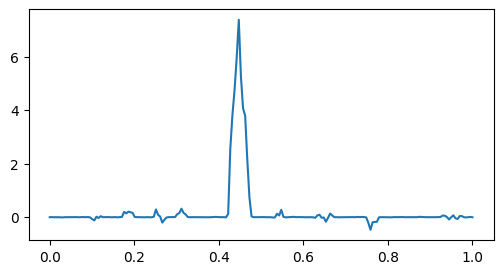

eigenstate: 3, epoch: 2400
ev: 22717.201, norm: 0.99727124, pde: 82915.695, loss: 83457.02, loc_idx: 0, used_loc_idxs: []


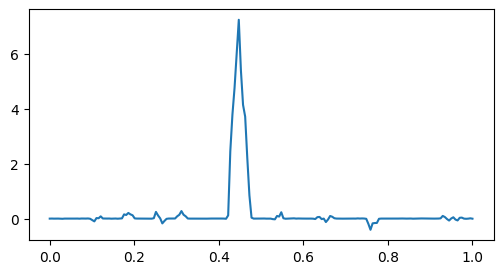

eigenstate: 3, epoch: 2500
ev: 25285.35, norm: 0.9974037, pde: 79682.17, loss: 80056.16, loc_idx: 0, used_loc_idxs: []


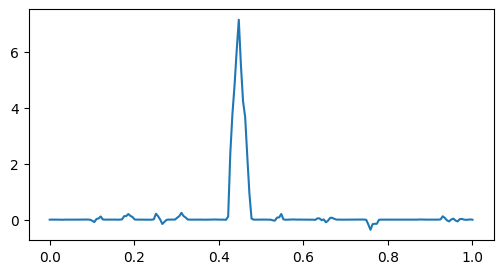

eigenstate: 3, epoch: 2600
ev: 28009.969, norm: 0.9975225, pde: 76486.92, loss: 76764.336, loc_idx: 0, used_loc_idxs: []


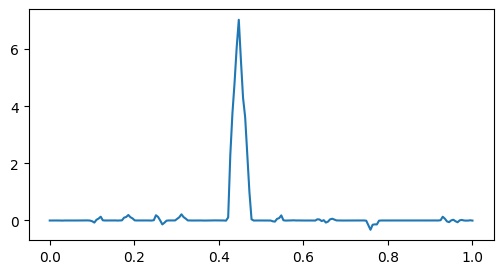

eigenstate: 3, epoch: 2700
ev: 30891.314, norm: 0.9976365, pde: 73275.12, loss: 73488.76, loc_idx: 0, used_loc_idxs: []


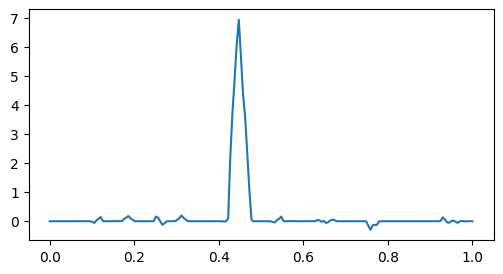

eigenstate: 3, epoch: 2800
ev: 33929.996, norm: 0.99774826, pde: 70005.81, loss: 70173.945, loc_idx: 0, used_loc_idxs: []


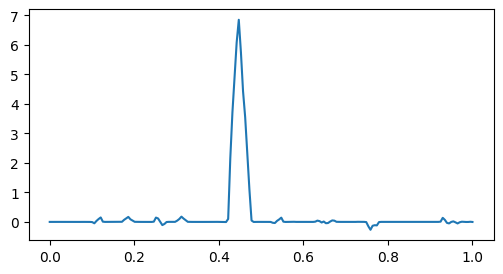

eigenstate: 3, epoch: 2900
ev: 37126.992, norm: 0.9978611, pde: 66648.6, loss: 66782.625, loc_idx: 0, used_loc_idxs: []


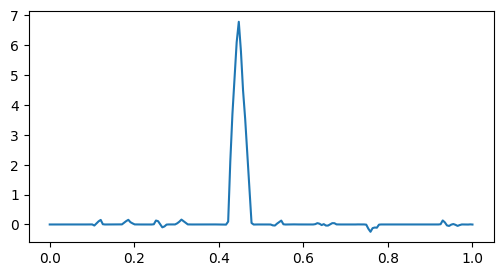

eigenstate: 3, epoch: 3000
ev: 40483.445, norm: 0.99797595, pde: 63181.164, loss: 63288.934, loc_idx: 0, used_loc_idxs: []


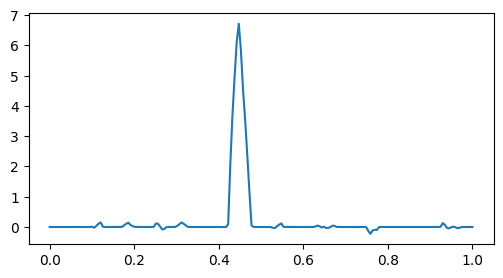

eigenstate: 3, epoch: 3100
ev: 44000.71, norm: 0.9980936, pde: 59587.137, loss: 59674.305, loc_idx: 0, used_loc_idxs: []


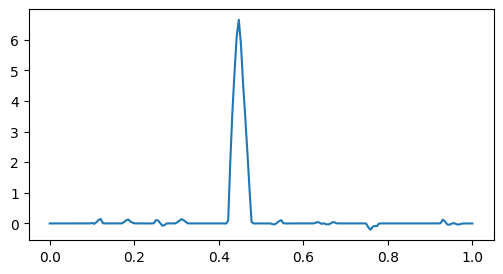

eigenstate: 3, epoch: 3200
ev: 47680.297, norm: 0.99821484, pde: 55854.566, loss: 55925.336, loc_idx: 0, used_loc_idxs: []


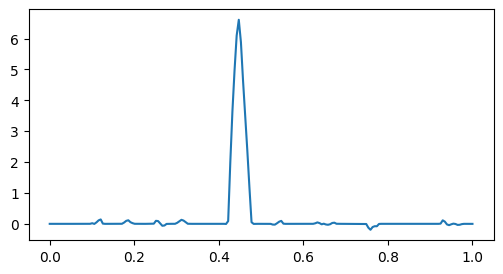

eigenstate: 3, epoch: 3300
ev: 51523.8, norm: 0.9983401, pde: 51974.695, loss: 52032.266, loc_idx: 0, used_loc_idxs: []


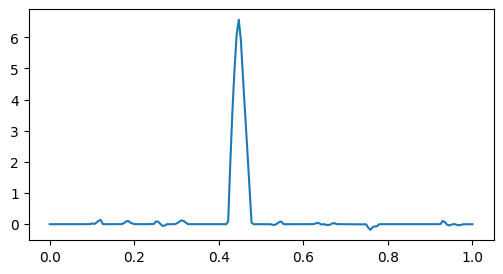

eigenstate: 3, epoch: 3400
ev: 55532.855, norm: 0.9984699, pde: 47941.062, loss: 47987.88, loc_idx: 0, used_loc_idxs: []


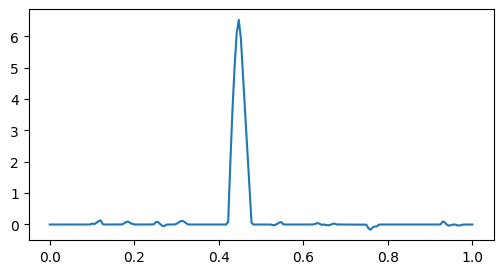

eigenstate: 3, epoch: 3500
ev: 59709.137, norm: 0.9986044, pde: 43748.746, loss: 43786.707, loc_idx: 0, used_loc_idxs: []


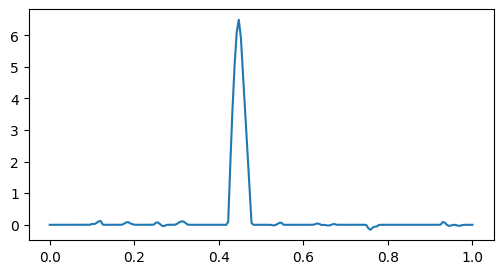

eigenstate: 3, epoch: 3600
ev: 64054.285, norm: 0.9987439, pde: 39393.953, loss: 39424.562, loc_idx: 0, used_loc_idxs: []


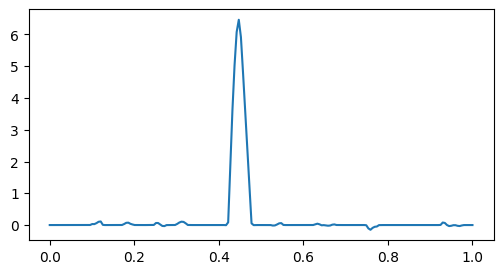

eigenstate: 3, epoch: 3700
ev: 68569.91, norm: 0.9988882, pde: 34873.688, loss: 34898.164, loc_idx: 0, used_loc_idxs: []


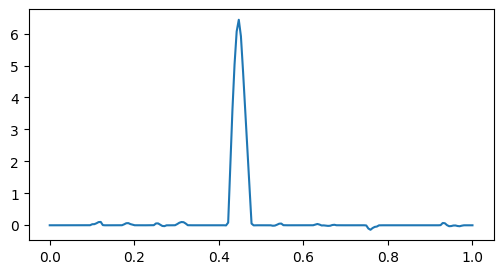

eigenstate: 3, epoch: 3800
ev: 73257.48, norm: 0.9990382, pde: 30185.615, loss: 30204.963, loc_idx: 0, used_loc_idxs: []


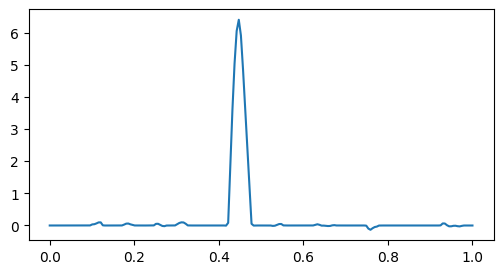

eigenstate: 3, epoch: 3900
ev: 78114.58, norm: 0.9992242, pde: 25336.137, loss: 25350.926, loc_idx: 0, used_loc_idxs: []


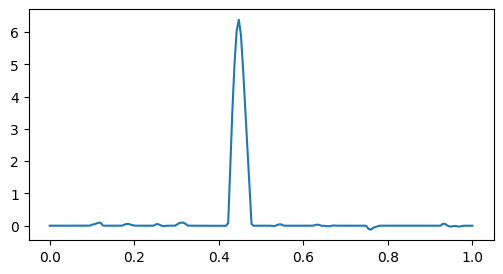

eigenstate: 3, epoch: 4000
ev: 83119.62, norm: 0.9992096, pde: 20468.75, loss: 20483.102, loc_idx: 0, used_loc_idxs: []


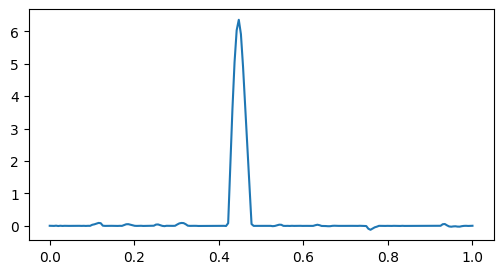

eigenstate: 3, epoch: 4100
ev: 88210.65, norm: 0.9995343, pde: 15852.176, loss: 15862.012, loc_idx: 0, used_loc_idxs: []


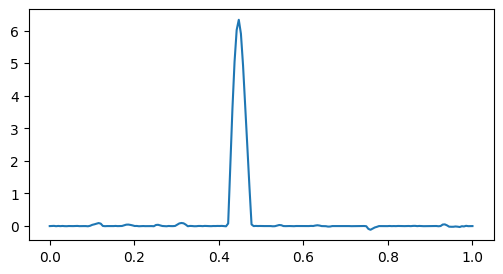

eigenstate: 3, epoch: 4200
ev: 93180.82, norm: 0.99952614, pde: 12163.509, loss: 12173.191, loc_idx: 0, used_loc_idxs: []


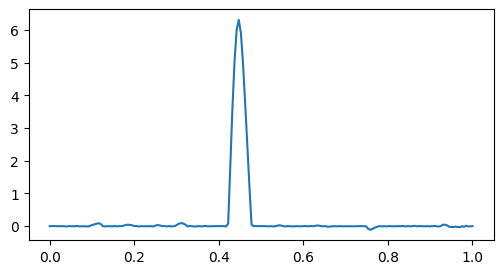

eigenstate: 3, epoch: 4300
ev: 97635.95, norm: 0.99940073, pde: 8709.672, loss: 8725.863, loc_idx: 0, used_loc_idxs: []


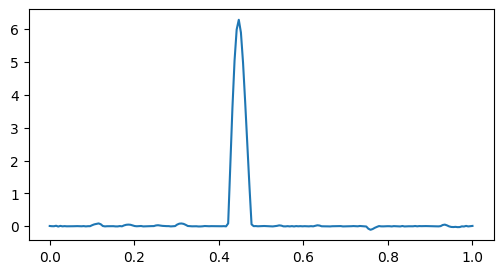

eigenstate: 3, epoch: 4400
ev: 100936.28, norm: 0.9995936, pde: 6754.7163, loss: 6762.6953, loc_idx: 0, used_loc_idxs: []


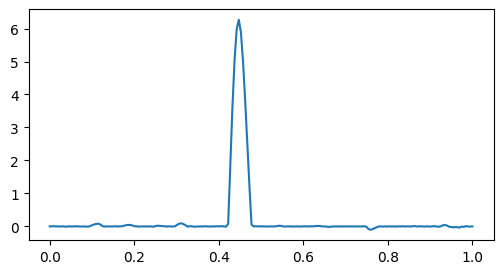

eigenstate: 3, epoch: 4500
ev: 102674.11, norm: 0.9995768, pde: 5414.803, loss: 5424.428, loc_idx: 0, used_loc_idxs: []


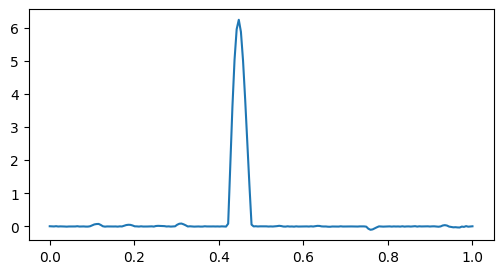

eigenstate: 3, epoch: 4600
ev: 103259.59, norm: 0.9996596, pde: 4695.7896, loss: 4701.9463, loc_idx: 0, used_loc_idxs: []


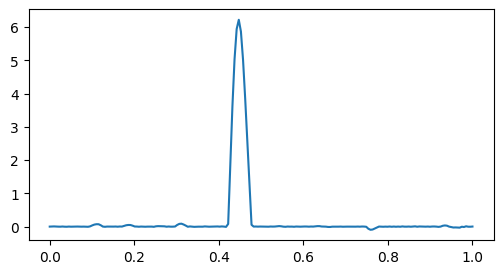

eigenstate: 3, epoch: 4700
ev: 103379.1, norm: 0.99964505, pde: 4169.3237, loss: 4176.889, loc_idx: 0, used_loc_idxs: []


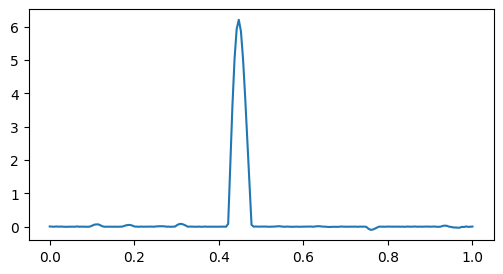

eigenstate: 3, epoch: 4800
ev: 103388.445, norm: 0.9999991, pde: 3879.4805, loss: 3884.338, loc_idx: 0, used_loc_idxs: []


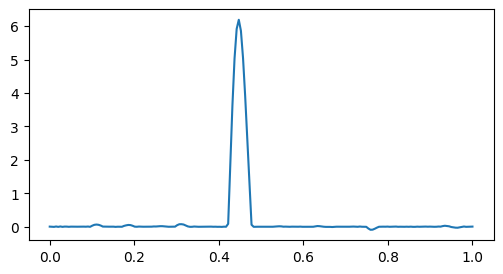

eigenstate: 3, epoch: 4900
ev: 103382.9, norm: 0.9996818, pde: 3638.428, loss: 3643.741, loc_idx: 0, used_loc_idxs: []


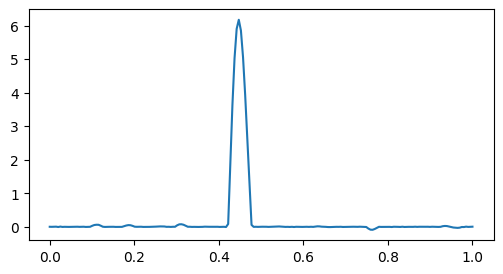

eigenstate: 3, epoch: 5000
ev: 103375.89, norm: 1.0000716, pde: 3424.8481, loss: 3429.7751, loc_idx: 0, used_loc_idxs: []


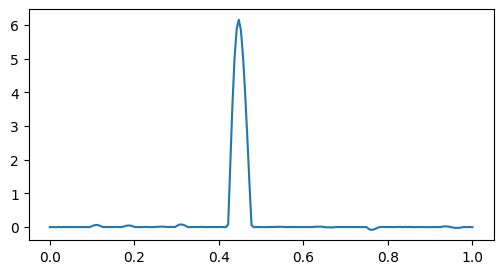

eigenstate: 3, epoch: 5100
ev: 103369.195, norm: 0.999758, pde: 3295.1892, loss: 3298.484, loc_idx: 0, used_loc_idxs: []


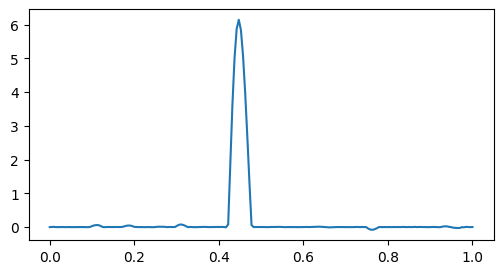

eigenstate: 3, epoch: 5200
ev: 103362.89, norm: 0.9998773, pde: 3166.5977, loss: 3170.038, loc_idx: 0, used_loc_idxs: []


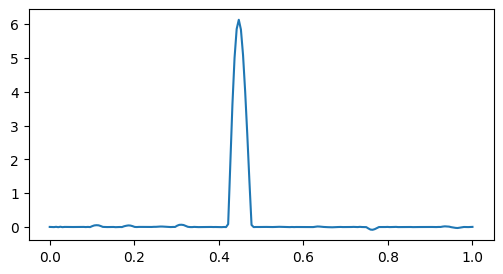

eigenstate: 3, epoch: 5300
ev: 103358.45, norm: 1.0002004, pde: 3068.4158, loss: 3071.0212, loc_idx: 0, used_loc_idxs: []


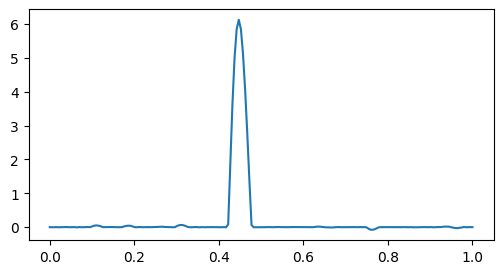

eigenstate: 3, epoch: 5400
ev: 103351.94, norm: 1.0001258, pde: 2951.1775, loss: 2954.7837, loc_idx: 0, used_loc_idxs: []


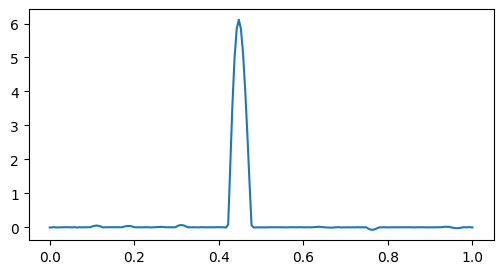

eigenstate: 3, epoch: 5500
ev: 103347.57, norm: 0.9997263, pde: 2889.5098, loss: 2891.7236, loc_idx: 0, used_loc_idxs: []


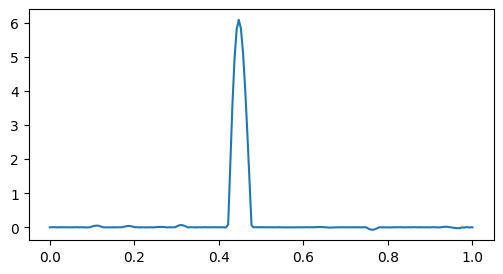

eigenstate: 3, epoch: 5600
ev: 103342.9, norm: 1.000134, pde: 2831.615, loss: 2833.1487, loc_idx: 0, used_loc_idxs: []


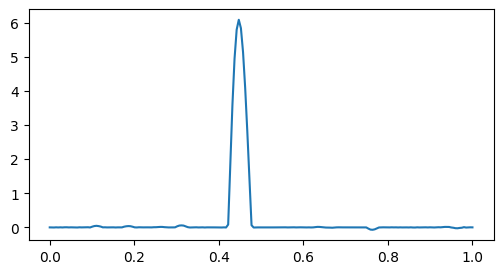

eigenstate: 3, epoch: 5700
ev: 103338.016, norm: 0.9999239, pde: 2759.9321, loss: 2761.8804, loc_idx: 0, used_loc_idxs: []


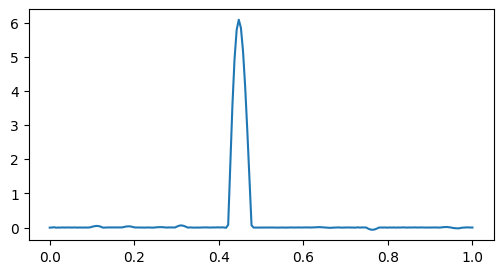

eigenstate: 3, epoch: 5800
ev: 103333.61, norm: 1.0000196, pde: 2733.8264, loss: 2735.958, loc_idx: 0, used_loc_idxs: []


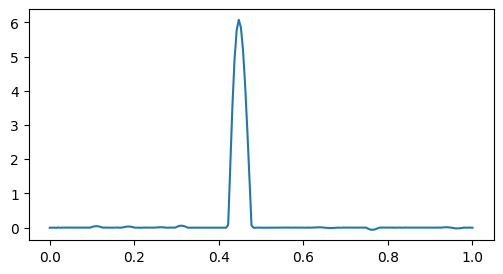

eigenstate: 3, epoch: 5900
ev: 103329.44, norm: 1.0001513, pde: 2684.1267, loss: 2685.6938, loc_idx: 0, used_loc_idxs: []


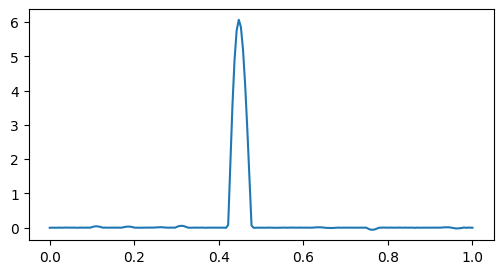

eigenstate: 3, epoch: 6000
ev: 103325.85, norm: 0.9999982, pde: 2629.7769, loss: 2630.7512, loc_idx: 0, used_loc_idxs: []


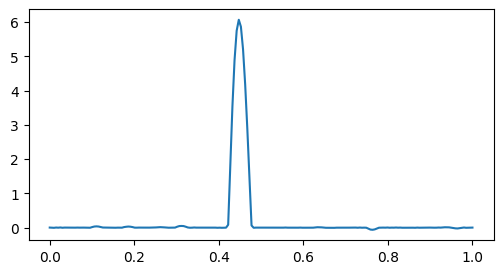

eigenstate: 3, epoch: 6100
ev: 103321.87, norm: 0.999809, pde: 2580.3833, loss: 2581.4075, loc_idx: 0, used_loc_idxs: []


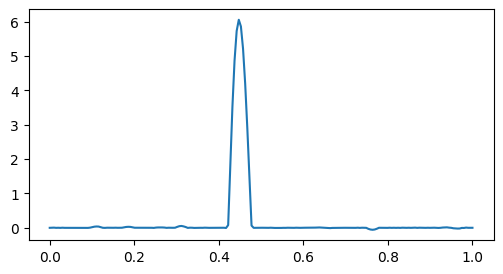

eigenstate: 3, epoch: 6200
ev: 103318.586, norm: 0.99998385, pde: 2565.5461, loss: 2566.863, loc_idx: 0, used_loc_idxs: []


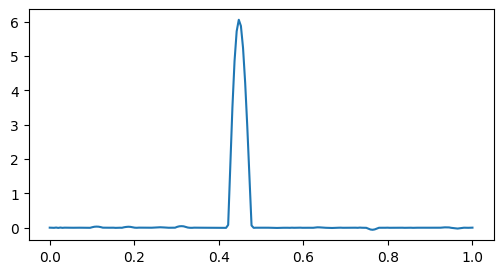

eigenstate: 3, epoch: 6300
ev: 103315.2, norm: 0.9998489, pde: 2523.8435, loss: 2525.098, loc_idx: 0, used_loc_idxs: []


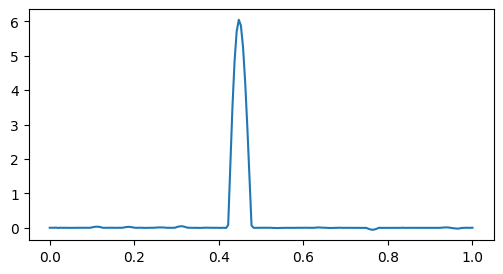

eigenstate: 3, epoch: 6400
ev: 103312.65, norm: 0.9996717, pde: 2488.6968, loss: 2490.5361, loc_idx: 0, used_loc_idxs: []


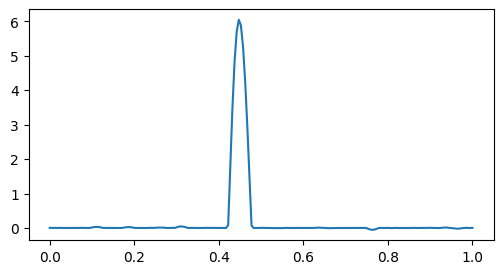

eigenstate: 3, epoch: 6500
ev: 103309.3, norm: 0.999925, pde: 2456.6736, loss: 2457.2898, loc_idx: 0, used_loc_idxs: []


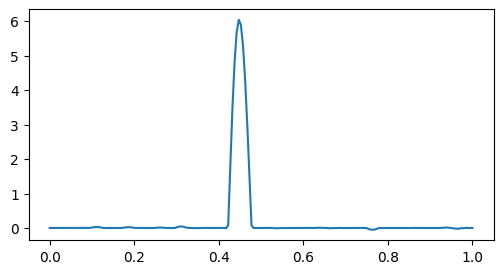

eigenstate: 3, epoch: 6600
ev: 103307.19, norm: 1.0001724, pde: 2434.5222, loss: 2436.0342, loc_idx: 0, used_loc_idxs: []


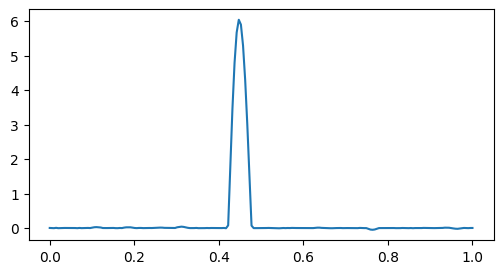

eigenstate: 3, epoch: 6700
ev: 103305.01, norm: 0.9999849, pde: 2417.0251, loss: 2417.4963, loc_idx: 0, used_loc_idxs: []


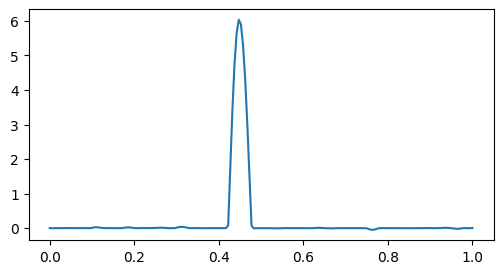

eigenstate: 3, epoch: 6800
ev: 103302.83, norm: 1.0000054, pde: 2391.4626, loss: 2391.8389, loc_idx: 0, used_loc_idxs: []


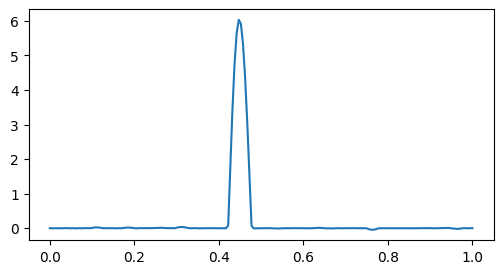

eigenstate: 3, epoch: 6900
ev: 103300.88, norm: 1.0000424, pde: 2387.1018, loss: 2388.0305, loc_idx: 0, used_loc_idxs: []


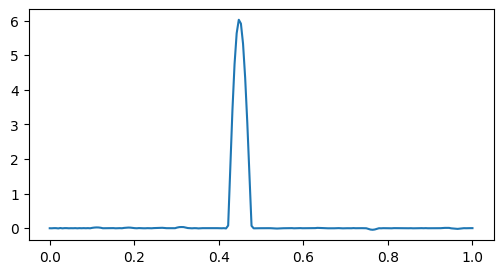

eigenstate: 3, epoch: 7000
ev: 103299.2, norm: 0.99998915, pde: 2335.3577, loss: 2336.016, loc_idx: 0, used_loc_idxs: []


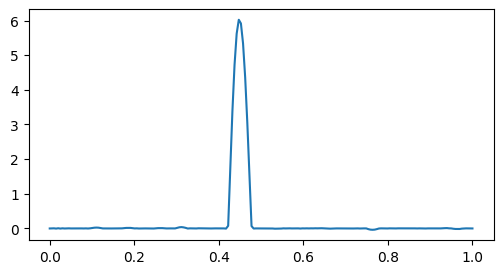

eigenstate: 3, epoch: 7100
ev: 103297.73, norm: 1.0000343, pde: 2319.49, loss: 2320.4072, loc_idx: 0, used_loc_idxs: []


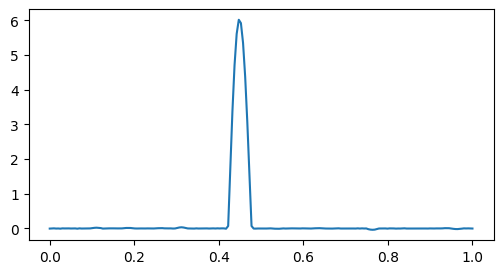

eigenstate: 3, epoch: 7200
ev: 103296.695, norm: 1.000085, pde: 2334.944, loss: 2335.4233, loc_idx: 0, used_loc_idxs: []


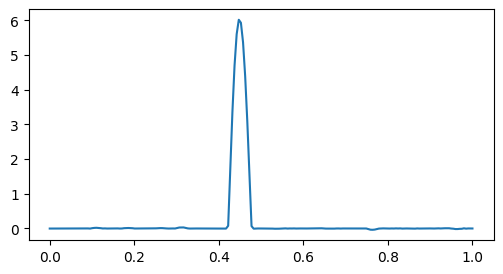

eigenstate: 3, epoch: 7300
ev: 103295.1, norm: 0.99997425, pde: 2304.6194, loss: 2304.9165, loc_idx: 0, used_loc_idxs: []


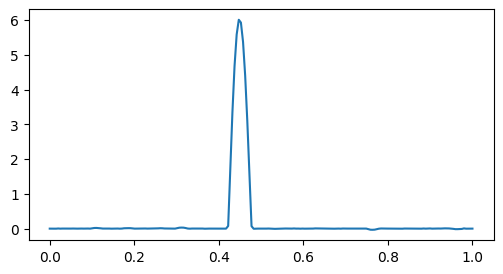

eigenstate: 3, epoch: 7400
ev: 103295.36, norm: 1.0000317, pde: 2295.6702, loss: 2296.1052, loc_idx: 0, used_loc_idxs: []


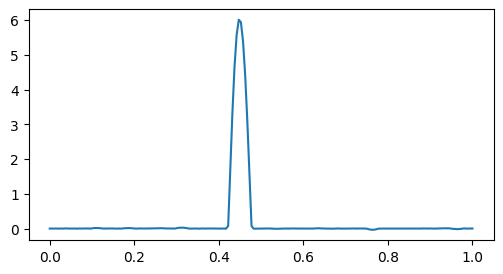

eigenstate: 3, epoch: 7500
ev: 103292.98, norm: 0.9998929, pde: 2265.3867, loss: 2266.0566, loc_idx: 0, used_loc_idxs: []


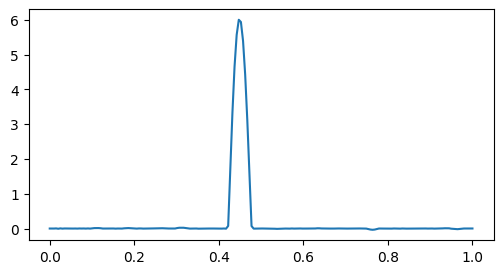

eigenstate: 3, epoch: 7600
ev: 103292.69, norm: 0.99990714, pde: 2252.3633, loss: 2252.8384, loc_idx: 0, used_loc_idxs: []


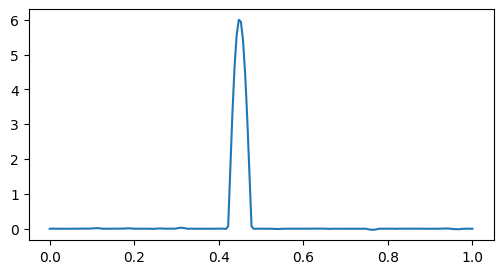

eigenstate: 3, epoch: 7700
ev: 103292.26, norm: 0.99990237, pde: 2168.374, loss: 2168.866, loc_idx: 0, used_loc_idxs: []


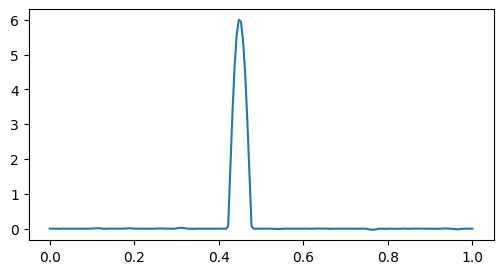

eigenstate: 3, epoch: 7800
ev: 103292.484, norm: 0.9996323, pde: 2164.2815, loss: 2165.7468, loc_idx: 0, used_loc_idxs: []


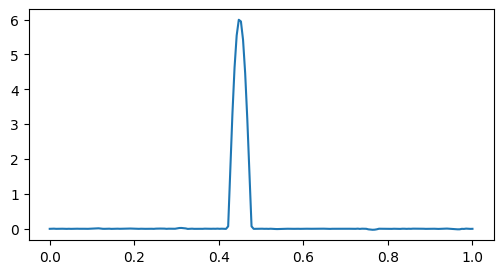

eigenstate: 3, epoch: 7900
ev: 103291.59, norm: 1.0001465, pde: 2139.3232, loss: 2140.1475, loc_idx: 0, used_loc_idxs: []


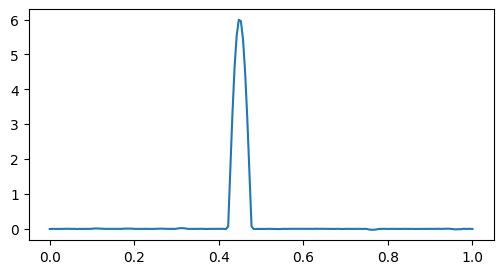

eigenstate: 3, epoch: 8000
ev: 103291.02, norm: 1.0001982, pde: 2466.045, loss: 2467.532, loc_idx: 0, used_loc_idxs: []


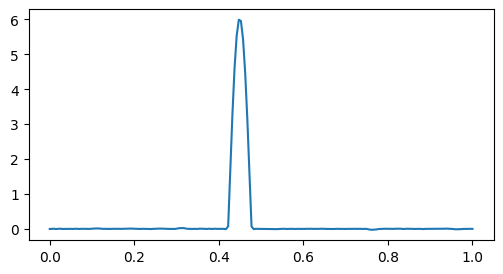

eigenstate: 3, epoch: 8100
ev: 103297.7, norm: 0.9997566, pde: 4481.056, loss: 4483.609, loc_idx: 0, used_loc_idxs: []


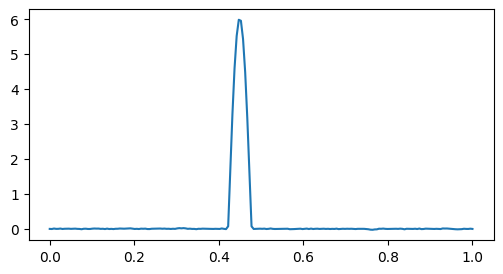

eigenstate: 3, epoch: 8200
ev: 103295.766, norm: 1.0004519, pde: 3036.5503, loss: 3040.0027, loc_idx: 0, used_loc_idxs: []


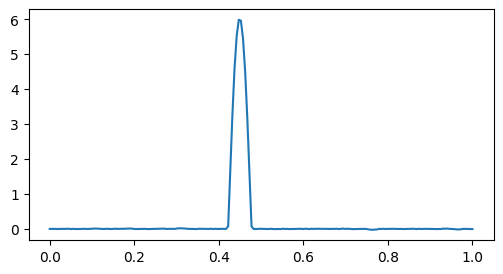

eigenstate: 3, epoch: 8300
ev: 103293.65, norm: 1.0003031, pde: 2639.7883, loss: 2642.9219, loc_idx: 0, used_loc_idxs: []


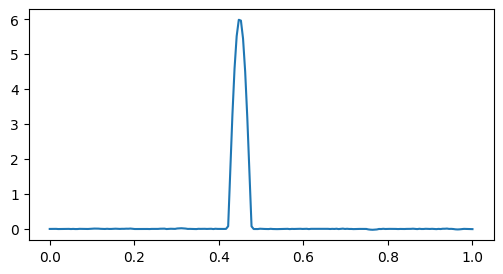

eigenstate: 3, epoch: 8400
ev: 103296.25, norm: 0.9999875, pde: 5337.5693, loss: 5344.5244, loc_idx: 0, used_loc_idxs: []


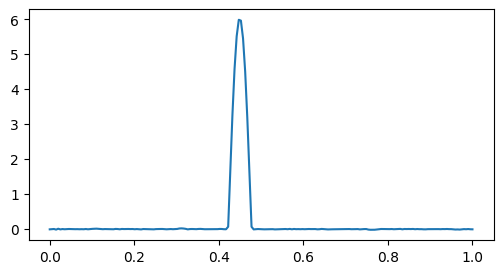

eigenstate: 3, epoch: 8500
ev: 103295.65, norm: 0.99998564, pde: 4430.233, loss: 4433.289, loc_idx: 0, used_loc_idxs: []


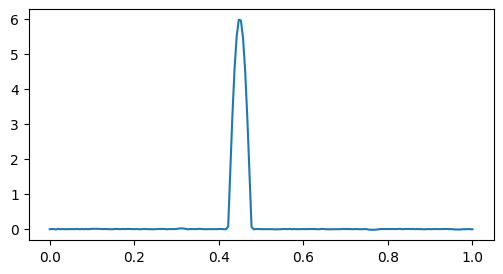

eigenstate: 3, epoch: 8600
ev: 103296.93, norm: 1.0002552, pde: 4037.6062, loss: 4039.9583, loc_idx: 0, used_loc_idxs: []


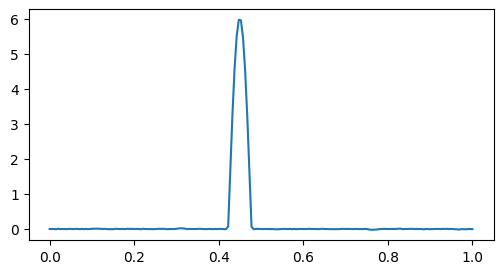

eigenstate: 3, epoch: 8700
ev: 103296.6, norm: 1.0005242, pde: 3668.4875, loss: 3672.017, loc_idx: 0, used_loc_idxs: []


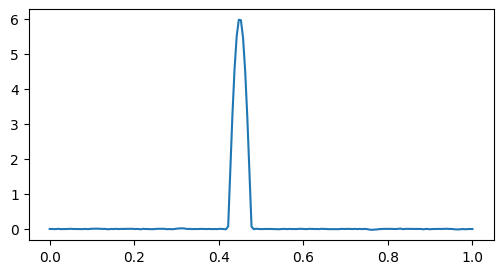

eigenstate: 3, epoch: 8800
ev: 103295.65, norm: 1.0006579, pde: 3321.1848, loss: 3325.333, loc_idx: 0, used_loc_idxs: []


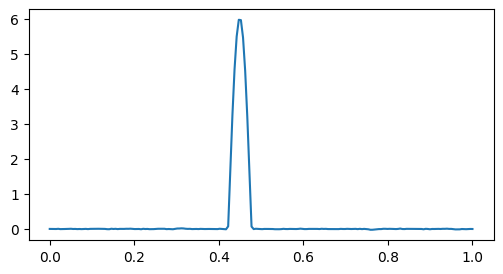

eigenstate: 3, epoch: 8900
ev: 103293.9, norm: 1.0009594, pde: 2880.7104, loss: 2888.4355, loc_idx: 0, used_loc_idxs: []


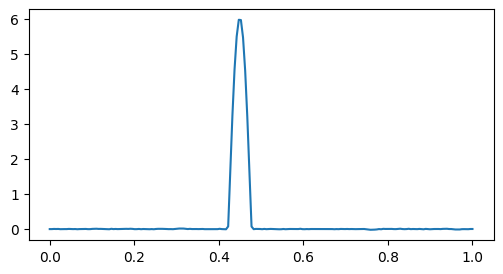

OUT OF EPOCHS
eigenstate: 4, epoch: 0
ev: 0.006014552, norm: 0.35851517, pde: 680194.7, loss: 3950249.0, loc_idx: -1, used_loc_idxs: []


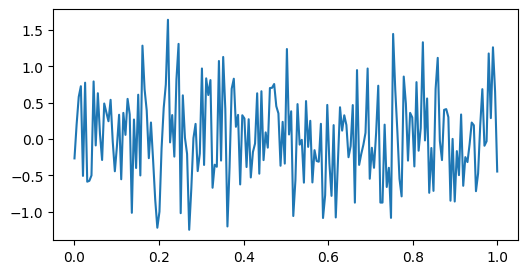

eigenstate: 4, epoch: 100
ev: 3.3020036, norm: 0.9784803, pde: 681198.44, loss: 686489.0, loc_idx: -1, used_loc_idxs: []


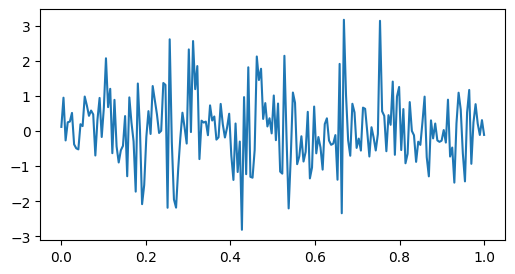

eigenstate: 4, epoch: 200
ev: 18.328522, norm: 0.9855184, pde: 429051.78, loss: 431642.44, loc_idx: -1, used_loc_idxs: []


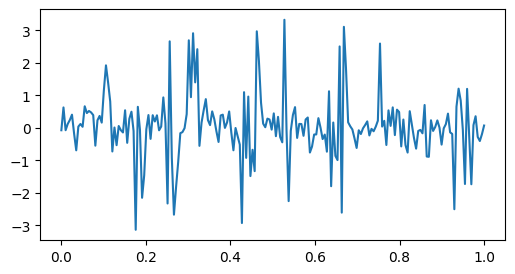

eigenstate: 4, epoch: 300
ev: 61.16764, norm: 0.9894886, pde: 307435.28, loss: 308690.75, loc_idx: -1, used_loc_idxs: []


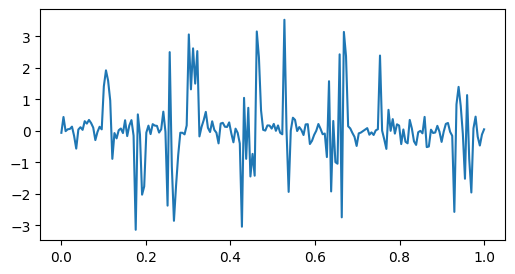

eigenstate: 4, epoch: 400
ev: 150.63332, norm: 0.9919717, pde: 234823.92, loss: 235479.4, loc_idx: -1, used_loc_idxs: []


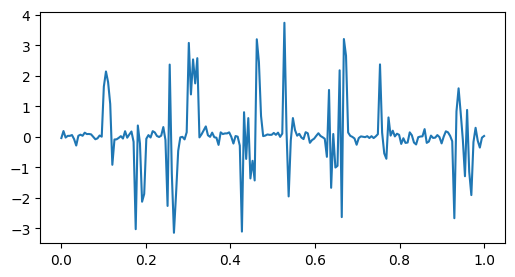

eigenstate: 4, epoch: 500
ev: 303.13007, norm: 0.9934972, pde: 197996.34, loss: 198358.36, loc_idx: -1, used_loc_idxs: []


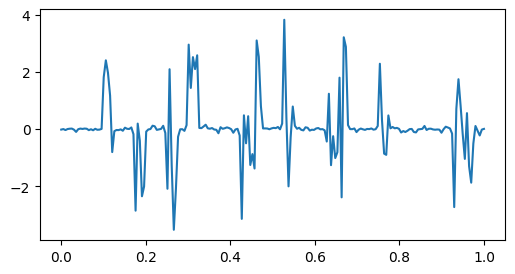

eigenstate: 4, epoch: 600
ev: 526.28296, norm: 0.99464643, pde: 178956.22, loss: 179199.36, loc_idx: -1, used_loc_idxs: []


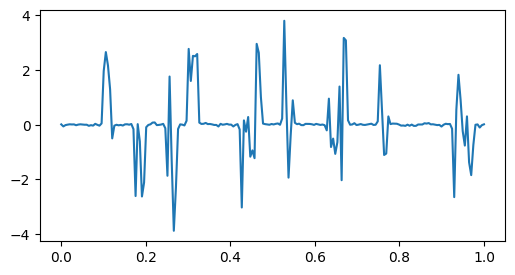

eigenstate: 4, epoch: 700
ev: 826.07916, norm: 0.99538743, pde: 164170.06, loss: 164360.92, loc_idx: -1, used_loc_idxs: []


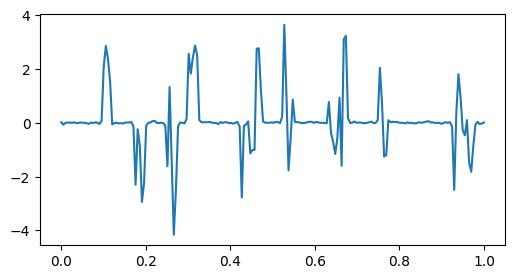

eigenstate: 4, epoch: 800
ev: 1211.0018, norm: 0.9945819, pde: 150575.66, loss: 150818.23, loc_idx: -1, used_loc_idxs: []


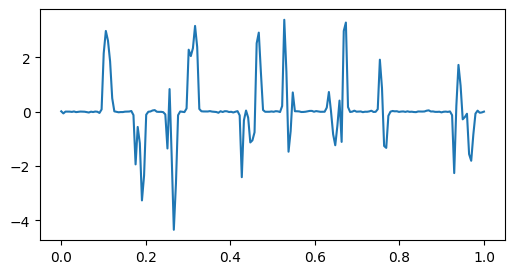

eigenstate: 4, epoch: 900
ev: 1690.2808, norm: 0.99489754, pde: 139879.84, loss: 140090.23, loc_idx: -1, used_loc_idxs: []


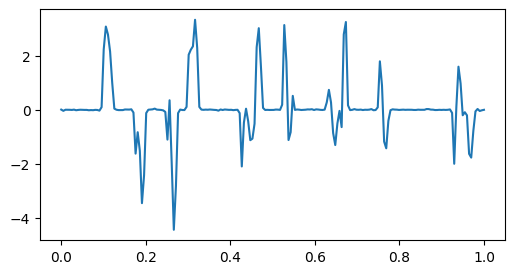

eigenstate: 4, epoch: 1000
ev: 2271.4424, norm: 0.99473184, pde: 131478.98, loss: 131699.92, loc_idx: -1, used_loc_idxs: []


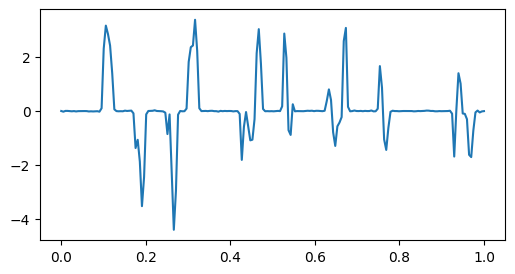

eigenstate: 4, epoch: 1100
ev: 2960.8706, norm: 0.99572104, pde: 124745.27, loss: 124890.92, loc_idx: -1, used_loc_idxs: []


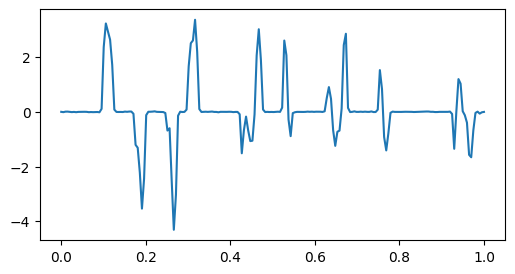

eigenstate: 4, epoch: 1200
ev: 3764.0532, norm: 0.99625623, pde: 119479.445, loss: 119590.81, loc_idx: -1, used_loc_idxs: []


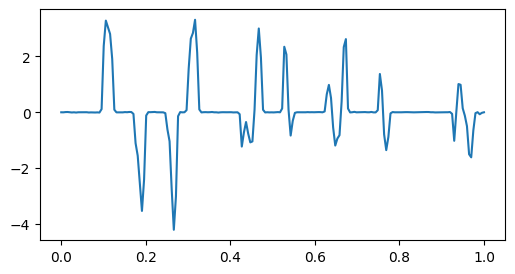

eigenstate: 4, epoch: 1300
ev: 4685.3086, norm: 0.9977174, pde: 115452.516, loss: 115494.48, loc_idx: -1, used_loc_idxs: []


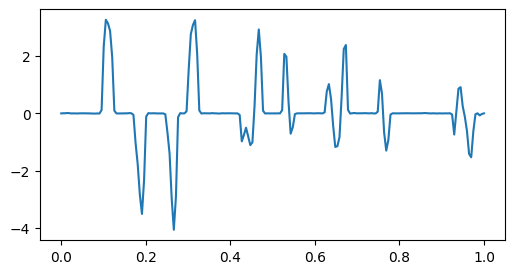

eigenstate: 4, epoch: 1400
ev: 5728.1304, norm: 0.9965487, pde: 112164.0, loss: 112258.81, loc_idx: -1, used_loc_idxs: []


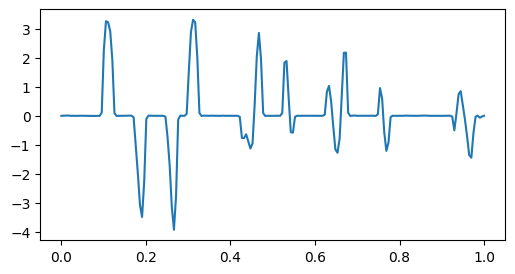

eigenstate: 4, epoch: 1500
ev: 6895.585, norm: 0.9969674, pde: 109494.62, loss: 109567.97, loc_idx: -1, used_loc_idxs: []


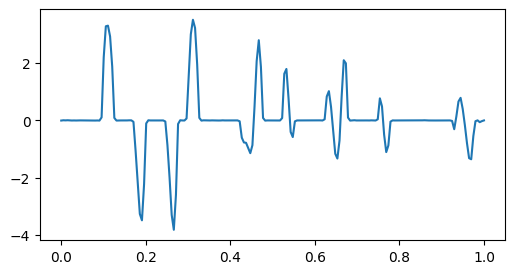

eigenstate: 4, epoch: 1600
ev: 8190.6875, norm: 0.99772847, pde: 107110.516, loss: 107152.07, loc_idx: -1, used_loc_idxs: []


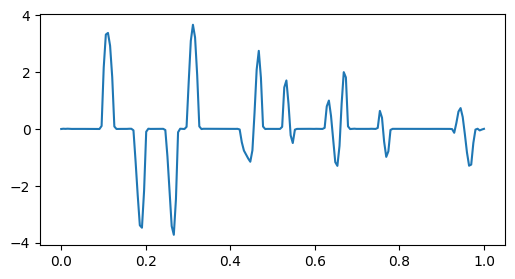

eigenstate: 4, epoch: 1700
ev: 9616.512, norm: 0.9963547, pde: 104734.24, loss: 104839.5, loc_idx: -1, used_loc_idxs: []


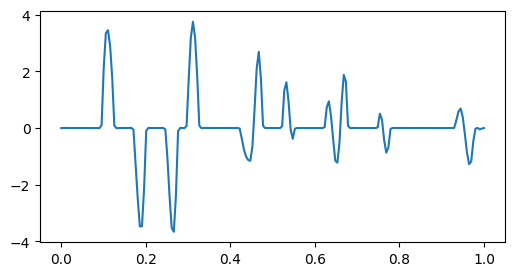

eigenstate: 4, epoch: 1800
ev: 11176.17, norm: 0.99662733, pde: 102469.86, loss: 102559.98, loc_idx: -1, used_loc_idxs: []


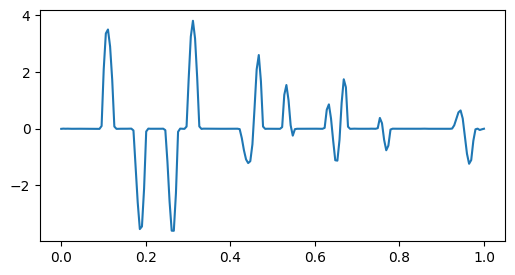

eigenstate: 4, epoch: 1900
ev: 12872.559, norm: 0.9971418, pde: 100209.53, loss: 100274.3, loc_idx: -1, used_loc_idxs: []


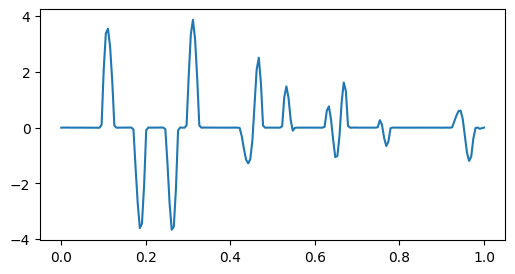

SETTING IDX_GROUPS
idx_groups: [[12], [3, 4], [10], [7], [17, 18], [25, 26], [21], [38]]
eigenstate: 4, epoch: 2000
ev: 14708.452, norm: 0.99299085, pde: 97704.15, loss: 98091.86, loc_idx: 0, used_loc_idxs: []


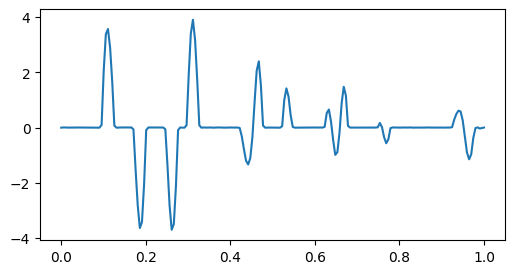

eigenstate: 4, epoch: 2100
ev: 15954.073, norm: 0.96145594, pde: 543812.06, loss: 681944.5, loc_idx: 0, used_loc_idxs: []


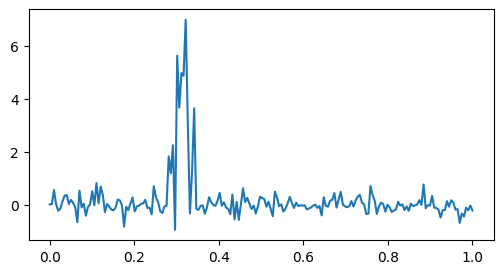

eigenstate: 4, epoch: 2200
ev: 17251.088, norm: 0.9842117, pde: 324921.72, loss: 355629.75, loc_idx: 0, used_loc_idxs: []


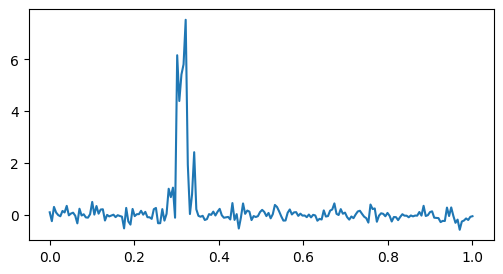

eigenstate: 4, epoch: 2300
ev: 18756.83, norm: 0.9923125, pde: 161255.34, loss: 174621.58, loc_idx: 0, used_loc_idxs: []


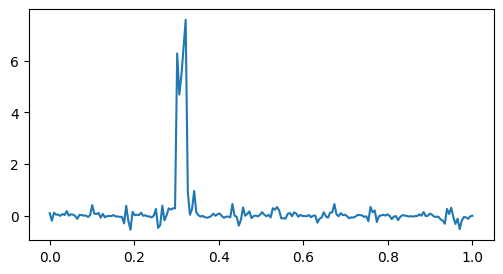

eigenstate: 4, epoch: 2400
ev: 20985.883, norm: 0.99571955, pde: 112109.67, loss: 116161.77, loc_idx: 0, used_loc_idxs: []


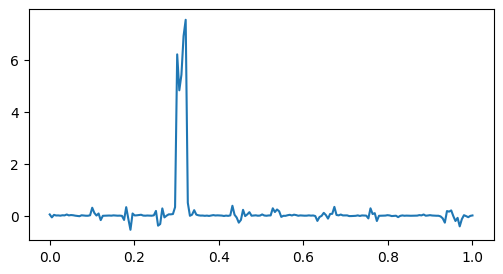

eigenstate: 4, epoch: 2500
ev: 23628.61, norm: 0.99641216, pde: 105039.12, loss: 106487.69, loc_idx: 0, used_loc_idxs: []


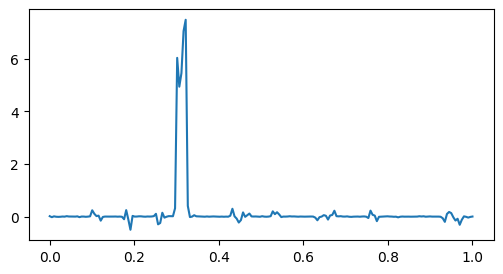

eigenstate: 4, epoch: 2600
ev: 26431.422, norm: 0.99667746, pde: 100498.43, loss: 101238.05, loc_idx: 0, used_loc_idxs: []


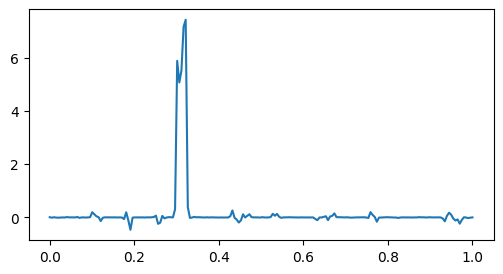

eigenstate: 4, epoch: 2700
ev: 29376.996, norm: 0.99686015, pde: 96194.46, loss: 96682.93, loc_idx: 0, used_loc_idxs: []


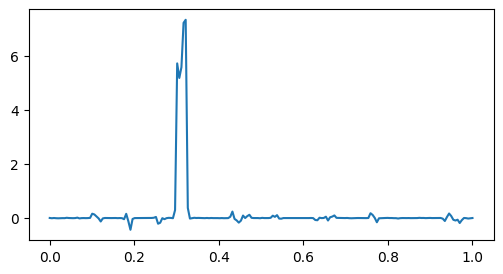

eigenstate: 4, epoch: 2800
ev: 32466.496, norm: 0.9970164, pde: 91920.09, loss: 92295.16, loc_idx: 0, used_loc_idxs: []


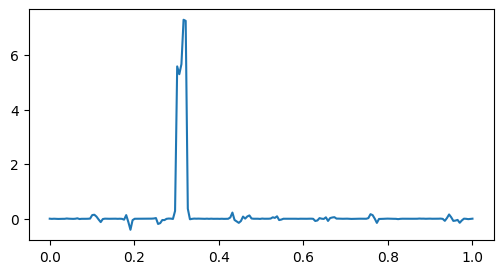

eigenstate: 4, epoch: 2900
ev: 35702.49, norm: 0.99716383, pde: 87599.36, loss: 87913.86, loc_idx: 0, used_loc_idxs: []


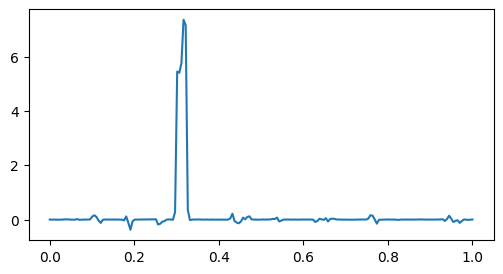

eigenstate: 4, epoch: 3000
ev: 39087.73, norm: 0.99730945, pde: 83197.06, loss: 83474.93, loc_idx: 0, used_loc_idxs: []


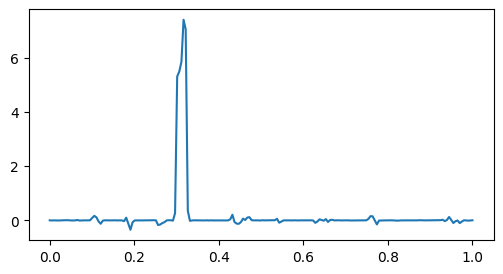

eigenstate: 4, epoch: 3100
ev: 42624.883, norm: 0.99745655, pde: 78696.12, loss: 78949.266, loc_idx: 0, used_loc_idxs: []


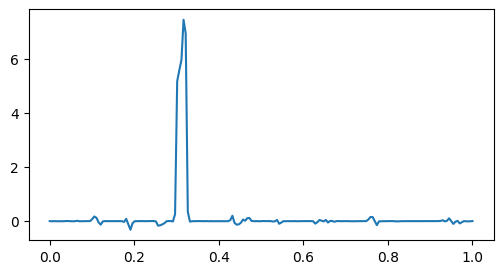

eigenstate: 4, epoch: 3200
ev: 46316.43, norm: 0.99760604, pde: 74085.95, loss: 74320.9, loc_idx: 0, used_loc_idxs: []


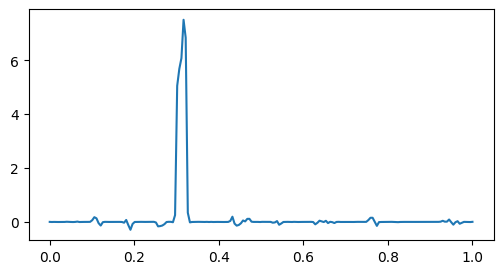

eigenstate: 4, epoch: 3300
ev: 50164.656, norm: 0.99775934, pde: 69360.48, loss: 69580.79, loc_idx: 0, used_loc_idxs: []


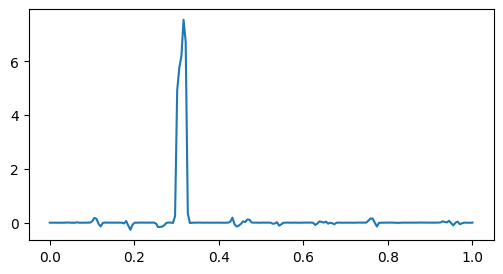

eigenstate: 4, epoch: 3400
ev: 54171.65, norm: 0.99791485, pde: 64515.6, loss: 64723.434, loc_idx: 0, used_loc_idxs: []


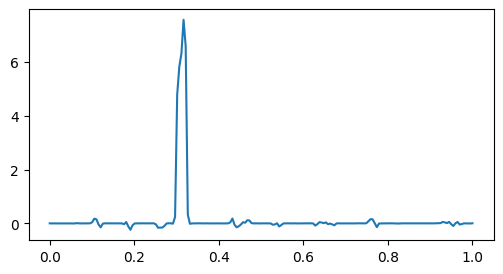

eigenstate: 4, epoch: 3500
ev: 58339.277, norm: 0.99807405, pde: 59548.92, loss: 59745.473, loc_idx: 0, used_loc_idxs: []


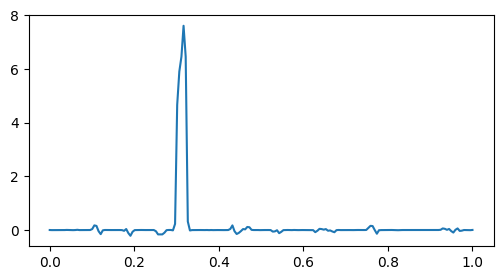

eigenstate: 4, epoch: 3600
ev: 62669.152, norm: 0.99823785, pde: 54459.336, loss: 54645.18, loc_idx: 0, used_loc_idxs: []


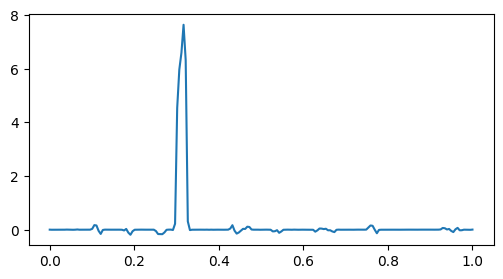

eigenstate: 4, epoch: 3700
ev: 67162.766, norm: 0.99840206, pde: 49233.453, loss: 49409.375, loc_idx: 0, used_loc_idxs: []


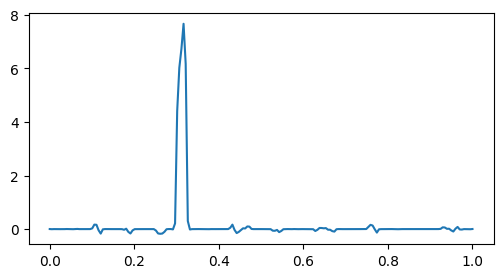

eigenstate: 4, epoch: 3800
ev: 71821.43, norm: 0.9985727, pde: 43886.67, loss: 44050.445, loc_idx: 0, used_loc_idxs: []


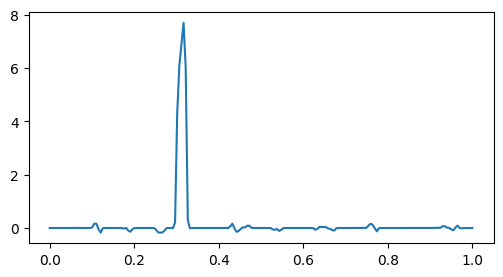

eigenstate: 4, epoch: 3900
ev: 76645.23, norm: 0.9987431, pde: 38421.45, loss: 38572.363, loc_idx: 0, used_loc_idxs: []


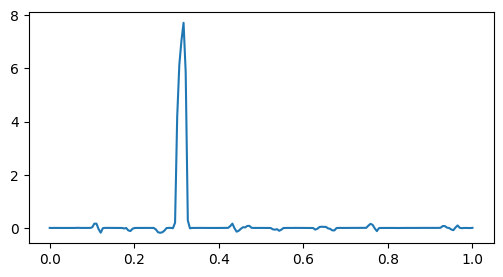

eigenstate: 4, epoch: 4000
ev: 81632.625, norm: 0.99894375, pde: 32842.99, loss: 32980.336, loc_idx: 0, used_loc_idxs: []


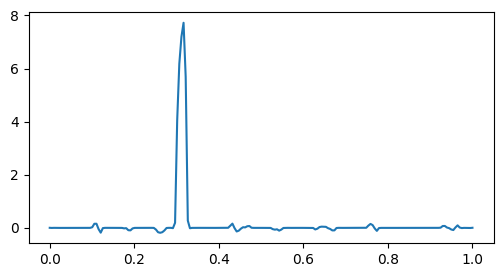

eigenstate: 4, epoch: 4100
ev: 86778.58, norm: 0.9992631, pde: 27236.979, loss: 27360.809, loc_idx: 0, used_loc_idxs: []


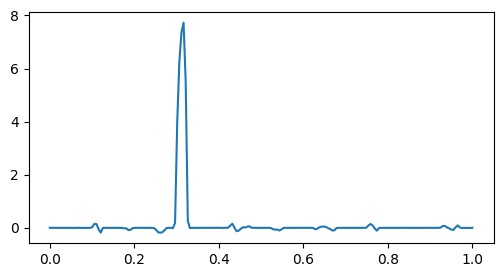

eigenstate: 4, epoch: 4200
ev: 92057.6, norm: 0.9994705, pde: 21616.838, loss: 21726.205, loc_idx: 0, used_loc_idxs: []


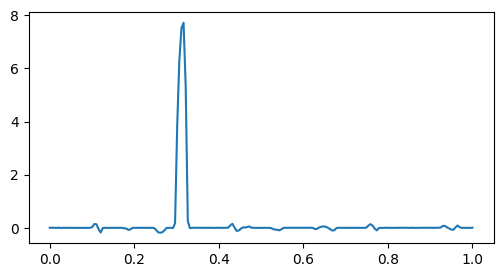

eigenstate: 4, epoch: 4300
ev: 97405.7, norm: 0.999798, pde: 16563.799, loss: 16659.31, loc_idx: 0, used_loc_idxs: []


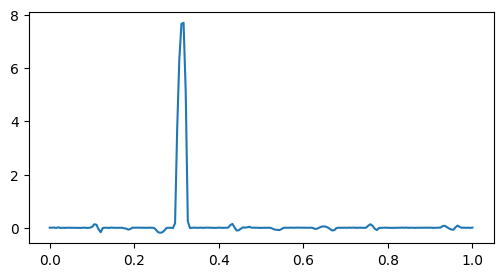

eigenstate: 4, epoch: 4400
ev: 102572.31, norm: 0.9997976, pde: 11932.074, loss: 12008.576, loc_idx: 0, used_loc_idxs: []


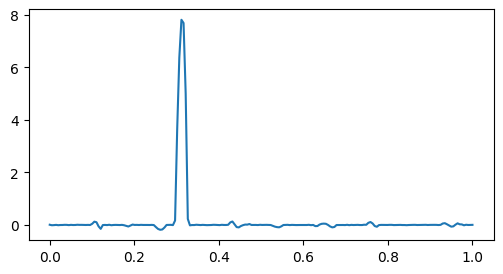

eigenstate: 4, epoch: 4500
ev: 106976.64, norm: 0.9998189, pde: 8635.706, loss: 8689.243, loc_idx: 0, used_loc_idxs: []


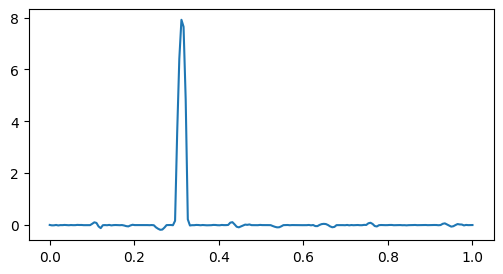

eigenstate: 4, epoch: 4600
ev: 109837.08, norm: 1.0001276, pde: 6511.634, loss: 6552.974, loc_idx: 0, used_loc_idxs: []


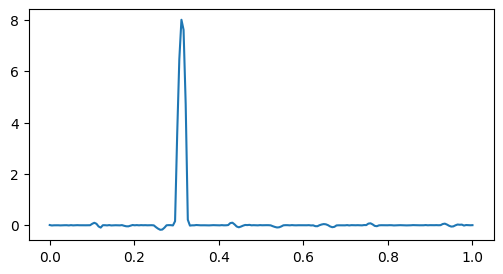

eigenstate: 4, epoch: 4700
ev: 111043.92, norm: 0.99952036, pde: 5456.704, loss: 5484.699, loc_idx: 0, used_loc_idxs: []


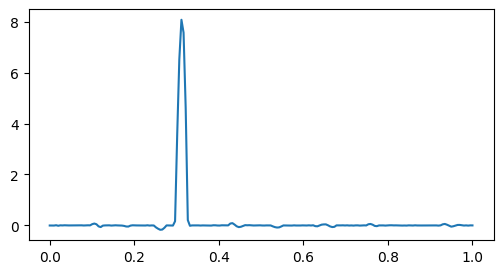

eigenstate: 4, epoch: 4800
ev: 111337.23, norm: 0.99967676, pde: 4866.736, loss: 4885.852, loc_idx: 0, used_loc_idxs: []


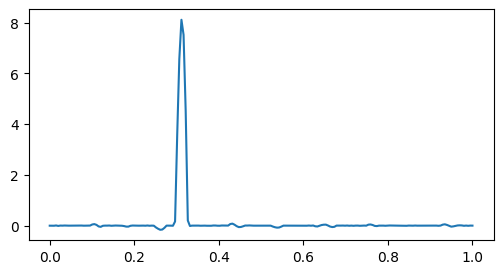

eigenstate: 4, epoch: 4900
ev: 111353.0, norm: 1.0003055, pde: 4413.8364, loss: 4432.931, loc_idx: 0, used_loc_idxs: []


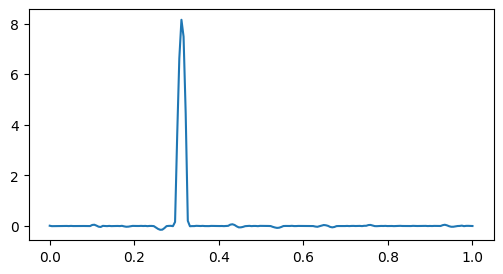

eigenstate: 4, epoch: 5000
ev: 111323.54, norm: 0.9997338, pde: 4149.0635, loss: 4158.882, loc_idx: 0, used_loc_idxs: []


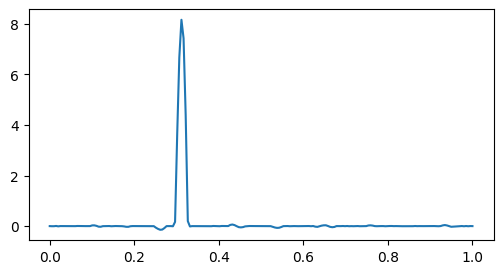

eigenstate: 4, epoch: 5100
ev: 111295.36, norm: 1.000214, pde: 3912.5164, loss: 3923.3125, loc_idx: 0, used_loc_idxs: []


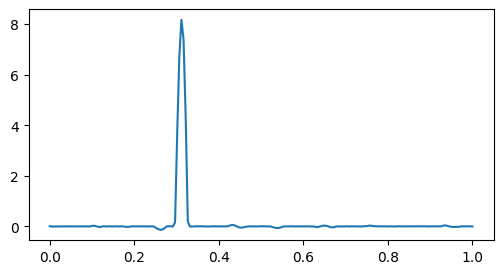

eigenstate: 4, epoch: 5200
ev: 111272.01, norm: 1.000299, pde: 3740.0835, loss: 3750.0193, loc_idx: 0, used_loc_idxs: []


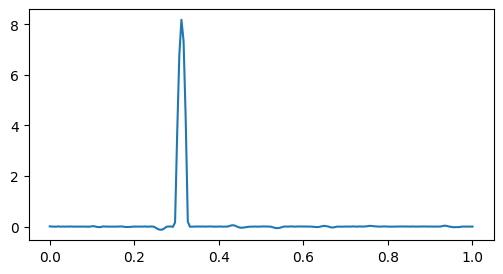

eigenstate: 4, epoch: 5300
ev: 111254.15, norm: 0.99999845, pde: 3559.898, loss: 3565.0134, loc_idx: 0, used_loc_idxs: []


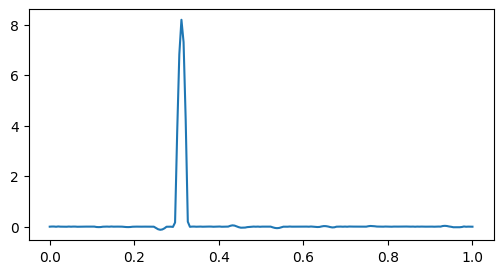

eigenstate: 4, epoch: 5400
ev: 111240.516, norm: 0.99976236, pde: 3430.6763, loss: 3435.9824, loc_idx: 0, used_loc_idxs: []


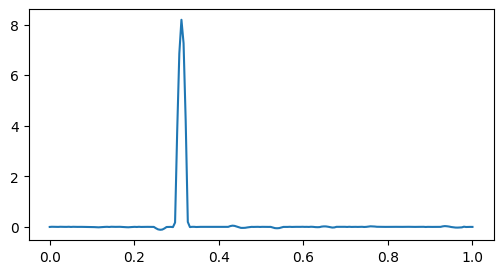

eigenstate: 4, epoch: 5500
ev: 111230.62, norm: 0.99988025, pde: 3323.4414, loss: 3326.9077, loc_idx: 0, used_loc_idxs: []


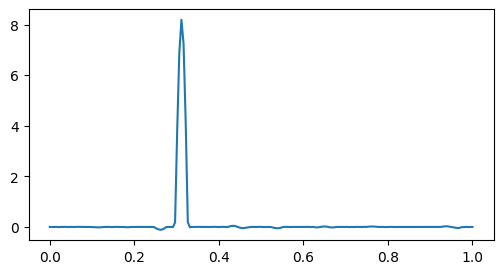

eigenstate: 4, epoch: 5600
ev: 111223.86, norm: 1.0002015, pde: 3185.4956, loss: 3189.5403, loc_idx: 0, used_loc_idxs: []


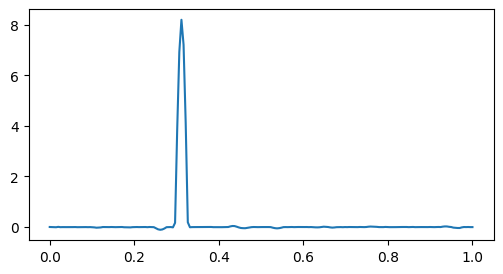

eigenstate: 4, epoch: 5700
ev: 111217.83, norm: 0.9999204, pde: 3138.8645, loss: 3141.623, loc_idx: 0, used_loc_idxs: []


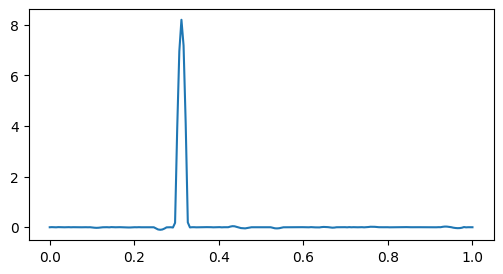

eigenstate: 4, epoch: 5800
ev: 111214.09, norm: 0.99996597, pde: 3039.25, loss: 3041.5852, loc_idx: 0, used_loc_idxs: []


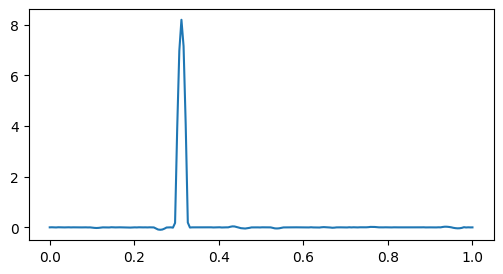

eigenstate: 4, epoch: 5900
ev: 111211.42, norm: 0.99994165, pde: 2964.0708, loss: 2966.3833, loc_idx: 0, used_loc_idxs: []


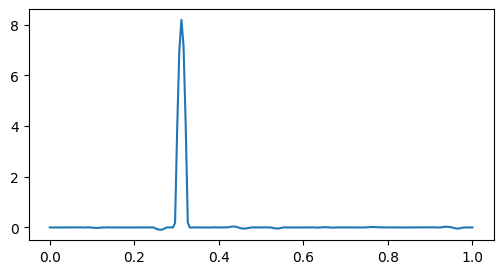

eigenstate: 4, epoch: 6000
ev: 111209.61, norm: 0.999951, pde: 2957.8608, loss: 2959.764, loc_idx: 0, used_loc_idxs: []


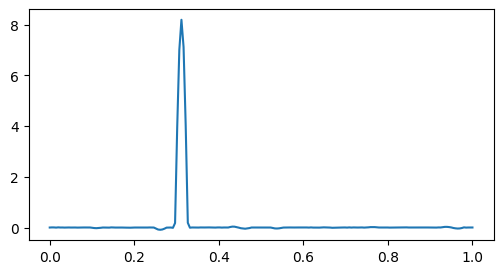

eigenstate: 4, epoch: 6100
ev: 111208.586, norm: 0.999958, pde: 2749.0815, loss: 2750.8088, loc_idx: 0, used_loc_idxs: []


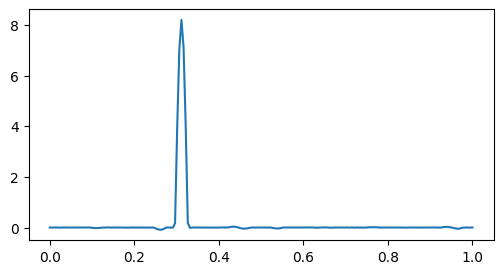

eigenstate: 4, epoch: 6200
ev: 111207.25, norm: 1.000004, pde: 2767.5408, loss: 2769.8022, loc_idx: 0, used_loc_idxs: []


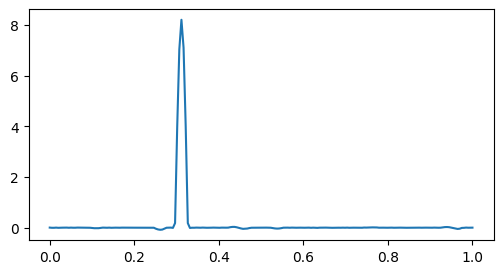

eigenstate: 4, epoch: 6300
ev: 111206.26, norm: 1.0001249, pde: 2557.013, loss: 2559.018, loc_idx: 0, used_loc_idxs: []


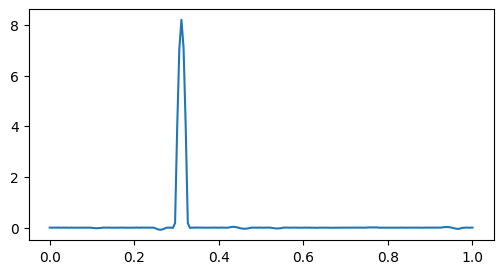

eigenstate: 4, epoch: 6400
ev: 111206.7, norm: 1.0000497, pde: 3129.4136, loss: 3130.7063, loc_idx: 0, used_loc_idxs: []


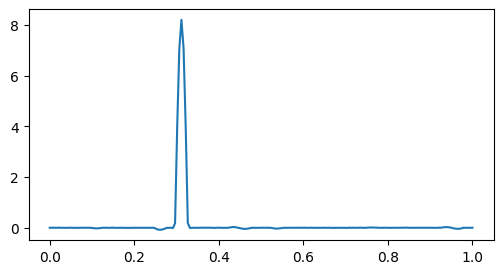

eigenstate: 4, epoch: 6500
ev: 111220.22, norm: 0.9993582, pde: 4846.3403, loss: 4852.196, loc_idx: 0, used_loc_idxs: []


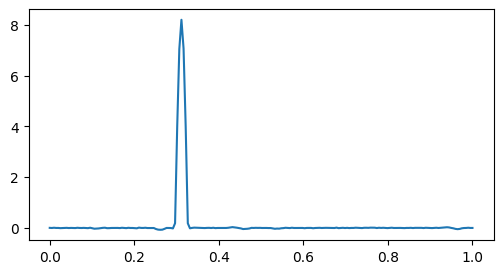

eigenstate: 4, epoch: 6600
ev: 111216.164, norm: 0.99957085, pde: 3583.3713, loss: 3586.4375, loc_idx: 0, used_loc_idxs: []


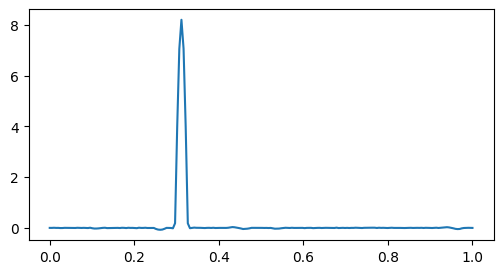

eigenstate: 4, epoch: 6700
ev: 111215.03, norm: 1.00022, pde: 5523.2056, loss: 5527.055, loc_idx: 0, used_loc_idxs: []


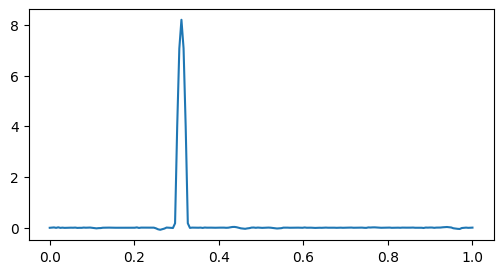

eigenstate: 4, epoch: 6800
ev: 111215.37, norm: 0.9998773, pde: 4804.1006, loss: 4809.1465, loc_idx: 0, used_loc_idxs: []


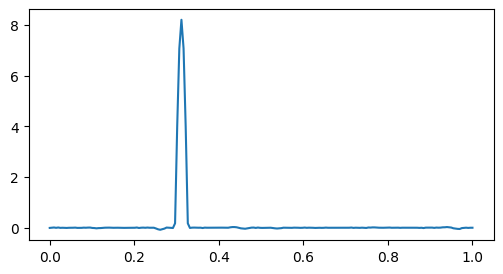

eigenstate: 4, epoch: 6900
ev: 111214.664, norm: 0.999945, pde: 4383.1553, loss: 4387.2036, loc_idx: 0, used_loc_idxs: []


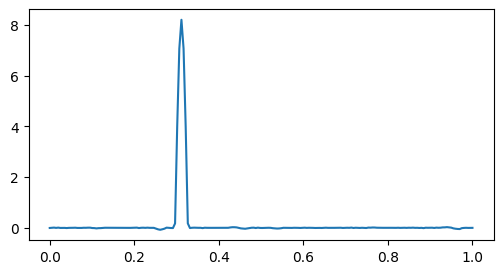

eigenstate: 4, epoch: 7000
ev: 111213.73, norm: 0.99992716, pde: 3818.375, loss: 3821.9473, loc_idx: 0, used_loc_idxs: []


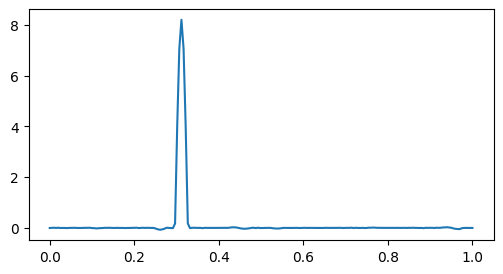

eigenstate: 4, epoch: 7100
ev: 111212.79, norm: 0.99990416, pde: 3538.4631, loss: 3541.8384, loc_idx: 0, used_loc_idxs: []


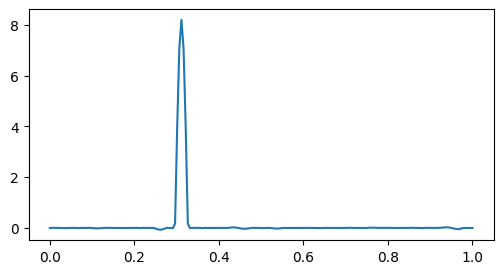

eigenstate: 4, epoch: 7200
ev: 111212.29, norm: 0.9999353, pde: 3803.8323, loss: 3807.1045, loc_idx: 0, used_loc_idxs: []


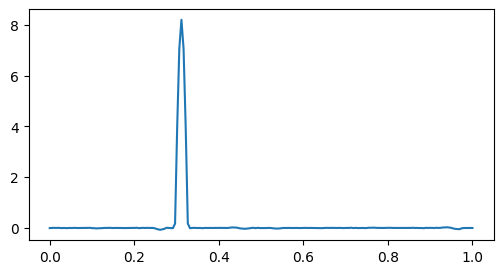

eigenstate: 4, epoch: 7300
ev: 111224.87, norm: 0.999631, pde: 4730.4146, loss: 4740.5146, loc_idx: 0, used_loc_idxs: []


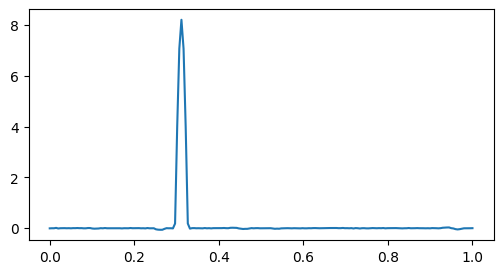

eigenstate: 4, epoch: 7400
ev: 111218.36, norm: 1.0004032, pde: 4548.071, loss: 4556.8594, loc_idx: 0, used_loc_idxs: []


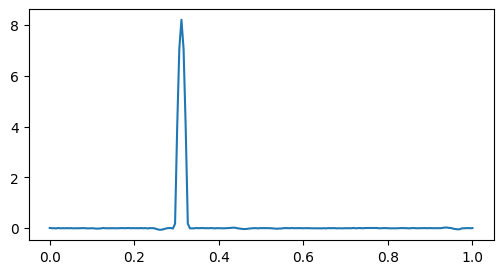

eigenstate: 4, epoch: 7500
ev: 111214.16, norm: 1.000405, pde: 4243.805, loss: 4250.577, loc_idx: 0, used_loc_idxs: []


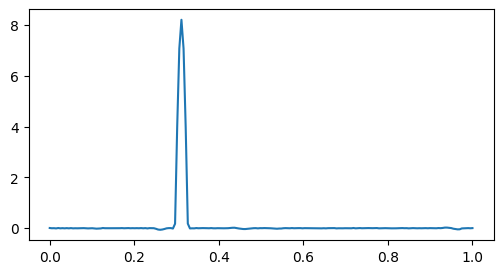

eigenstate: 4, epoch: 7600
ev: 111212.125, norm: 1.000353, pde: 3824.362, loss: 3829.6497, loc_idx: 0, used_loc_idxs: []


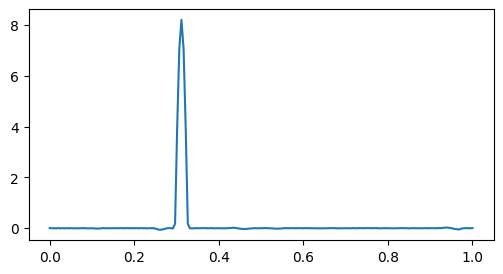

eigenstate: 4, epoch: 7700
ev: 111210.93, norm: 1.0002797, pde: 3584.195, loss: 3588.5542, loc_idx: 0, used_loc_idxs: []


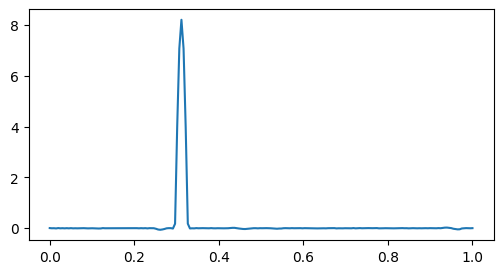

eigenstate: 4, epoch: 7800
ev: 111210.12, norm: 1.0002583, pde: 3490.9392, loss: 3494.7498, loc_idx: 0, used_loc_idxs: []


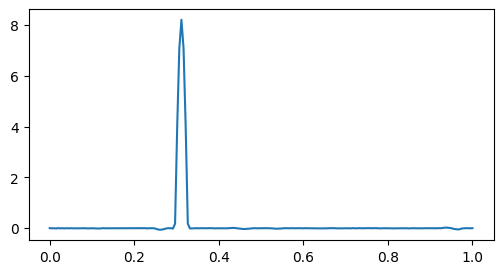

eigenstate: 4, epoch: 7900
ev: 111210.234, norm: 1.0001938, pde: 3308.7307, loss: 3311.8865, loc_idx: 0, used_loc_idxs: []


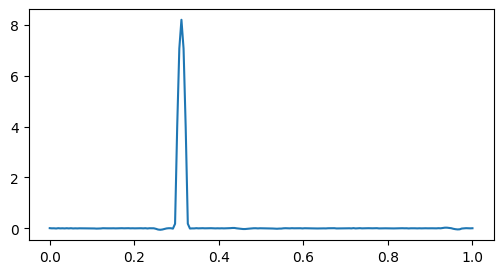

eigenstate: 4, epoch: 8000
ev: 111210.234, norm: 1.0000972, pde: 3190.336, loss: 3192.8633, loc_idx: 0, used_loc_idxs: []


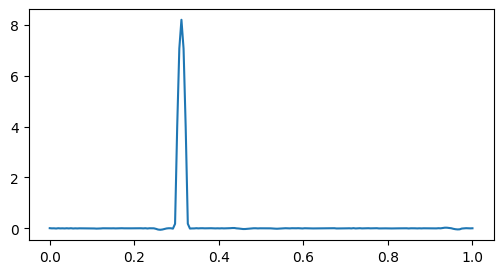

eigenstate: 4, epoch: 8100
ev: 111208.125, norm: 0.9999315, pde: 3706.9966, loss: 3710.1167, loc_idx: 0, used_loc_idxs: []


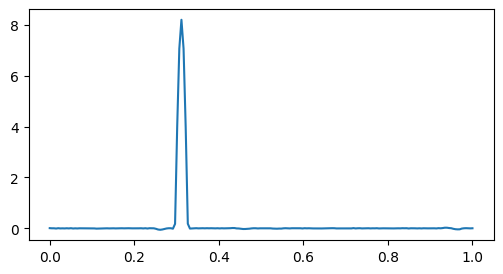

eigenstate: 4, epoch: 8200
ev: 111215.9, norm: 1.0000852, pde: 5674.809, loss: 5676.1216, loc_idx: 0, used_loc_idxs: []


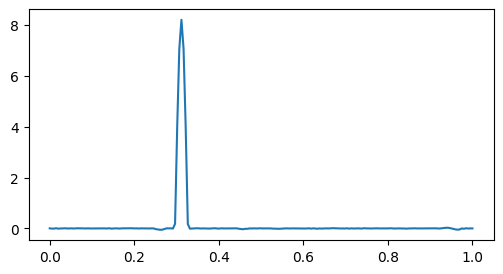

eigenstate: 4, epoch: 8300
ev: 111213.21, norm: 1.000118, pde: 5865.0063, loss: 5866.953, loc_idx: 0, used_loc_idxs: []


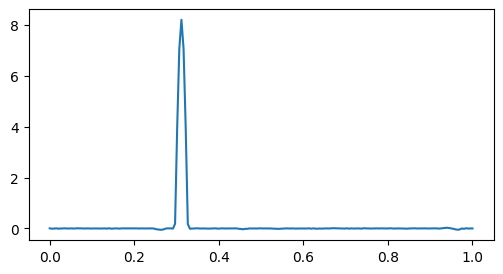

eigenstate: 4, epoch: 8400
ev: 111212.75, norm: 1.0000226, pde: 4734.5117, loss: 4735.4795, loc_idx: 0, used_loc_idxs: []


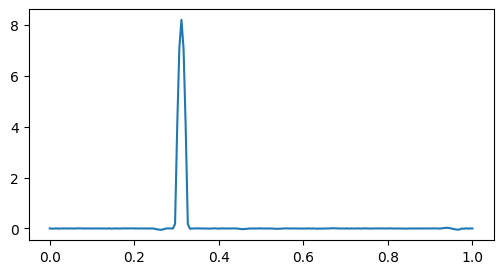

eigenstate: 4, epoch: 8500
ev: 111211.07, norm: 1.0001457, pde: 3656.3157, loss: 3657.8345, loc_idx: 0, used_loc_idxs: []


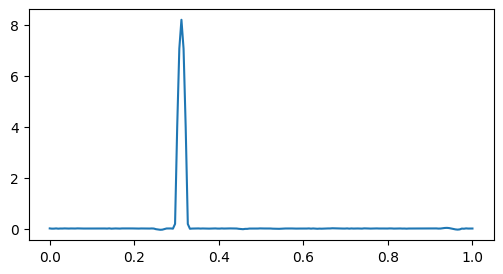

eigenstate: 4, epoch: 8600
ev: 111211.9, norm: 1.0003269, pde: 4527.73, loss: 4530.3384, loc_idx: 0, used_loc_idxs: []


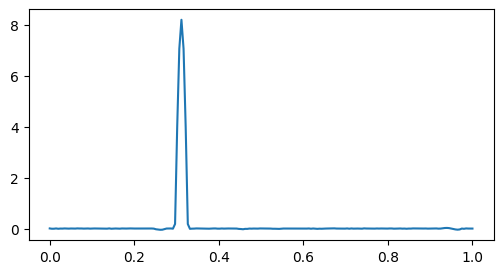

eigenstate: 4, epoch: 8700
ev: 111211.28, norm: 1.0002345, pde: 4144.735, loss: 4146.808, loc_idx: 0, used_loc_idxs: []


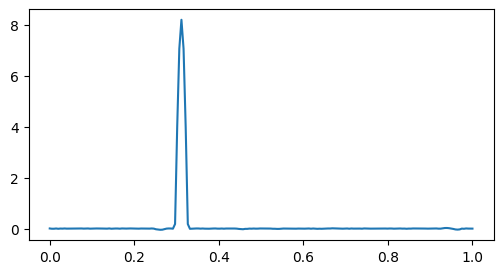

eigenstate: 4, epoch: 8800
ev: 111211.96, norm: 0.9999313, pde: 4252.615, loss: 4254.267, loc_idx: 0, used_loc_idxs: []


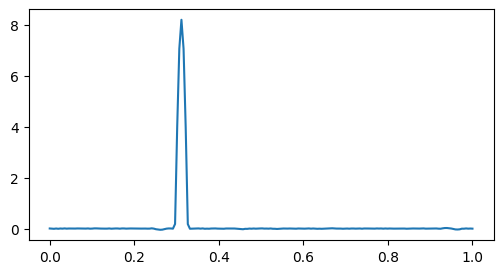

eigenstate: 4, epoch: 8900
ev: 111212.375, norm: 1.0000435, pde: 3735.8115, loss: 3738.7595, loc_idx: 0, used_loc_idxs: []


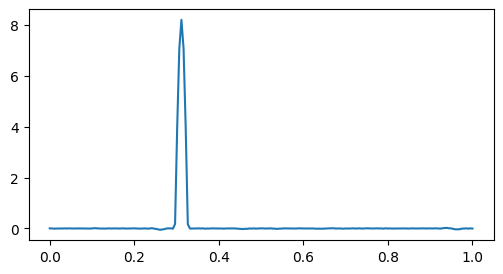

OUT OF EPOCHS
CPU times: user 1h 21min 50s, sys: 1min 57s, total: 1h 23min 48s
Wall time: 1h 20min 19s


In [5]:
#@title Model

# generating the eigenstates
%%time

def build_model():
  # Input only the x values
  inputs = tf.keras.Input(shape=(n,1))

  # For eigenvalue
  a = tf.keras.layers.Dense(n, activation="relu")(inputs)
  a = tf.keras.layers.Dense(n, activation="relu")(a)
  a = tf.keras.layers.AveragePooling1D(pool_size=n)(a)
  a = tf.keras.layers.Flatten()(a)
  ev_out = tf.keras.layers.Dense(1)(a)

  # For eigenfunction
  b = tf.keras.layers.Dense(n, activation="relu")(inputs)
  b = tf.keras.layers.Dense(n, activation=tf.math.sin)(b)
  b = tf.keras.layers.Dense(n, activation="relu")(b)
  b = tf.keras.layers.AveragePooling1D(pool_size=n)(b)
  b = tf.keras.layers.Flatten()(b)

  # Standard deviation is increased here to add more noise. This fixes the issue where
  # the network will get confused trying to converge to u(x) and -u(x) at the same time.
  # The added noise places the first u(x) prediction close enough to one of u(x) or -u(x)
  # so that it converges to that one, instead of the first prediction being in the middle of the two.
  evec_out = tf.keras.layers.Dense(n, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1.5))(b)

  outputs = tf.keras.layers.Concatenate(axis=1)([ev_out, evec_out])

  model = tf.keras.Model(inputs=inputs, outputs=outputs, name="model")


  @tf.autograph.experimental.do_not_convert
  def my_loss(_, y_pred):

    ev = y_pred[0][0]
    evec = y_pred[0][1:]
    D = tf.math.sqrt(tf.math.reduce_mean((ev*evec + secDerivative(evec) - V*evec)**2))

    norm = integral(evec**2)

    loss = D + 1/h**2*(evec[0]**2 + evec[-1]**2) + 1/h**3*(norm - 1)**2

    # normalisation loss
    if collected_evecs:
      for old_evec in collected_evecs:
        loss += 1/h**3*integral(evec*old_evec)**2
    
    # localisation loss
    # if this is causing the localised regions to be too squished, a fix
    # is to add the integrals of either side of segment_int to itself.
    # This would require taking care of the cases where max_int = 0 and max_int = m-1
    # which can be done with tf.cond or tf.where

    if localisation_loss:

      segment_norm = tf.cond(loc_idx >= 0,
                             lambda: tf.math.reduce_sum(idxs_one_hot*[integral(segment**2) for segment in split(evec)]),
                             lambda: norm)
      loss += 1/h**3.25*(segment_norm - norm)**2

    return loss
  

  def my_loss_fn(y_true, y_pred):
    return tf.py_function(my_loss, [y_true, y_pred], tf.int64)

  model.compile(
      loss = my_loss,
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  )

  return model


# eigenstate collection loop
for j in range(num_eigenstates):

  model = build_model()

  converged = False
  

  # training loop
  for i in range(n_epochs):
      # pass tile of the current epoch number to train_outputs to use in the loss function
      tile = np.repeat(float(i), n)
      i_tile = tf.reshape(tf.tile(tile, [1]), [1,n])

      model.fit(train_inputs, i_tile, epochs=1, verbose=0)

      # output the ev and evec predictions throughout the training process
      if (i % 100 == 0):

        ev_fun = K.function([model.layers[0].input], model.layers[-3].output)
        ev = ev_fun(train_inputs)[0][0]
        ev_list.append(ev)

        evec_fun = K.function([model.layers[0].input], model.layers[-2].output)
        evec = evec_fun(train_inputs)[0]
        evec_list.append(evec)

        norm = integral(evec**2)
        D = tf.math.sqrt(tf.math.reduce_mean((ev*evec + secDerivative(evec) - V*evec)**2))

        loss = D + 1/h**2*(evec[0]**2 + evec[-1]**2) + 1/h**3*(norm - 1)**2

        if collected_evecs:
          for old_evec in collected_evecs:
            loss += 1/h**3*integral(evec*old_evec)**2

        if localisation_loss:

          
          # refresh idx_groups
          # if i == refresh_epoch and len(idx_groups) == len(used_loc_idxs):
          if i == refresh_epoch:
            assign_idx_groups(evec)
            print("SETTING IDX_GROUPS")
            print("idx_groups:", idx_groups)

            # initialise the model weights again so the model can converge given the new loss function
            if recompile_model:
              model = build_model() 


          if loc_idx.numpy() >= 0:
            segment_norm = tf.math.reduce_sum(idxs_one_hot*[integral(segment**2) for segment in split(evec)])
            
            loss += 1/h**3.25*(segment_norm - norm)**2
          
          # assigning a value to loc_idx
          if i >= refresh_epoch and loc_idx == -1:
            loc_idx.assign(0)
            idxs_one_hot.assign(idxs_to_one_hot(idx_groups[0]))


              
            # TODO: assess whether this is necessary
            # if we reach here with loc_idx = -1 then we have searched through all the given locations. 
            # we then want to go through the list again to get higher eigenstates
            if loc_idx == -1:
              used_loc_idxs = []
              if idx_groups:
                loc_idx.assign(0)
              else:
                # else there are no localisation locations so we assign -1
                loc_idx.assign(-1)
              idxs_one_hot.assign(tf.zeros(m))
              idx_groups = []
        

        print("eigenstate:", str(j+1) + ", epoch:", i)
        print("ev:", str(ev) + ", norm:", str(integral(evec**2).numpy()) + ", pde:", str(D.numpy()) + ", loss:", str(loss.numpy()) +  ", loc_idx:", str(loc_idx.numpy()) + ", used_loc_idxs:", used_loc_idxs)

        plt.figure(figsize=(6,3))
        plt.plot(x, evec)
        plt.show()
        
        # collect eigenstates
        if (len(ev_list) > 5) and has_converged(ev_list, evec_list):
          collected_evecs.append(evec)
          collected_evs.append(ev)
          print("EIGENSTATE FOUND")

          # reset used_loc_idxs if we've used all of them
          if loc_idx == len(idx_groups):
            used_loc_idxs = []

          loc_idx.assign(-1)
          idxs_one_hot.assign(tf.zeros(m))

          converged = True

          break
  
  # if the model is out of epochs and hasn't converged
  if not converged:
    collected_evecs.append(evec)
    collected_evs.append(ev)
    print("OUT OF EPOCHS")
    loc_idx.assign(-1)
    idxs_one_hot.assign(tf.zeros(m))

# sort the eigenstates by their eigenvalue
collected_evecs = [collected_evecs[collected_evs.index(ev)] for ev in sorted(collected_evs)]
collected_evs = sorted(collected_evs)
  

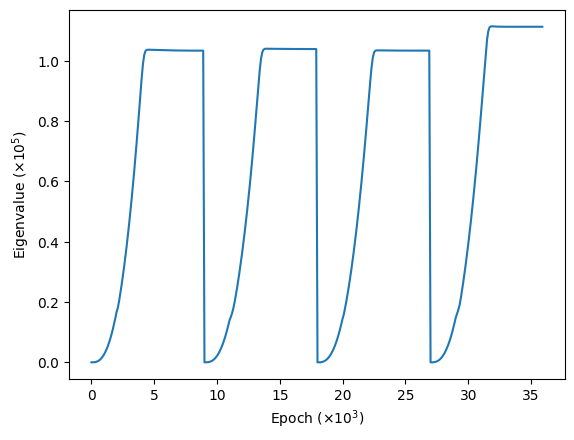

In [6]:
#@title Plotting ev_list

plt.xlabel("Epoch (×$10^3$)")
plt.ylabel("Eigenvalue (×$10^5$)")
plt.plot([epoch/10 for epoch in range(len(ev_list))], [ev/100000 for ev in ev_list])

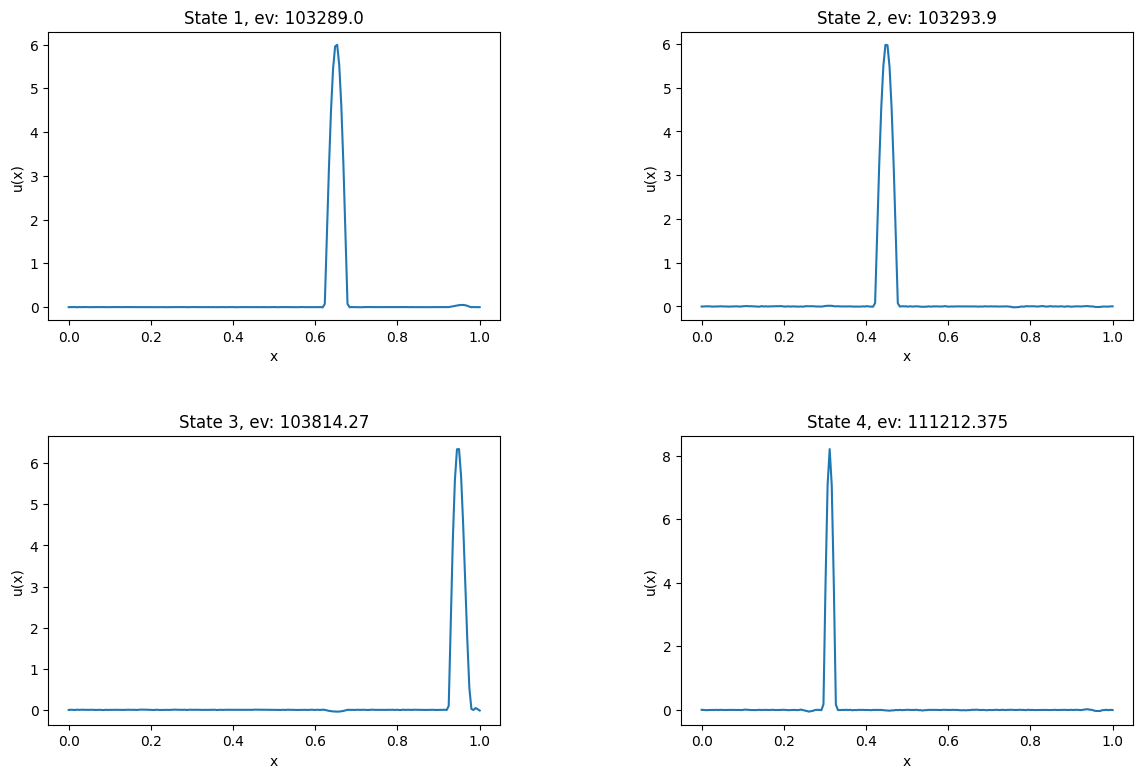

In [7]:
#@title Plotting four eigenstates

# for 4 eigenstates

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 9))

axs[0, 0].plot(x, collected_evecs[0])
axs[0, 1].plot(x, collected_evecs[1])
axs[1, 0].plot(x, collected_evecs[2])
axs[1, 1].plot(x, collected_evecs[3])

axs[0, 0].set_ylabel("u(x)")
axs[0, 1].set_ylabel("u(x)")
axs[1, 0].set_ylabel("u(x)")
axs[1, 1].set_ylabel("u(x)")

axs[0, 0].set_xlabel("x")
axs[0, 1].set_xlabel("x")
axs[1, 0].set_xlabel("x")
axs[1, 1].set_xlabel("x")

axs[0, 0].set_title("State 1, ev: " + str(collected_evs[0]))
axs[0, 1].set_title("State 2, ev: " + str(collected_evs[1]))
axs[1, 0].set_title("State 3, ev: " + str(collected_evs[2]))
axs[1, 1].set_title("State 4, ev: " + str(collected_evs[3]))

fig.subplots_adjust(hspace=0.4, wspace=0.4)


plt.show()

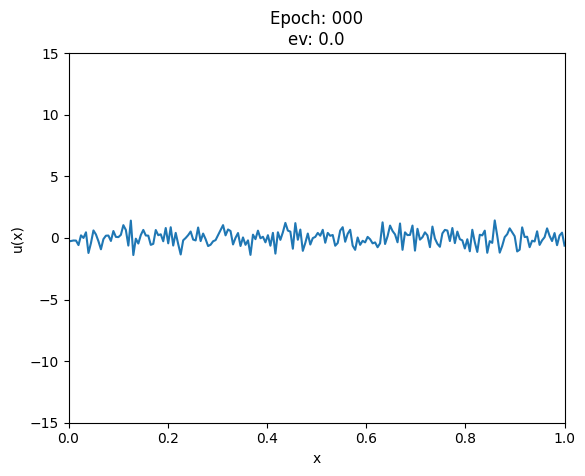

In [7]:
#@title Generating Training Video

from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.set_xlim(0,1)
ax.set_ylim(-15,15)
line, = ax.plot(0,0)

xs = np.array([x for i in range(len(evec_list))])
data = np.array([xs, evec_list])

x_list = x
y_list = []

def animation_frame(i):
  y_list = evec_list[i]

  line.set_xdata(x_list)
  line.set_ydata(y_list)

  ax.set_title("Epoch: " + str(i) + "00\n" + "ev: " + str(np.round(ev_list[i], 0)))

  # y_data = data[i]

  # line.set_xdata(x)
  # line.set_ydata(y_data)
  return line, 

from matplotlib import rc
rc('animation', html='jshtml')

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, len(evec_list), 1), interval=50)

# animation

from IPython.display import HTML
HTML(animation.to_html5_video())

[]

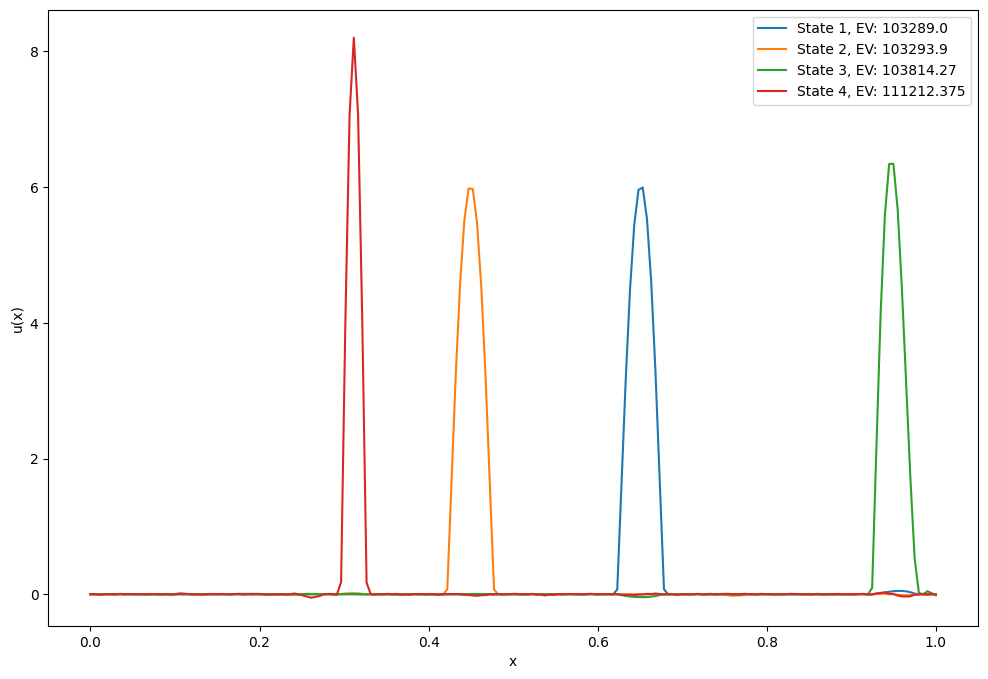

In [9]:
#@title Plotting All Eigenstates

plt.figure(figsize=(12,8))

plt.xlabel("x")
plt.ylabel("u(x)")
for j in range(len(collected_evecs)):
  plt.plot(x, collected_evecs[j], label="State " + str(j+1) + ", EV: " + str(collected_evs[j]))

plt.legend()
plt.plot()